## 数据收集

In [2]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
import lightgbm as lgb
from datetime import datetime
import pickle

In [4]:
store = pd.read_csv('data/store.csv', low_memory=False)
train = pd.read_csv('data/train.csv', low_memory=False)
test = pd.read_csv('data/test.csv', low_memory=False)

In [5]:
sample_submission = pd.read_csv('data/sample_submission.csv', low_memory=False)

In [4]:
sample_submission.head()

,Id,Sales
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


## 数据评估及清洗

### 观察数据
#### `store`数据集

In [5]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [12]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [13]:
store.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [14]:
store.StoreType.value_counts()

a    602
d    348
c    148
b     17
Name: StoreType, dtype: int64

In [13]:
store.Assortment.value_counts()

a    593
c    513
b      9
Name: Assortment, dtype: int64

In [14]:
store.CompetitionDistance.sort_values().head()

515     20.0
881     30.0
1007    30.0
620     30.0
987     30.0
Name: CompetitionDistance, dtype: float64

In [15]:
store.CompetitionOpenSinceYear.sort_values().value_counts()

2013.0    83
2012.0    82
2014.0    70
2005.0    62
2010.0    55
2008.0    54
2009.0    54
2011.0    54
2007.0    48
2006.0    47
2015.0    38
2002.0    27
2004.0    22
2003.0    19
2001.0    16
2000.0    10
1999.0     8
1990.0     5
1995.0     2
1994.0     2
1998.0     1
1961.0     1
1900.0     1
Name: CompetitionOpenSinceYear, dtype: int64

In [16]:
store.CompetitionOpenSinceMonth.value_counts()

9.0     125
4.0      94
11.0     92
3.0      70
7.0      67
12.0     64
10.0     61
6.0      50
5.0      44
2.0      41
8.0      39
1.0      14
Name: CompetitionOpenSinceMonth, dtype: int64

In [17]:
store.Promo2.value_counts()

1    571
0    544
Name: Promo2, dtype: int64

In [18]:
store.Promo2SinceWeek.value_counts()

14.0    81
40.0    77
31.0    44
10.0    42
5.0     39
37.0    35
1.0     35
45.0    34
13.0    34
22.0    33
18.0    29
35.0    25
9.0     14
27.0    11
36.0    10
48.0     9
39.0     6
23.0     5
44.0     3
49.0     1
6.0      1
26.0     1
50.0     1
28.0     1
Name: Promo2SinceWeek, dtype: int64

In [19]:
store.PromoInterval.value_counts()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: PromoInterval, dtype: int64

In [20]:
store.loc[store['Promo2']==0, ['Promo2SinceWeek','Promo2SinceWeek','PromoInterval']].head()

,Promo2SinceWeek,Promo2SinceWeek,PromoInterval
0,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
5,NaN,NaN,NaN
6,NaN,NaN,NaN


#### `train`数据集

In [21]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [23]:
train[train.Sales>0].describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,844338.000000,844338.000000,844338.000000,844338.000000,844338.0,844338.000000,844338.000000
mean,558.421374,3.520350,6955.959134,762.777166,1.0,0.446356,0.193578
std,321.730861,1.723712,3103.815515,401.194153,0.0,0.497114,0.395102
min,1.000000,1.000000,46.000000,8.000000,1.0,0.000000,0.000000
25%,280.000000,2.000000,4859.000000,519.000000,1.0,0.000000,0.000000
50%,558.000000,3.000000,6369.000000,676.000000,1.0,0.000000,0.000000
75%,837.000000,5.000000,8360.000000,893.000000,1.0,1.000000,0.000000
max,1115.000000,7.000000,41551.000000,7388.000000,1.0,1.000000,1.000000


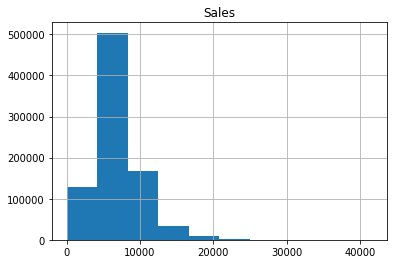

In [24]:
train[train.Sales>0].hist(column='Sales');

In [6]:
train[train.Sales>30000].head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
5836,262,7,2015-07-26,32547,4783,1,0,0,0
13641,262,7,2015-07-19,31665,4691,1,0,0,0
21446,262,7,2015-07-12,32271,4623,1,0,0,0
29251,262,7,2015-07-05,30255,4762,1,0,0,0
43278,909,2,2015-06-23,30038,1635,1,0,0,0


In [27]:
train.DayOfWeek.value_counts()

5    145845
4    145845
3    145665
2    145664
7    144730
6    144730
1    144730
Name: DayOfWeek, dtype: int64

In [28]:
train.Open.value_counts()

1    844392
0    172817
Name: Open, dtype: int64

In [29]:
train.Promo.value_counts()

0    629129
1    388080
Name: Promo, dtype: int64

In [30]:
train.StateHoliday.value_counts()

0    986159
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [31]:
train['StateHoliday'].unique()

array(['0', 'a', 'b', 'c'], dtype=object)

In [32]:
train[train['StateHoliday'] == 0]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday


In [5]:
train[train['StateHoliday'] == '0'].head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [34]:
train.SchoolHoliday.value_counts()

0    835488
1    181721
Name: SchoolHoliday, dtype: int64

In [35]:
train[(train['Open']==1) & (train['Sales']==0)][['Store','Sales','Open','StateHoliday','SchoolHoliday']]

,Store,Sales,Open,StateHoliday,SchoolHoliday
86825,971,0,1,0,1
142278,674,0,1,0,0
196938,699,0,1,0,0
322053,708,0,1,0,0
330176,357,0,1,0,0
340348,227,0,1,0,0
340860,835,0,1,0,0
341795,835,0,1,0,0
346232,548,0,1,0,1
346734,28,0,1,0,0


#### `test`数据集

In [36]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [37]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null object
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


In [171]:
test[test.Open==1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35093 entries, 0 to 41087
Data columns (total 8 columns):
Id               35093 non-null int64
Store            35093 non-null int64
DayOfWeek        35093 non-null int64
Date             35093 non-null object
Open             35093 non-null float64
Promo            35093 non-null int64
StateHoliday     35093 non-null object
SchoolHoliday    35093 non-null int64
dtypes: float64(1), int64(5), object(2)
memory usage: 2.4+ MB


In [38]:
len(test.Store.unique())

856

In [39]:
test.DayOfWeek.value_counts()

7    5992
6    5992
4    5992
3    5992
2    5992
1    5992
5    5136
Name: DayOfWeek, dtype: int64

In [40]:
test.Date.unique()

array(['2015-09-17', '2015-09-16', '2015-09-15', '2015-09-14',
       '2015-09-13', '2015-09-12', '2015-09-11', '2015-09-10',
       '2015-09-09', '2015-09-08', '2015-09-07', '2015-09-06',
       '2015-09-05', '2015-09-04', '2015-09-03', '2015-09-02',
       '2015-09-01', '2015-08-31', '2015-08-30', '2015-08-29',
       '2015-08-28', '2015-08-27', '2015-08-26', '2015-08-25',
       '2015-08-24', '2015-08-23', '2015-08-22', '2015-08-21',
       '2015-08-20', '2015-08-19', '2015-08-18', '2015-08-17',
       '2015-08-16', '2015-08-15', '2015-08-14', '2015-08-13',
       '2015-08-12', '2015-08-11', '2015-08-10', '2015-08-09',
       '2015-08-08', '2015-08-07', '2015-08-06', '2015-08-05',
       '2015-08-04', '2015-08-03', '2015-08-02', '2015-08-01'], dtype=object)

In [41]:
test.Open.unique()

array([  1.,  nan,   0.])

In [42]:
test[test['Open'].isnull()]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
479,480,622,4,2015-09-17,NaN,1,0,0
1335,1336,622,3,2015-09-16,NaN,1,0,0
2191,2192,622,2,2015-09-15,NaN,1,0,0
3047,3048,622,1,2015-09-14,NaN,1,0,0
4759,4760,622,6,2015-09-12,NaN,0,0,0
5615,5616,622,5,2015-09-11,NaN,0,0,0
6471,6472,622,4,2015-09-10,NaN,0,0,0
7327,7328,622,3,2015-09-09,NaN,0,0,0
8183,8184,622,2,2015-09-08,NaN,0,0,0
9039,9040,622,1,2015-09-07,NaN,0,0,0


In [43]:
test.Promo.value_counts()

0    24824
1    16264
Name: Promo, dtype: int64

In [44]:
test.StateHoliday.value_counts()

0    40908
a      180
Name: StateHoliday, dtype: int64

In [45]:
test.SchoolHoliday.value_counts()

0    22866
1    18222
Name: SchoolHoliday, dtype: int64

### 数据评估

### 数据清洗

In [6]:
# 创建清洗的数据集
store_clean = store.copy()
train_clean = train.copy()
test_clean = test.copy()

#### `store`表的`CompetitionOpenSinceMonth`、`CompetitionOpenSinceYear`、`Promo2SinceWeek`、`Promo2SinceYear`列有缺失值

In [7]:
# 用均值填充CompetitionDistance列
store_clean['CompetitionDistance'] = store_clean.groupby('StoreType')['CompetitionDistance'].apply(lambda x: x.fillna(x.mean()))
# store_clean['CompetitionDistance'] = store_clean['CompetitionDistance'].fillna(store_clean['CompetitionDistance'].mean())

In [8]:
# CompetitonOpenSinceMonth/Year 的缺失值填充0
store_clean['CompetitionOpenSinceMonth'] = store_clean['CompetitionOpenSinceMonth'].fillna(0)
store_clean['CompetitionOpenSinceYear'] = store_clean['CompetitionOpenSinceYear'].fillna(0)

In [9]:
# Promo2SinceWeek和Promo2SinceYear的缺失记录，Promo2都等于0，因此缺失值填充0
store_clean.loc[store['Promo2']==0, ['Promo2SinceWeek','Promo2SinceYear','PromoInterval']] = 0

#### *测试*

In [10]:
# 重新查看store数据集是否有缺失值
store_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1115 non-null float64
CompetitionOpenSinceMonth    1115 non-null float64
CompetitionOpenSinceYear     1115 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              1115 non-null float64
Promo2SinceYear              1115 non-null float64
PromoInterval                1115 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


#### 类别变量的值用数字编码替换

In [11]:
# StoreType的值用数字表示
store_clean['StoreType'] = store_clean['StoreType'].map({'a':1,'b':2,'c':3,'d':4}) 

In [12]:
# Assortment的值用数字表示
store_clean['Assortment'] = store_clean['Assortment'].map({'a':1,'b':2,'c':3}) 

In [19]:
print(store_clean.head())

   Store  StoreType  Assortment  CompetitionDistance  \
0      1          3           1               1270.0   
1      2          1           1                570.0   
2      3          1           1              14130.0   
3      4          3           3                620.0   
4      5          1           1              29910.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                       11.0                    2007.0       1   
2                       12.0                    2006.0       1   
3                        9.0                    2009.0       0   
4                        4.0                    2015.0       0   

   Promo2SinceWeek  Promo2SinceYear    PromoInterval  
0              0.0              0.0                0  
1             13.0           2010.0  Jan,Apr,Jul,Oct  
2             14.0           2011.0  Jan,Apr,Jul,Oct  
3              0.0              0.0           

#### `train`和`test`数据集的`Date`列类型为字符串型，更改为时间戳类型


In [13]:
train_clean.Date = pd.to_datetime(train_clean.Date)
test_clean.Date = pd.to_datetime(test_clean.Date)

#### *测试*

In [576]:
# 查看train和test数据集的Date列数据类型
train_clean.Date.dtype, test_clean.Date.dtype

(dtype('<M8[ns]'), dtype('<M8[ns]'))

#### `test`数据集的`Open`列数据有缺失值，查看后发现都是工作日，且都来自同一个商店。因此都赋值Open=1

In [14]:
test_clean['Open'] = test_clean['Open'].fillna(value=1.0)

In [15]:
test_clean['Open'].unique()

array([ 1.,  0.])

In [16]:
test_clean['Open'] = test_clean['Open'].astype('int64')

#### *测试*

In [25]:
# 查看Open列的数据类型
test_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null datetime64[ns]
Open             41088 non-null int64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: datetime64[ns](1), int64(6), object(1)
memory usage: 2.5+ MB


In [26]:
test_clean['Open'].unique()

array([1, 0], dtype=int64)

#### train和test的StateHoliday和SchoolHoliday列的值用数字编码替代

In [17]:
train_clean['StateHoliday'] = train_clean['StateHoliday'].map({'0':0, 'a':1, 'b':2, 'c':3})
test_clean['StateHoliday'] = test_clean['StateHoliday'].map({'0':0, 'a':1, 'b':2, 'c':3})

In [18]:
train_clean.StateHoliday.unique(), test_clean.StateHoliday.unique()

(array([0, 1, 2, 3], dtype=int64), array([0, 1], dtype=int64))

## 数据集合并及保存
#### train和test数据集以Store为主键分别与store数据集合并

In [19]:
train_df = train_clean.merge(store_clean, on='Store',how='left')
test_df = test_clean.merge(store_clean, on='Store',how='left')

In [416]:
# 查看合并后的数据集列
train_df.info()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
Store                        1017209 non-null int64
DayOfWeek                    1017209 non-null int64
Date                         1017209 non-null datetime64[ns]
Sales                        1017209 non-null int64
Customers                    1017209 non-null int64
Open                         1017209 non-null int64
Promo                        1017209 non-null int64
StateHoliday                 1017209 non-null int64
SchoolHoliday                1017209 non-null int64
StoreType                    1017209 non-null int64
Assortment                   1017209 non-null int64
CompetitionDistance          1017209 non-null float64
CompetitionOpenSinceMonth    1017209 non-null float64
CompetitionOpenSinceYear     1017209 non-null float64
Promo2                       1017209 non-null int64
Promo2SinceWeek              1017209 non-null float64
Promo2SinceYear              1017209 n

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,1,1,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,1,1,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,3,3,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,2015-07-31,4822,559,1,1,0,1,1,1,29910.0,4.0,2015.0,0,0.0,0.0,0


In [417]:
test_df.info()
test_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 17 columns):
Id                           41088 non-null int64
Store                        41088 non-null int64
DayOfWeek                    41088 non-null int64
Date                         41088 non-null datetime64[ns]
Open                         41088 non-null int64
Promo                        41088 non-null int64
StateHoliday                 41088 non-null int64
SchoolHoliday                41088 non-null int64
StoreType                    41088 non-null int64
Assortment                   41088 non-null int64
CompetitionDistance          41088 non-null float64
CompetitionOpenSinceMonth    41088 non-null float64
CompetitionOpenSinceYear     41088 non-null float64
Promo2                       41088 non-null int64
Promo2SinceWeek              41088 non-null float64
Promo2SinceYear              41088 non-null float64
PromoInterval                41088 non-null object
dtypes: datetime64[ns

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1,1,0,0,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,3,4,2015-09-17,1,1,0,0,1,1,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,3,7,4,2015-09-17,1,1,0,0,1,3,24000.0,4.0,2013.0,0,0.0,0.0,0
3,4,8,4,2015-09-17,1,1,0,0,1,1,7520.0,10.0,2014.0,0,0.0,0.0,0
4,5,9,4,2015-09-17,1,1,0,0,1,3,2030.0,8.0,2000.0,0,0.0,0.0,0


#### 保存数据集为.csv格式文件

In [20]:
train_df.to_csv('train_clean.csv')
test_df.to_csv('test_clean.csv')

## 数据分析和可视化

#### 从日期列中提取时间特征：

In [21]:
# 提取年
train_df['Year'] = train_df.Date.dt.year
test_df['Year'] = test_df.Date.dt.year
# 提取月
train_df['Month'] = train_df.Date.dt.month
test_df['Month'] = test_df.Date.dt.month
# 提取日（一个月的第几天）
train_df['Day'] = train_df.Date.dt.day
test_df['Day'] = test_df.Date.dt.day
# 提取日（一年的第几天）
train_df['DayOfYear'] = train_df.Date.dt.dayofyear
test_df['DayOfYear'] = test_df.Date.dt.dayofyear
# 提取一年中的第几周
train_df['Week'] = train_df.Date.dt.week
test_df['Week'] = test_df.Date.dt.week

In [420]:
print(train_df[['Year','Month','Day','DayOfYear','Week']].head())
print(test_df[['Year','Month','Day','DayOfYear','Week']].head())

   Year  Month  Day  DayOfYear  Week
0  2015      7   31        212    31
1  2015      7   31        212    31
2  2015      7   31        212    31
3  2015      7   31        212    31
4  2015      7   31        212    31
   Year  Month  Day  DayOfYear  Week
0  2015      9   17        260    38
1  2015      9   17        260    38
2  2015      9   17        260    38
3  2015      9   17        260    38
4  2015      9   17        260    38


#### 观察销售额随时间的统计

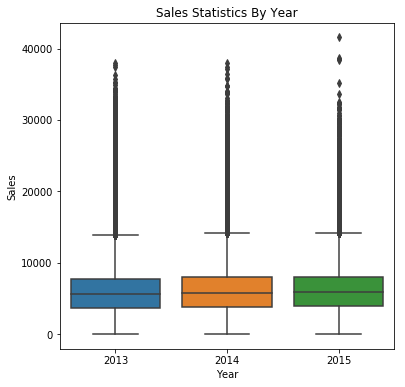

In [300]:
fig, ax = plt.subplots(figsize=(6,6))
ax.set_title('Sales Statistics By Year')
sb.boxplot(data=train_df, x='Year', y='Sales', ax=ax)
plt.show()
fig.savefig('graph/sales_statistics_by_year.jpg')

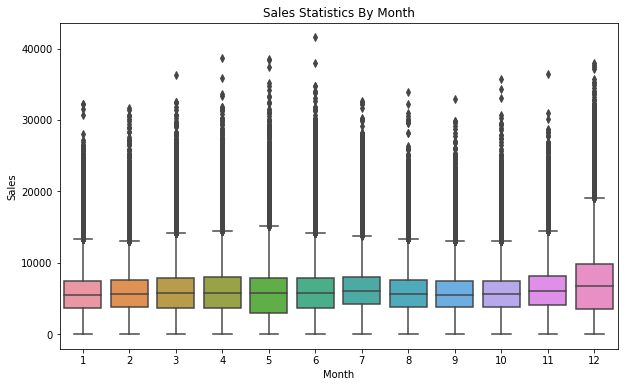

In [301]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_title('Sales Statistics By Month')
sb.boxplot(data=train_df, x='Month', y='Sales', ax=ax)
plt.show()
fig.savefig('graph/sales_statistics_by_month.jpg')

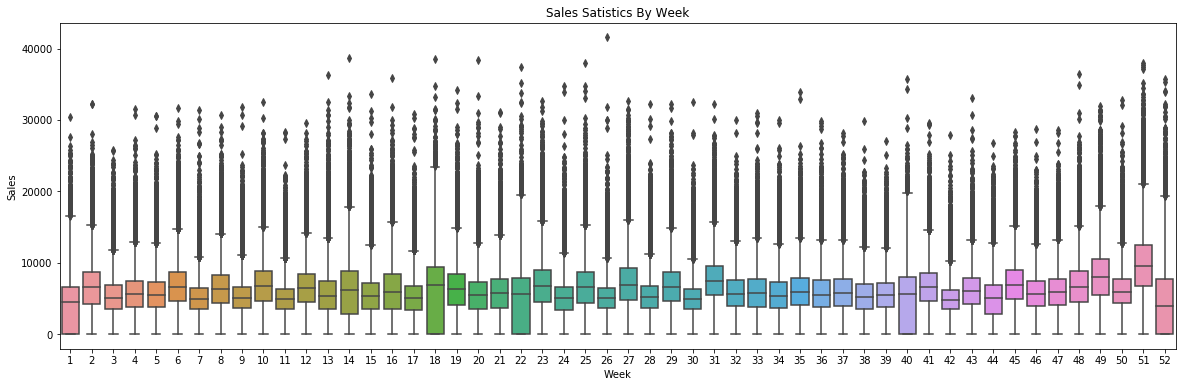

In [302]:
fig, ax = plt.subplots(figsize=(20,6))
ax.set_title('Sales Satistics By Week')
sb.boxplot(data=train_df, x='Week', y='Sales', ax=ax)
plt.show()
fig.savefig('graph/sales_statistics_by_week.jpg')

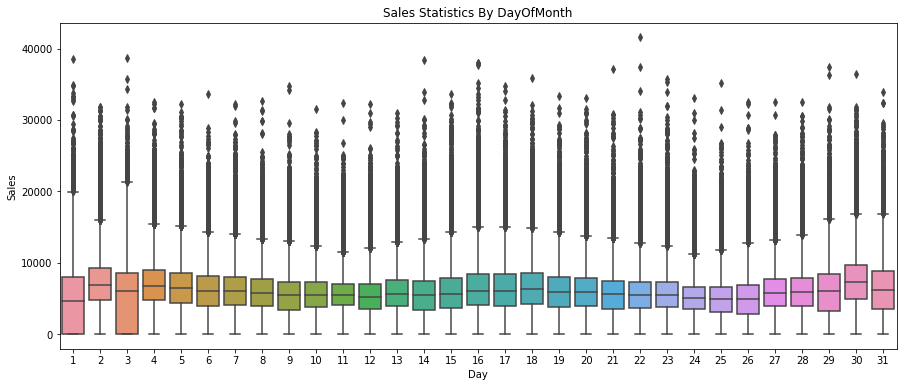

In [303]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title('Sales Statistics By DayOfMonth')
sb.boxplot(data=train_df, x='Day', y='Sales', ax=ax)
plt.show()
fig.savefig('graph/sales_statistics_by_dayofmonth.jpg')

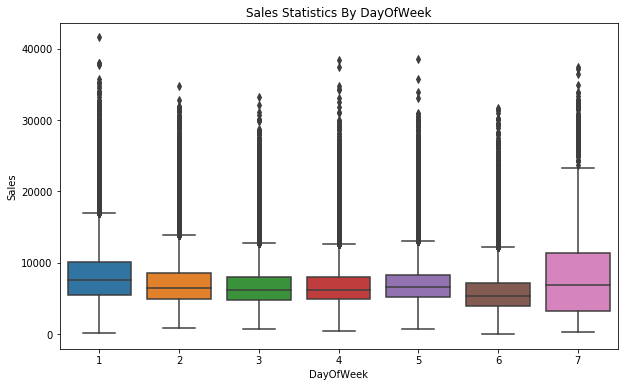

In [689]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_title('Sales Statistics By DayOfWeek')
sb.boxplot(data=train_df, x='DayOfWeek', y='Sales', ax=ax)
plt.show()
fig.savefig('graph/sales_statistics_by_dayofweek.jpg')

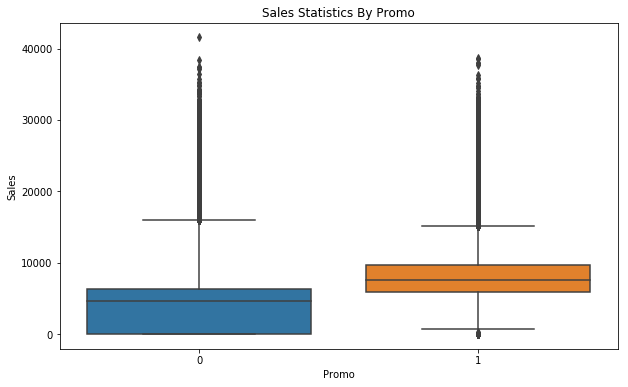

In [136]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_title('Sales Statistics By Promo')
sb.boxplot(data=train_df, x='Promo', y='Sales', ax=ax)
plt.show()
fig.savefig('graph/sales_statistics_by_promo.jpg')

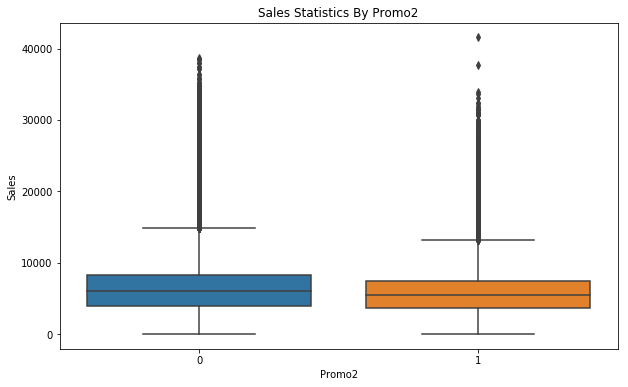

In [137]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_title('Sales Statistics By Promo2')
sb.boxplot(data=train_df, x='Promo2', y='Sales', ax=ax)
plt.show()
fig.savefig('graph/sales_statistics_by_promo2.jpg')

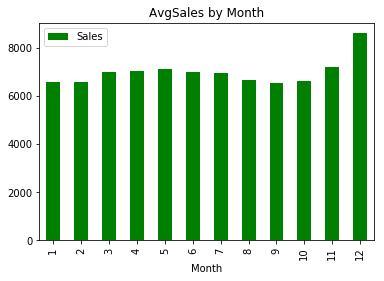

In [68]:
ax = train_df[train_df.Sales>0].groupby('Month')['Sales'].mean().reset_index().plot(kind='bar',x='Month',y='Sales', color='g', title='AvgSales by Month');

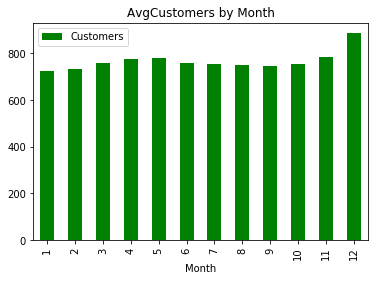

In [69]:
ax = train_df[train_df.Sales>0].groupby('Month')['Customers'].mean().reset_index().plot(kind='bar',x='Month',y='Customers', color='g', title='AvgCustomers by Month');

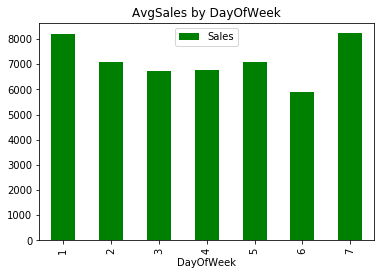

In [70]:
ax = train_df[train_df.Sales>0].groupby('DayOfWeek')['Sales'].mean().reset_index().plot(kind='bar',x='DayOfWeek',y='Sales', color='g', title='AvgSales by DayOfWeek');

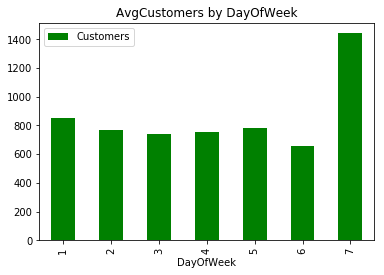

In [71]:
ax = train_df[train_df.Sales>0].groupby('DayOfWeek')['Customers'].mean().reset_index().plot(kind='bar',x='DayOfWeek',y='Customers', color='g', title='AvgCustomers by DayOfWeek');

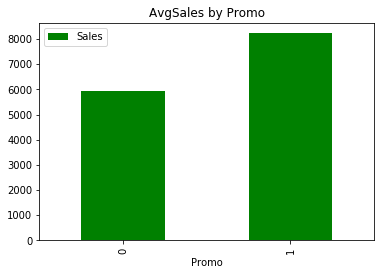

In [72]:
ax = train_df[train_df.Sales>0].groupby('Promo')['Sales'].mean().reset_index().plot(kind='bar',x='Promo',y='Sales', color='g', title='AvgSales by Promo');

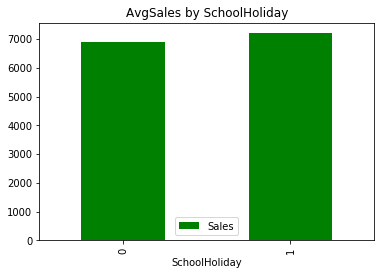

In [73]:
ax = train_df[train_df.Sales>0].groupby('SchoolHoliday')['Sales'].mean().reset_index().plot(kind='bar',x='SchoolHoliday',y='Sales', color='g', title='AvgSales by SchoolHoliday');

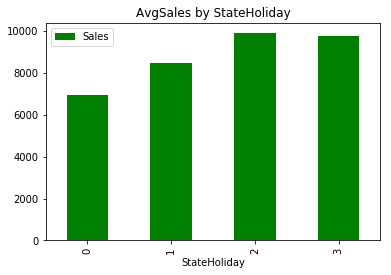

In [74]:
ax = train_df[train_df.Sales>0].groupby('StateHoliday')['Sales'].mean().reset_index().plot(kind='bar',x='StateHoliday',y='Sales', color='g', title='AvgSales by StateHoliday');

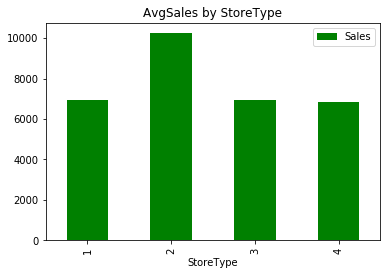

In [89]:
ax = train_df[train_df.Sales>0].groupby('StoreType')['Sales'].mean().reset_index().plot(kind='bar',x='StoreType',y='Sales', color='g', title='AvgSales by StoreType');

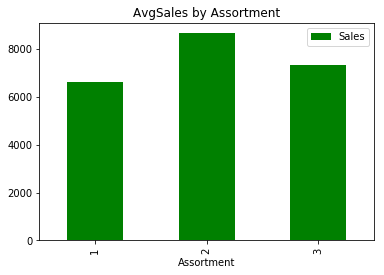

In [90]:
ax = train_df[train_df.Sales>0].groupby('Assortment')['Sales'].mean().reset_index().plot(kind='bar',x='Assortment',y='Sales', color='g', title='AvgSales by Assortment');

#### 观察销售额与竞争距离的关系

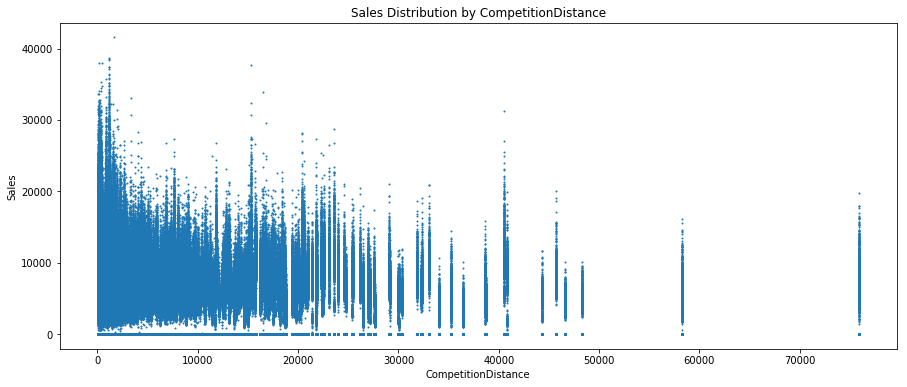

In [85]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(1,1,1)
#ax.set_title('Sales Statistics By CompetitionDistance')
ax1.set_title('Sales Distribution by CompetitionDistance')
plt.xlabel('CompetitionDistance')
plt.ylabel('Sales')
ax1.scatter(x='CompetitionDistance', y='Sales', data=train_df, s=1)
plt.show()
#sb.pairplot(data=train_df, vars=['CompetitionDistance','Sales'])
#ax.show()
#ax.savefig('graph/sales_statistics_by_CompetitionDistance.jpg')

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_title('Sales Year')
sb.countplot(data=train_df, x='Sales', ax=ax)
plt.show()
fig.savefig('graph/sales_year.jpg')

#### 观察销售额在一周7天的统计

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_title('Sales Statistics By Promo2')
sb.countplot(data=train_df, x='Promo2', y='Sales', ax=ax)
plt.show()
fig.savefig('graph/sales_statistics_by_promo2.jpg')
plt.hist()

#### 观察销售额的统计分布

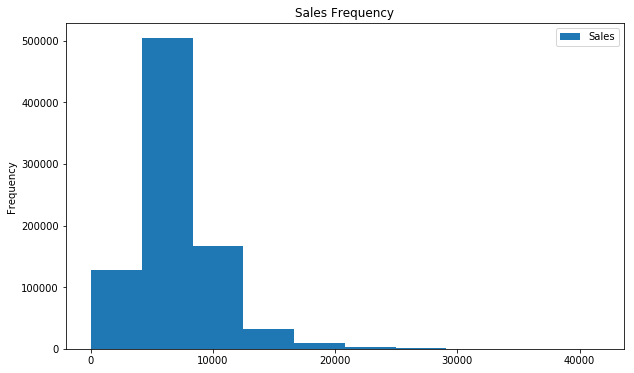

In [88]:
train_df[train_df.Sales>0].plot(kind='hist', y='Sales', title='Sales Frequency', figsize=(10,6));

#### 观察客户数量的分布

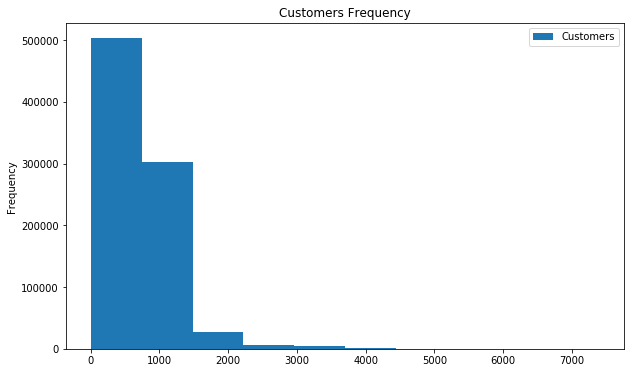

In [34]:
train_df[train_df.Sales>0].plot(kind='hist', y='Customers', title='Customers Frequency', figsize=(10,6));

#### 观察CompetitionDistance变量的分布

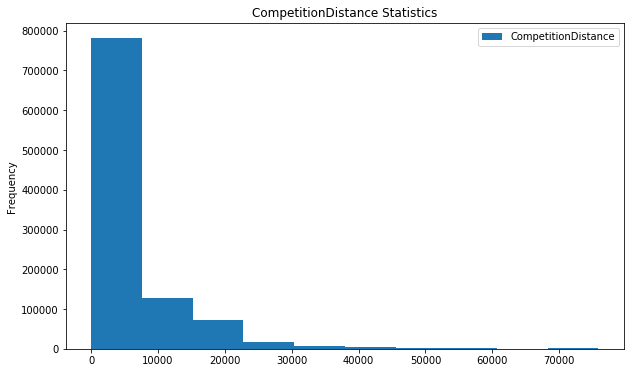

In [35]:
train_df.plot(kind='hist', y='CompetitionDistance', title='CompetitionDistance Statistics', figsize=(10,6));

### 提取特征

#### 训练集特征提取

In [22]:
# 保存train_df到文件
train_df.to_csv('data_clean/train_df.csv', index=False)

In [23]:
# 筛选销售额大于0的记录
train_df = train_df[train_df['Sales']>0]

# 筛选open=1的记录
train_df = train_df[train_df['Open']==1]

# 销售额和竞争距离的值作对数变换
train_df['logSales'] = np.log(train_df['Sales'])
train_df['CompetitionDistance'] = np.log(train_df['CompetitionDistance'])

# test数据集的StateHoliday只有0和1两个值，因此train的StateHoliday只保留0和1的记录
train_df = train_df[train_df['StateHoliday']<=1]

# 新增特征：竞争持续时间（月为单位）
train_df['CompetitionForMonth'] = (train_df['Year'] - train_df['CompetitionOpenSinceYear']) * 12 + train_df['Month'] - train_df['CompetitionOpenSinceMonth']

# 新增特征：促销持续时间（月为单位）
train_df['Promo2ForMonth'] = (train_df['Year'] - train_df['Promo2SinceYear']) * 12 + (train_df['Week'] - train_df['Promo2SinceWeek']) / 4
train_df.loc[train_df['CompetitionForMonth']<0, 'CompetitionForMonth'] = 0
train_df.loc[train_df['Promo2ForMonth']<0, 'Promo2ForMonth'] = 0

# 新增特征：当月是否在促销期
train_df['MonthString'] = train_df['Month'].map({1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})
for interval in train_df.PromoInterval.unique():
        if interval != 0:
            for month in interval.split(','):
                train_df.loc[(train_df.MonthString == month) & (train_df.PromoInterval == interval), 'IsPromoMonth'] = 1
train_df.loc[train_df['IsPromoMonth'].isnull(), 'IsPromoMonth'] = 0

# 新增特征：关于销售和客户特征
sales_avg = train_df.groupby(by='Store')['Sales'].mean()
sales_median = train_df.groupby(by='Store')['Sales'].median()
customer_avg = train_df.groupby(by='Store')['Customers'].mean()
customer_median = train_df.groupby(by='Store')['Customers'].median()
sales_by_customer = sales_avg / customer_avg
sales_avg_per_DoW = train_df.groupby(by=['Store','DayOfWeek'])['Sales'].mean()
sales_median_per_DoW = train_df.groupby(by=['Store','DayOfWeek'])['Sales'].median()
customer_avg_per_DoW = train_df.groupby(by=['Store','DayOfWeek'])['Customers'].mean()
customer_median_per_DoW = train_df.groupby(by=['Store','DayOfWeek'])['Customers'].median()
# ------------------------------------------------------------------------------------------
sales_avg_df = sales_avg.reset_index(name='sales_avg')
sales_median_df = sales_median.reset_index(name='sales_median')
customer_avg_df = customer_avg.reset_index(name='customer_avg')
customer_median_df = customer_median.reset_index(name='customer_median')
sales_by_customer_df = sales_by_customer.reset_index(name='sales_by_customer')
sales_avg_per_DoW_df = sales_avg_per_DoW.reset_index(name='sales_avg_per_DoW')
sales_median_per_DoW_df = sales_median_per_DoW.reset_index(name='sales_median_per_DoW')
customer_avg_per_DoW_df = customer_avg_per_DoW.reset_index(name='customer_avg_per_DoW')
customer_median_per_DoW_df = customer_median_per_DoW.reset_index(name='customer_median_per_DoW')
# ------------------------------------------------------------------------------------------
sales_avg_per_DoW_df['sales_avg_per_DoW'] = sales_avg_per_DoW_df['sales_avg_per_DoW'].astype(int)
sales_median_per_DoW_df['sales_median_per_DoW'] = sales_median_per_DoW_df['sales_median_per_DoW'].astype(int)
customer_avg_per_DoW_df['customer_avg_per_DoW'] = customer_avg_per_DoW_df['customer_avg_per_DoW'].astype(int)
customer_median_per_DoW_df['customer_median_per_DoW'] = customer_median_per_DoW_df['customer_median_per_DoW'].astype(int)                           
train_df = train_df.merge(sales_avg_df, on=['Store'], how='left')
train_df = train_df.merge(sales_median_df, on=['Store'], how='left')
train_df = train_df.merge(customer_avg_df, on=['Store'], how='left')
train_df = train_df.merge(customer_median_df, on=['Store'], how='left')
train_df = train_df.merge(sales_by_customer_df, on=['Store'], how='left')
train_df = train_df.merge(sales_avg_per_DoW_df, on=['Store', 'DayOfWeek'], how='left')
train_df = train_df.merge(sales_median_per_DoW_df, on=['Store', 'DayOfWeek'], how='left')
train_df = train_df.merge(customer_avg_per_DoW_df, on=['Store', 'DayOfWeek'], how='left')
train_df = train_df.merge(customer_median_per_DoW_df, on=['Store', 'DayOfWeek'], how='left')

# 新增节假日特征
holiday_counts = train_df.groupby(['Store','Year','Week'])['SchoolHoliday'].sum().reset_index(name='holidays_thisweek')
holiday_counts['holidays_lastweek'] = 0
holiday_counts['holidays_nextweek'] = 0
for store_id in holiday_counts.Store.unique().tolist():
    store_lgt = len(holiday_counts[holiday_counts['Store'] == store_id])
    holiday_counts.loc[1:store_lgt-1, 'holidays_lastweek'] = holiday_counts.loc[0:store_lgt-2, 'holidays_thisweek'].values
    holiday_counts.loc[0:store_lgt-2, 'holidays_nextweek'] = holiday_counts.loc[1:store_lgt-1, 'holidays_thisweek'].values

train_df = pd.merge(train_df, holiday_counts, how='left', on=['Store', 'Year', 'Week'])

In [24]:
# 特征组合：特征号与模型号对应

features_1 = ['Store', 'DayOfWeek', 'Promo', 
            'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 
            'CompetitionDistance', 
            'Promo2', 'Year', 'Month', 'Day', 'Week']
features_2 = ['Store', 'DayOfWeek', 'Promo', 
            'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 
            'CompetitionDistance', 'CompetitionForMonth', 
            'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 
            'Promo2ForMonth', 'IsPromoMonth', 
            'Year', 'Month', 'Day', 'Week']
features_3 = ['Store', 'DayOfWeek', 'Promo', 
            'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 
            'CompetitionDistance', 
            'Promo2', 'Year', 'Month', 'Day', 'Week',
            'sales_avg', 'customer_avg', 'sales_by_customer']
features_4 = ['Store', 'DayOfWeek', 'Promo', 
            'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 
            'CompetitionDistance', 'CompetitionForMonth', 
            'Promo2', 'Promo2ForMonth', 
            'Year', 'Month', 'Day', 'Week', 'DayOfYear', 
            'sales_avg', 'sales_median','customer_avg', 'customer_median', 'sales_by_customer', 
            'sales_avg_per_DoW', 'sales_median_per_DoW', 'customer_avg_per_DoW', 'customer_median_per_DoW', 
            'holidays_thisweek', 'holidays_lastweek', 'holidays_nextweek']
features_5 = features_4
features_6 = features_4

features_basic = ['Promo2ForMonth', 'DayOfYear', 'Day', 'Store', 
                  'CompetitionForMonth', 'sales_avg_per_DoW', 
                  'CompetitionDistance', 'sales_avg', 
                  'sales_median_per_DoW', 'sales_by_customer', 
                  'customer_avg_per_DoW', 'DayOfWeek', 'Week', 
                  'customer_avg', 'customer_median_per_DoW']
features_group_1 = ['sales_median', 'Month', 'Promo', 'holidays_nextweek']
features_group_2 = ['customer_median', 'Year', 'Promo2']
features_group_3 = ['holidays_thisweek', 'SchoolHoliday', 'StateHoliday']
features_group_4 = ['StoreType', 'Assortment', 'holidays_lastweek']

features_7 = features_basic + features_group_1
features_8 = features_basic + features_group_2
features_9 = features_basic + features_group_3

features_10 = ['Promo2ForMonth', 'DayOfYear', 'Day', 
               'Month', 'Year', 'DayOfWeek', 'Week', 
               'Store', 'StoreType', 'Promo', 'CompetitionForMonth', 'CompetitionDistance', 
               'sales_avg', 'customer_avg', 'sales_by_customer',
               'StateHoliday', 'SchoolHoliday']

features = features_7

In [443]:
# train_df = pd.get_dummies(data=train_df, columns=['StoreType', 'Assortment', 'StateHoliday'])

In [444]:
# train_df[train_df.columns[-9:]] = train_df[train_df.columns[-9:]].astype(int)

In [445]:
# features_dummies = train_df.columns[-9:]

In [446]:
# train_normalized['Date'] = train_df['Date']

#### 测试集特征提取

In [25]:
# 保存test_df到文件
test_df.to_csv('data_clean/test_df.csv', index=False)

In [26]:
# 只提取open=1的记录
test_df_open = test_df[test_df['Open']==1]

# CompetitionDistace作对数处理
test_df_open.loc[:, 'CompetitionDistance'] = np.log(test_df_open.CompetitionDistance)

# 新增特征：竞争持续时间（月为单位）
test_df_open['CompetitionForMonth'] = (test_df_open['Year'] - test_df_open['CompetitionOpenSinceYear']) * 12 + test_df_open['Month'] - test_df_open['CompetitionOpenSinceMonth']

# 新增特征：促销持续时间（月为单位）
test_df_open['Promo2ForMonth'] = (test_df_open['Year'] - test_df_open['Promo2SinceYear']) * 12 + (test_df_open['Week'] - test_df_open['Promo2SinceWeek']) / 4
test_df_open.loc[test_df_open['CompetitionForMonth']<0, 'CompetitionForMonth'] = 0
test_df_open.loc[test_df_open['Promo2ForMonth']<0, 'Promo2ForMonth'] = 0

# 新增特征：当月是否有促销
test_df_open['MonthString'] = test_df_open['Month'].map({1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',
                                                         7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})
for interval in test_df_open.PromoInterval.unique():
        if interval != 0:
            for month in interval.split(','):
                test_df_open.loc[(test_df_open.MonthString == month) & (test_df_open.PromoInterval == interval), 'IsPromoMonth'] = 1

test_df_open.loc[test_df_open['IsPromoMonth'].isnull(), 'IsPromoMonth'] = 0

# 新增特征：关于销售和客户量的特征
test_df_open = test_df_open.merge(sales_avg_df, on=['Store'], how='left')
test_df_open = test_df_open.merge(sales_median_df, on=['Store'], how='left')
test_df_open = test_df_open.merge(customer_avg_df, on=['Store'], how='left')
test_df_open = test_df_open.merge(customer_median_df, on=['Store'], how='left')
test_df_open = test_df_open.merge(sales_by_customer_df, on=['Store'], how='left')
test_df_open = test_df_open.merge(sales_avg_per_DoW_df, on=['Store', 'DayOfWeek'], how='left')
test_df_open = test_df_open.merge(sales_median_per_DoW_df, on=['Store', 'DayOfWeek'], how='left')
test_df_open = test_df_open.merge(customer_avg_per_DoW_df, on=['Store', 'DayOfWeek'], how='left')
test_df_open = test_df_open.merge(customer_median_per_DoW_df, on=['Store', 'DayOfWeek'], how='left')

# 新增假期特征
holiday_counts = test_df_open.groupby(['Store','Year','Week'])['SchoolHoliday'].sum().reset_index(name='holidays_thisweek')
holiday_counts['holidays_lastweek'] = 0
holiday_counts['holidays_nextweek'] = 0
for store_id in holiday_counts.Store.unique().tolist():
    store_lgt = len(holiday_counts[holiday_counts['Store'] == store_id])
    holiday_counts.loc[1:store_lgt-1, 'holidays_lastweek'] = holiday_counts.loc[0:store_lgt-2, 'holidays_thisweek'].values
    holiday_counts.loc[0:store_lgt-2, 'holidays_nextweek'] = holiday_counts.loc[1:store_lgt-1, 'holidays_thisweek'].values

test_df_open = pd.merge(test_df_open, holiday_counts, how='left', on=['Store', 'Year', 'Week'])

C:\Users\cnkehe2\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\cnkehe2\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\cnkehe2\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [458]:
# test_df_open = pd.get_dummies(data=test_df_open, columns=['StoreType', 'Assortment', 'StateHoliday'])

In [459]:
# test_df_open[test_df_open.columns[-9:]] = test_df_open[test_df_open.columns[-9:]].astype(int)

### 数据转换

#### 从训练集中拆分训练集和验证集，把最后六周作为验证集

In [27]:
train_set = train_df[train_df['Date']<='2015-06-15']
valid_set = train_df[train_df['Date']>'2015-06-15']

In [462]:
# train_set_1 = train_normalized[(train_normalized['Date']>='2013-06-16') & (train_normalized['Date']<='2013-09-17')][features_all]
# train_set_2 = train_normalized[(train_normalized['Date']>='2014-06-16') & (train_normalized['Date']<='2014-09-17')][features_all]
# train_set = train_set_1.append(train_set_2)
# valid_set = train_normalized[(train_normalized['Date']>='2015-06-16')][features_all]
# # valid_set = train_normalized[train_normalized['Date']>'2015-06-15'][features_all]

In [28]:
train_set_X = train_set[features]
train_set_y = train_set['logSales']
valid_set_X = valid_set[features]
valid_set_y = valid_set['logSales']

In [464]:
# features_dummies.tolist()

In [29]:
test_set_X = test_df_open[features]

In [29]:
train_set_X.head()

,Promo2ForMonth,DayOfYear,Day,Store,CompetitionForMonth,sales_avg_per_DoW,CompetitionDistance,sales_avg,sales_median_per_DoW,sales_by_customer,customer_avg_per_DoW,DayOfWeek,Week,customer_avg,customer_median_per_DoW,sales_median,Month,Promo,holidays_nextweek
44738,24186.25,166,15,1,81.0,5177,7.146772,4759.096031,5302,8.437366,594,1,25,564.049936,581,4647.0,6,1,0
44739,63.00,166,15,2,91.0,6061,6.345636,4953.900510,6530,8.482725,662,1,25,583.998724,685,4783.0,6,1,0
44740,50.75,166,15,3,102.0,8338,9.556055,6942.568678,8993,9.255808,852,1,25,750.077022,857,6619.0,6,1,0
44741,24186.25,166,15,4,69.0,10851,6.429719,9638.401786,11106,7.292138,1446,1,25,1321.752551,1447,9430.5,6,1,0
44742,24186.25,166,15,5,2.0,6156,10.305948,4676.274711,6846,8.702634,660,1,25,537.340180,689,4616.0,6,1,0


In [29]:
train_set_X.shape

(799384, 19)

In [30]:
train_set_y.head(), train_set_y.shape

(44738    8.615771
 44739    9.000360
 44740    9.288967
 44741    9.425290
 44742    8.962904
 Name: logSales, dtype: float64, (799384,))

In [31]:
valid_set_X.head()

,Promo2ForMonth,DayOfYear,Day,Store,CompetitionForMonth,sales_avg_per_DoW,CompetitionDistance,sales_avg,sales_median_per_DoW,sales_by_customer,customer_avg_per_DoW,DayOfWeek,Week,customer_avg,customer_median_per_DoW,sales_median,Month,Promo,holidays_nextweek
0,24187.75,212,31,1,82.0,4726,7.146772,4759.096031,4651,8.437366,562,5,31,564.049936,552,4647.0,7,1,0
1,64.50,212,31,2,92.0,4669,6.345636,4953.900510,4671,8.482725,562,5,31,583.998724,545,4783.0,7,1,0
2,52.25,212,31,3,103.0,7193,9.556055,6942.568678,7111,9.255808,787,5,31,750.077022,768,6619.0,7,1,0
3,24187.75,212,31,4,70.0,9470,6.429719,9638.401786,9353,7.292138,1302,5,31,1321.752551,1286,9430.5,7,1,0
4,24187.75,212,31,5,3.0,4858,10.305948,4676.274711,4792,8.702634,569,5,31,537.340180,563,4616.0,7,1,0


In [32]:
valid_set_X.shape

(44738, 19)

In [33]:
valid_set_y.head(), valid_set_y.shape

(0    8.568456
 1    8.710125
 2    9.025696
 3    9.546455
 4    8.480944
 Name: logSales, dtype: float64, (44738,))

In [34]:
test_set_X.head()

,Promo2ForMonth,DayOfYear,Day,Store,CompetitionForMonth,sales_avg_per_DoW,CompetitionDistance,sales_avg,sales_median_per_DoW,sales_by_customer,customer_avg_per_DoW,DayOfWeek,Week,customer_avg,customer_median_per_DoW,sales_median,Month,Promo,holidays_nextweek
0,24189.5,260,17,1,84.0,4457,7.146772,4759.096031,4380,8.437366,537,4,38,564.049936,525,4647.0,9,1,0
1,54.0,260,17,3,105.0,6936,9.556055,6942.568678,6940,9.255808,771,4,38,750.077022,763,6619.0,9,1,0
2,24189.5,260,17,7,29.0,8508,10.085809,8817.050891,8195,9.295185,934,4,38,948.561069,906,8494.0,9,1,0
3,24189.5,260,17,8,11.0,6348,8.925321,5539.358418,6309,8.415949,797,4,38,658.197704,793,5356.0,9,1,0
4,24189.5,260,17,9,181.0,6131,7.615791,6562.337612,5875,11.317957,553,4,38,579.816431,540,6215.0,9,1,0


In [35]:
test_set_X.shape

(35104, 19)

#### 定义评价指标

In [30]:
def rmspe_score(y, yhat):
    return np.sqrt(np.mean(((y - yhat) / y) ** 2))

In [31]:
def rmspe_score_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe_score(y, yhat)

## 建模

### 基准模型

In [132]:
train_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,Week
0,1,5,2015-07-31,5263,555,1,1,0,1,3,...,9.0,2008.0,0,0.0,0.0,0,2015,7,31,31
1,1,4,2015-07-30,5020,546,1,1,0,1,3,...,9.0,2008.0,0,0.0,0.0,0,2015,7,30,31
2,1,3,2015-07-29,4782,523,1,1,0,1,3,...,9.0,2008.0,0,0.0,0.0,0,2015,7,29,31
3,1,2,2015-07-28,5011,560,1,1,0,1,3,...,9.0,2008.0,0,0.0,0.0,0,2015,7,28,31
4,1,1,2015-07-27,6102,612,1,1,0,1,3,...,9.0,2008.0,0,0.0,0.0,0,2015,7,27,31
5,1,7,2015-07-26,0,0,0,0,0,0,3,...,9.0,2008.0,0,0.0,0.0,0,2015,7,26,30
6,1,6,2015-07-25,4364,500,1,0,0,0,3,...,9.0,2008.0,0,0.0,0.0,0,2015,7,25,30
7,1,5,2015-07-24,3706,459,1,0,0,0,3,...,9.0,2008.0,0,0.0,0.0,0,2015,7,24,30
8,1,4,2015-07-23,3769,503,1,0,0,0,3,...,9.0,2008.0,0,0.0,0.0,0,2015,7,23,30
9,1,3,2015-07-22,3464,463,1,0,0,0,3,...,9.0,2008.0,0,0.0,0.0,0,2015,7,22,30


In [146]:
# 按照Store, DayOfWeek, Promo组合后取平均数
medians = train_df.groupby(by=['Store', 'DayOfWeek', 'Promo']).median()['Sales']
medians = medians.reset_index()

In [147]:
col_median = ['Store', 'DayOfWeek', 'Promo']

In [148]:
test_df_median = test_df.merge(medians, how='left', on=col_median)

In [149]:
test_df_median = test_df_median[['Id', 'Sales']].astype('int')

In [152]:
test_df_median.to_csv('submission_benchmark_median.csv', index=False)

### 采用xgboost（模型号与上述特征号对应）

### 模型1： 
特征 - *Store, DayOfWeek, Year, Month, DayOfMonth, Open, Promo, StateHoliday, SchoolHoliday, StoreType, Assortment,CompetitionDistance, Promo2*

In [516]:
# 训练模型
xgb = XGBRegressor(n_estimators=3000, nthread=-1, max_depth=10, 
                   learning_rate=0.02, silent=1, subsample=0.9, colsampple_bytree=0.5)
start = datetime.now()
xgb.fit(np.array(train_set_X), train_set_y)
end = datetime.now()
print(end-start)

1:19:09.520289


In [517]:
# 保存模型
with open("models/xgboost-log-1.pkl", "wb") as fid:
    pickle.dump(xgb, fid)
print('Model saved to models/xgboost-log-1.pkl')

Model saved to models/xgboost-log-1.pkl


In [162]:
# 训练集和测试集的RMSPE
train_xgb_pred = xgb.predict(np.array(train_set_X))
print(rmspe_score(train_set_y.values,train_xgb_pred))
valid_xgb_pred = xgb.predict(np.array(valid_set_X))
print(rmspe_score(valid_set_y, valid_xgb_pred))

0.00689491560785
0.0135654856137


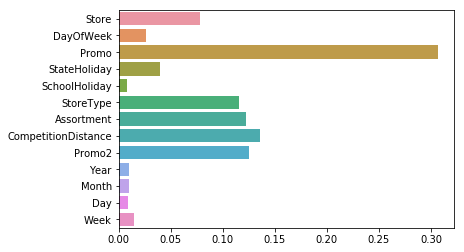

In [112]:
# 特征重要性
sb.barplot(x=xgb.feature_importances_, y=test_set_X.columns.values)

In [163]:
# 测试集预测
test_xgb_pred = np.exp(xgb.predict(np.array(test_set_X)))

In [165]:
# 整理提交格式
test_df_open = test_df[test_df.Open==1].reset_index().join(pd.DataFrame({'Sales':test_xgb_pred}), how='left')[['Id','Sales']]
test_submission = test_df.copy()
test_submission = pd.merge(test_submission, test_df_open, how='left', on='Id')[['Id','Sales']]
test_submission.loc[test_submission['Sales'].isnull(), 'Sales'] = 0
test_submission['Sales'] = test_submission['Sales'].astype(int)
test_submission = test_submission.sort_values('Id')
test_submission.to_csv('submission_xgb_1.csv', index=False)
print("Predictions saved to predictions/xgboost-log-1.csv")

Predictions saved to predictions/xgboost-log-1.csv


### 模型1-1 （与模型1一样，只是重新运行提取测试集的预测结果）

In [92]:
# 训练模型
xgb = XGBRegressor(n_estimators=3000, nthread=-1, max_depth=10, 
                   learning_rate=0.03, silent=1, subsample=0.9, colsampple_bytree=0.5)
start = datetime.now()
xgb.fit(np.array(train_set_X), train_set_y)
end = datetime.now()
print(end-start)

1:49:35.293085


In [93]:
# 保存模型
with open("models/xgboost-log-1-1.pkl", "wb") as fid:
    pickle.dump(xgb, fid)
print('Model saved to models/xgboost-log-1-1.pkl')

Model saved to models/xgboost-log-1-1.pkl


In [94]:
# 训练集和测试集的RMSPE
train_pred_log = xgb.predict(np.array(train_set_X))
print(rmspe_score(train_set_y.values,train_pred_log))
valid_pred_log = xgb.predict(np.array(valid_set_X))
print(rmspe_score(valid_set_y, valid_pred_log))

0.00692244291298
0.0138268707646


In [97]:
train_pred = np.exp(train_pred_log)
valid_pred = np.exp(valid_pred_log)
print(rmspe_score(np.exp(train_set_y.values), train_pred))
print(rmspe_score(np.exp(valid_set_y.values), valid_pred))

0.0613486309878
0.129339751073


In [99]:
# 保存valid预测结果
valid_result_df = pd.DataFrame(data={"Sales": valid_pred, "True": np.exp(valid_set_y.values)})
valid_result_df.to_csv('valid_prediction/valid-1-1.csv', index=False)

In [ ]:
# 特征重要性
sb.barplot(x=xgb.feature_importances_, y=test_set_X.columns.values)

In [100]:
# 测试集预测
test_xgb_pred = np.exp(xgb.predict(np.array(test_set_X)))

In [101]:
# 整理提交格式
test_df_open = test_df[test_df.Open==1].reset_index().join(pd.DataFrame({'Sales':test_xgb_pred}), how='left')[['Id','Sales']]
test_submission = test_df.copy()
test_submission = pd.merge(test_submission, test_df_open, how='left', on='Id')[['Id','Sales']]
test_submission.loc[test_submission['Sales'].isnull(), 'Sales'] = 0
test_submission['Sales'] = test_submission['Sales'].astype(int)
test_submission = test_submission.sort_values('Id')
test_submission.to_csv('submission_xgb_1_1.csv', index=False)
print("Predictions saved to predictions/xgboost-log-1-1.csv")

Predictions saved to predictions/xgboost-log-1-1.csv


### 模型2：
特征 - 'logSales', 'Store', 'DayOfWeek', 'Promo', 'SchoolHoliday',
       'CompetitionDistance', 'CompetitionForMonth', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'Promo2ForMonth',
       'IsPromoMonth', 'Year', 'Month', 'Day', 'Week', 'StoreType_1',
       'StoreType_2', 'StoreType_3', 'StoreType_4', 'Assortment_1',
       'Assortment_2', 'Assortment_3', 'StateHoliday_0', 'StateHoliday_1'

In [240]:
xgb = XGBRegressor(n_estimators=3000, nthread=-1, max_depth=10, 
                   learning_rate=0.03, silent=1, subsample=0.9, colsampple_bytree=0.5)

In [241]:
start = datetime.now()
xgb.fit(np.array(train_set_X), train_set_y)
end = datetime.now()
print(end-start)

2:13:30.959871


In [242]:
with open("models/xgboost-log-2.pkl", "wb") as fid:
    pickle.dump(xgb, fid)
print('Model saved to models/xgboost-log-2.pkl')

Model saved to models/xgboost-log-2.pkl


In [118]:
# xgb_1 = pd.read_pickle('models/xgboost-log-2.pkl')

In [246]:
train_pred_log = xgb.predict(np.array(train_set_X))
valid_pred_log = xgb.predict(np.array(valid_set_X))
print(rmspe_score(train_set_y.values, train_pred_log))
print(rmspe_score(valid_set_y.values, valid_pred_log))

0.00621661238137
0.0141446712688


In [245]:
train_pred = np.exp(train_pred_log)
valid_pred = np.exp(valid_pred_log)
print(rmspe_score(np.exp(train_set_y.values), train_pred))
print(rmspe_score(np.exp(valid_set_y.values), valid_pred))

0.0544942435864
0.131735778711


In [262]:
# 保存验证集预测结果
valid_result_df = pd.DataFrame(data={"Sales": valid_pred, "True": np.exp(valid_set_y.values)})
valid_result_df.to_csv('valid_prediction/valid-2.csv', index=False)

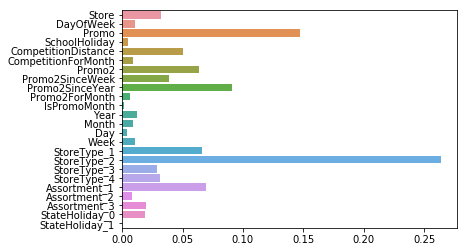

In [260]:
# 特征重要性
sb.barplot(x=xgb.feature_importances_, y=test_set_X.columns.values)

In [ ]:
# 测试集预测
test_xgb_pred = np.exp(xgb.predict(np.array(test_set_X)))

# 整理提交格式
test_df_open = test_df[test_df.Open==1].reset_index().join(pd.DataFrame({'Sales':test_xgb_pred}), how='left')[['Id','Sales']]
test_submission = test_df.copy()
test_submission = pd.merge(test_submission, test_df_open, how='left', on='Id')[['Id','Sales']]
test_submission.loc[test_submission['Sales'].isnull(), 'Sales'] = 0
test_submission['Sales'] = test_submission['Sales'].astype(int)
test_submission = test_submission.sort_values('Id')
test_submission.to_csv('submission_xgb_2.csv', index=False)
print("Predictions saved to predictions/xgboost-log-2.csv")

### 模型3

In [114]:
# 训练模型
xgb = XGBRegressor(n_estimators=3000, nthread=-1, max_depth=10, 
                   learning_rate=0.03, silent=1, subsample=0.9, colsampple_bytree=0.5)
start = datetime.now()
xgb.fit(np.array(train_set_X), train_set_y)
end = datetime.now()
print(end-start)

1:21:25.419541


In [115]:
# 保存模型
with open("models/xgboost-log-3.pkl", "wb") as fid:
    pickle.dump(xgb, fid)
print('Model saved to models/xgboost-log-3.pkl')

Model saved to models/xgboost-log-3.pkl


In [263]:
# xgb = pd.read_pickle('models/xgboost-log-3.pkl')

In [349]:
# 训练集和测试集的RMSPE
train_xgb_pred = xgb.predict(np.array(train_set_X))
print(rmspe_score(train_set_y.values,train_xgb_pred))
valid_xgb_pred = xgb.predict(np.array(valid_set_X))
print(rmspe_score(valid_set_y, valid_xgb_pred))

0.0142565753509
0.0181815625509


In [359]:
# 还原原始销售
train_pred = np.exp(train_xgb_pred)
valid_pred = np.exp(valid_xgb_pred)
print(rmspe_score(np.exp(train_set_y.values), train_pred))
print(rmspe_score(np.exp(valid_set_y.values), valid_pred))

0.149874802463
0.172292983997


In [360]:
# 保存验证集预测结果
valid_result_df = pd.DataFrame(data={"Sales": valid_pred, "True": np.exp(valid_set_y.values)})
valid_result_df.to_csv('valid_prediction/valid-3.csv', index=False)

In [ ]:
# 特征重要性
sb.barplot(x=xgb.feature_importances_, y=test_set_X.columns.values)

In [129]:
# 测试集预测
test_xgb_pred = np.expm1(xgb.predict(np.array(test_set_X)))

In [130]:
# 整理提交格式
test_df_open = test_df[test_df.Open==1].reset_index().join(pd.DataFrame({'Sales':test_xgb_pred}), how='left')[['Id','Sales']]
test_submission = test_df.copy()
test_submission = pd.merge(test_submission, test_df_open, how='left', on='Id')[['Id','Sales']]
test_submission.loc[test_submission['Sales'].isnull(), 'Sales'] = 0
test_submission['Sales'] = test_submission['Sales'].astype(int)
test_submission = test_submission.sort_values('Id')
test_submission.to_csv('submission_xgb_3.csv', index=False)
print("Predictions saved to predictions/xgboost-log-3.csv")

Predictions saved to predictions/xgboost-log-3.csv


### 模型4 （出错）

### 模型5

In [346]:
params = {'objective': 'reg:linear',
          'booster': 'gbtree',
          'eta': 0.03, 
          'max_depth': 10, 
          'subsample': 0.9, 
          'colsample_bytree': 0.5, 
          'silent':1, 
          'seed': 17
         }
num_boost_round = 3000
dtrain = xgb.DMatrix(train_set_X, train_set_y)
dvalid = xgb.DMatrix(valid_set_X, valid_set_y)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, 
                early_stopping_rounds=100, feval=rmspe_score_xg, 
                verbose_eval=True)

[0]	train-rmse:8.01873	eval-rmse:8.03352	train-rmspe:0.999808	eval-rmspe:0.999812
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.7783	eval-rmse:7.79316	train-rmspe:0.999711	eval-rmspe:0.999717
[2]	train-rmse:7.54514	eval-rmse:7.56032	train-rmspe:0.999592	eval-rmspe:0.9996
[3]	train-rmse:7.31904	eval-rmse:7.33431	train-rmspe:0.999447	eval-rmspe:0.999458
[4]	train-rmse:7.09959	eval-rmse:7.11496	train-rmspe:0.999273	eval-rmspe:0.999287
[5]	train-rmse:6.88682	eval-rmse:6.90257	train-rmspe:0.999063	eval-rmspe:0.999082
[6]	train-rmse:6.68037	eval-rmse:6.69623	train-rmspe:0.998813	eval-rmspe:0.998837
[7]	train-rmse:6.48019	eval-rmse:6.49637	train-rmspe:0.998517	eval-rmspe:0.998547
[8]	train-rmse:6.28593	eval-rmse:6.3023	train-rmspe:0.998168	eval-rmspe:0.998205
[9]	train-rmse:6.09755	eval-rmse:6.11395	train-rmspe:0.997759	eval-rmspe:0.997805
[10]	train-rmse:5.91484	eval-rmse:5.93

[97]	train-rmse:0.437526	eval-rmse:0.443819	train-rmspe:0.355377	eval-rmspe:0.350767
[98]	train-rmse:0.425362	eval-rmse:0.431754	train-rmspe:0.3479	eval-rmspe:0.343002
[99]	train-rmse:0.413688	eval-rmse:0.420133	train-rmspe:0.340627	eval-rmspe:0.33542
[100]	train-rmse:0.402337	eval-rmse:0.408688	train-rmspe:0.333499	eval-rmspe:0.327881
[101]	train-rmse:0.391378	eval-rmse:0.397922	train-rmspe:0.326589	eval-rmspe:0.320719
[102]	train-rmse:0.380704	eval-rmse:0.387247	train-rmspe:0.319827	eval-rmspe:0.313546
[103]	train-rmse:0.370496	eval-rmse:0.37711	train-rmspe:0.313292	eval-rmspe:0.306655
[104]	train-rmse:0.360515	eval-rmse:0.367305	train-rmspe:0.306777	eval-rmspe:0.299949
[105]	train-rmse:0.350914	eval-rmse:0.357468	train-rmspe:0.300557	eval-rmspe:0.293144
[106]	train-rmse:0.341608	eval-rmse:0.348112	train-rmspe:0.294505	eval-rmspe:0.286631
[107]	train-rmse:0.332598	eval-rmse:0.339323	train-rmspe:0.288632	eval-rmspe:0.280465
[108]	train-rmse:0.323905	eval-rmse:0.330431	train-rmspe:0.28

[193]	train-rmse:0.106437	eval-rmse:0.12245	train-rmspe:0.130203	eval-rmspe:0.125138
[194]	train-rmse:0.106137	eval-rmse:0.122193	train-rmspe:0.130028	eval-rmspe:0.125027
[195]	train-rmse:0.105865	eval-rmse:0.12204	train-rmspe:0.129892	eval-rmspe:0.124993
[196]	train-rmse:0.10552	eval-rmse:0.12193	train-rmspe:0.129624	eval-rmspe:0.125063
[197]	train-rmse:0.1053	eval-rmse:0.121782	train-rmspe:0.129029	eval-rmspe:0.125031
[198]	train-rmse:0.105112	eval-rmse:0.121702	train-rmspe:0.128969	eval-rmspe:0.125068
[199]	train-rmse:0.104859	eval-rmse:0.121618	train-rmspe:0.128822	eval-rmspe:0.125085
[200]	train-rmse:0.104599	eval-rmse:0.121485	train-rmspe:0.128682	eval-rmspe:0.125042
[201]	train-rmse:0.104376	eval-rmse:0.121368	train-rmspe:0.128577	eval-rmspe:0.125013
[202]	train-rmse:0.104147	eval-rmse:0.121172	train-rmspe:0.128462	eval-rmspe:0.125016
[203]	train-rmse:0.103908	eval-rmse:0.121017	train-rmspe:0.127966	eval-rmspe:0.124968
[204]	train-rmse:0.103749	eval-rmse:0.120949	train-rmspe:0.1

[289]	train-rmse:0.094489	eval-rmse:0.115917	train-rmspe:0.112859	eval-rmspe:0.12288
[290]	train-rmse:0.094398	eval-rmse:0.115866	train-rmspe:0.112772	eval-rmspe:0.122834
[291]	train-rmse:0.094322	eval-rmse:0.115844	train-rmspe:0.112674	eval-rmspe:0.122838
[292]	train-rmse:0.094259	eval-rmse:0.115804	train-rmspe:0.112619	eval-rmspe:0.122817
[293]	train-rmse:0.094186	eval-rmse:0.115751	train-rmspe:0.112551	eval-rmspe:0.122771
[294]	train-rmse:0.094129	eval-rmse:0.115713	train-rmspe:0.112492	eval-rmspe:0.12274
[295]	train-rmse:0.094025	eval-rmse:0.115655	train-rmspe:0.112366	eval-rmspe:0.122703
[296]	train-rmse:0.093926	eval-rmse:0.115571	train-rmspe:0.112265	eval-rmspe:0.122628
[297]	train-rmse:0.093841	eval-rmse:0.115514	train-rmspe:0.112173	eval-rmspe:0.122545
[298]	train-rmse:0.093737	eval-rmse:0.11545	train-rmspe:0.112093	eval-rmspe:0.122488
[299]	train-rmse:0.09367	eval-rmse:0.115427	train-rmspe:0.112026	eval-rmspe:0.122486
[300]	train-rmse:0.093609	eval-rmse:0.115448	train-rmspe:0

[385]	train-rmse:0.089151	eval-rmse:0.113518	train-rmspe:0.104247	eval-rmspe:0.120962
[386]	train-rmse:0.089124	eval-rmse:0.113515	train-rmspe:0.104191	eval-rmspe:0.120951
[387]	train-rmse:0.089078	eval-rmse:0.113526	train-rmspe:0.104124	eval-rmspe:0.120965
[388]	train-rmse:0.089026	eval-rmse:0.113471	train-rmspe:0.103991	eval-rmspe:0.120904
[389]	train-rmse:0.088998	eval-rmse:0.1135	train-rmspe:0.103964	eval-rmspe:0.120938
[390]	train-rmse:0.088977	eval-rmse:0.113485	train-rmspe:0.103942	eval-rmspe:0.120923
[391]	train-rmse:0.08895	eval-rmse:0.113466	train-rmspe:0.103916	eval-rmspe:0.120908
[392]	train-rmse:0.08892	eval-rmse:0.113472	train-rmspe:0.103886	eval-rmspe:0.120926
[393]	train-rmse:0.08887	eval-rmse:0.113457	train-rmspe:0.10384	eval-rmspe:0.12092
[394]	train-rmse:0.088829	eval-rmse:0.113449	train-rmspe:0.103675	eval-rmspe:0.120915
[395]	train-rmse:0.088785	eval-rmse:0.113422	train-rmspe:0.103634	eval-rmspe:0.120892
[396]	train-rmse:0.088751	eval-rmse:0.11339	train-rmspe:0.103

[481]	train-rmse:0.085829	eval-rmse:0.112167	train-rmspe:0.09843	eval-rmspe:0.119682
[482]	train-rmse:0.085788	eval-rmse:0.112188	train-rmspe:0.098395	eval-rmspe:0.119699
[483]	train-rmse:0.085776	eval-rmse:0.112168	train-rmspe:0.098383	eval-rmspe:0.119678
[484]	train-rmse:0.085742	eval-rmse:0.11216	train-rmspe:0.098349	eval-rmspe:0.119667
[485]	train-rmse:0.085709	eval-rmse:0.112153	train-rmspe:0.098272	eval-rmspe:0.119663
[486]	train-rmse:0.085664	eval-rmse:0.112104	train-rmspe:0.098225	eval-rmspe:0.119613
[487]	train-rmse:0.085637	eval-rmse:0.112088	train-rmspe:0.098194	eval-rmspe:0.119596
[488]	train-rmse:0.08562	eval-rmse:0.11208	train-rmspe:0.098178	eval-rmspe:0.119589
[489]	train-rmse:0.085581	eval-rmse:0.112088	train-rmspe:0.098142	eval-rmspe:0.119608
[490]	train-rmse:0.085537	eval-rmse:0.112075	train-rmspe:0.09809	eval-rmspe:0.119596
[491]	train-rmse:0.085507	eval-rmse:0.112045	train-rmspe:0.098055	eval-rmspe:0.119549
[492]	train-rmse:0.085468	eval-rmse:0.11202	train-rmspe:0.0

[577]	train-rmse:0.083092	eval-rmse:0.111079	train-rmspe:0.093256	eval-rmspe:0.118557
[578]	train-rmse:0.08307	eval-rmse:0.111073	train-rmspe:0.093227	eval-rmspe:0.118554
[579]	train-rmse:0.083055	eval-rmse:0.111064	train-rmspe:0.093212	eval-rmspe:0.118544
[580]	train-rmse:0.083031	eval-rmse:0.111074	train-rmspe:0.09318	eval-rmspe:0.118553
[581]	train-rmse:0.083003	eval-rmse:0.111061	train-rmspe:0.093151	eval-rmspe:0.118541
[582]	train-rmse:0.08297	eval-rmse:0.111077	train-rmspe:0.093121	eval-rmspe:0.118558
[583]	train-rmse:0.08296	eval-rmse:0.111076	train-rmspe:0.093108	eval-rmspe:0.118556
[584]	train-rmse:0.082951	eval-rmse:0.111071	train-rmspe:0.093097	eval-rmspe:0.118552
[585]	train-rmse:0.082917	eval-rmse:0.111051	train-rmspe:0.093033	eval-rmspe:0.118529
[586]	train-rmse:0.082884	eval-rmse:0.111042	train-rmspe:0.093	eval-rmspe:0.11852
[587]	train-rmse:0.082845	eval-rmse:0.111043	train-rmspe:0.092922	eval-rmspe:0.11852
[588]	train-rmse:0.082809	eval-rmse:0.111032	train-rmspe:0.0928

[673]	train-rmse:0.080836	eval-rmse:0.1107	train-rmspe:0.089859	eval-rmspe:0.118037
[674]	train-rmse:0.080815	eval-rmse:0.110694	train-rmspe:0.08984	eval-rmspe:0.11803
[675]	train-rmse:0.080796	eval-rmse:0.110677	train-rmspe:0.08982	eval-rmspe:0.118011
[676]	train-rmse:0.080757	eval-rmse:0.110667	train-rmspe:0.089777	eval-rmspe:0.117997
[677]	train-rmse:0.080735	eval-rmse:0.110644	train-rmspe:0.08975	eval-rmspe:0.117968
[678]	train-rmse:0.080722	eval-rmse:0.11064	train-rmspe:0.089736	eval-rmspe:0.117967
[679]	train-rmse:0.080702	eval-rmse:0.110633	train-rmspe:0.089715	eval-rmspe:0.117959
[680]	train-rmse:0.080683	eval-rmse:0.110626	train-rmspe:0.089694	eval-rmspe:0.117949
[681]	train-rmse:0.080649	eval-rmse:0.1106	train-rmspe:0.089652	eval-rmspe:0.117923
[682]	train-rmse:0.080618	eval-rmse:0.110593	train-rmspe:0.08959	eval-rmspe:0.117918
[683]	train-rmse:0.080594	eval-rmse:0.110582	train-rmspe:0.089558	eval-rmspe:0.11791
[684]	train-rmse:0.080559	eval-rmse:0.110614	train-rmspe:0.089501

[769]	train-rmse:0.078969	eval-rmse:0.110176	train-rmspe:0.087313	eval-rmspe:0.117584
[770]	train-rmse:0.078952	eval-rmse:0.110175	train-rmspe:0.087298	eval-rmspe:0.117584
[771]	train-rmse:0.078945	eval-rmse:0.11016	train-rmspe:0.087291	eval-rmspe:0.11757
[772]	train-rmse:0.078929	eval-rmse:0.110147	train-rmspe:0.087274	eval-rmspe:0.117571
[773]	train-rmse:0.078914	eval-rmse:0.110141	train-rmspe:0.087251	eval-rmspe:0.117567
[774]	train-rmse:0.078895	eval-rmse:0.110148	train-rmspe:0.087231	eval-rmspe:0.117572
[775]	train-rmse:0.078866	eval-rmse:0.110144	train-rmspe:0.087187	eval-rmspe:0.11757
[776]	train-rmse:0.078861	eval-rmse:0.110142	train-rmspe:0.087182	eval-rmspe:0.117569
[777]	train-rmse:0.078833	eval-rmse:0.110123	train-rmspe:0.087156	eval-rmspe:0.117548
[778]	train-rmse:0.078817	eval-rmse:0.110122	train-rmspe:0.08714	eval-rmspe:0.117548
[779]	train-rmse:0.07879	eval-rmse:0.110107	train-rmspe:0.087115	eval-rmspe:0.117533
[780]	train-rmse:0.078782	eval-rmse:0.110107	train-rmspe:0.

[865]	train-rmse:0.077267	eval-rmse:0.10985	train-rmspe:0.085206	eval-rmspe:0.117236
[866]	train-rmse:0.077248	eval-rmse:0.109857	train-rmspe:0.085178	eval-rmspe:0.117238
[867]	train-rmse:0.077234	eval-rmse:0.109841	train-rmspe:0.085165	eval-rmspe:0.117227
[868]	train-rmse:0.077224	eval-rmse:0.109841	train-rmspe:0.085152	eval-rmspe:0.117224
[869]	train-rmse:0.077203	eval-rmse:0.109842	train-rmspe:0.085129	eval-rmspe:0.117223
[870]	train-rmse:0.077186	eval-rmse:0.109852	train-rmspe:0.085112	eval-rmspe:0.117233
[871]	train-rmse:0.077173	eval-rmse:0.109848	train-rmspe:0.085093	eval-rmspe:0.11723
[872]	train-rmse:0.077141	eval-rmse:0.109845	train-rmspe:0.085042	eval-rmspe:0.117225
[873]	train-rmse:0.077124	eval-rmse:0.109832	train-rmspe:0.085021	eval-rmspe:0.117214
[874]	train-rmse:0.077109	eval-rmse:0.109827	train-rmspe:0.084993	eval-rmspe:0.117211
[875]	train-rmse:0.077089	eval-rmse:0.109827	train-rmspe:0.084886	eval-rmspe:0.117212
[876]	train-rmse:0.077069	eval-rmse:0.109817	train-rmspe

[961]	train-rmse:0.075645	eval-rmse:0.109576	train-rmspe:0.082656	eval-rmspe:0.117001
[962]	train-rmse:0.075638	eval-rmse:0.109575	train-rmspe:0.082645	eval-rmspe:0.117
[963]	train-rmse:0.075634	eval-rmse:0.109575	train-rmspe:0.082641	eval-rmspe:0.117001
[964]	train-rmse:0.075624	eval-rmse:0.109603	train-rmspe:0.082629	eval-rmspe:0.117019
[965]	train-rmse:0.0756	eval-rmse:0.10961	train-rmspe:0.082483	eval-rmspe:0.117027
[966]	train-rmse:0.075583	eval-rmse:0.109611	train-rmspe:0.082462	eval-rmspe:0.117028
[967]	train-rmse:0.07556	eval-rmse:0.109607	train-rmspe:0.08243	eval-rmspe:0.117026
[968]	train-rmse:0.075553	eval-rmse:0.109608	train-rmspe:0.082423	eval-rmspe:0.117028
[969]	train-rmse:0.07553	eval-rmse:0.109604	train-rmspe:0.082401	eval-rmspe:0.117022
[970]	train-rmse:0.075522	eval-rmse:0.109602	train-rmspe:0.082393	eval-rmspe:0.117019
[971]	train-rmse:0.075512	eval-rmse:0.109598	train-rmspe:0.082375	eval-rmspe:0.117015
[972]	train-rmse:0.075498	eval-rmse:0.109599	train-rmspe:0.0823

[1057]	train-rmse:0.074173	eval-rmse:0.109532	train-rmspe:0.080555	eval-rmspe:0.117044
[1058]	train-rmse:0.074155	eval-rmse:0.10953	train-rmspe:0.080537	eval-rmspe:0.117042
Stopping. Best iteration:
[958]	train-rmse:0.075698	eval-rmse:0.109567	train-rmspe:0.082713	eval-rmspe:0.11699



In [356]:
gbm.save_model('xgb-log-5.model')
dtest = xgb.DMatrix(test_set_X)
dtest.save_binary('dtest-xg-5.buffer')

In [104]:
# gbm = xgb.Booster({'nthread':4})
# gbm.load_model('xgb-log-5.model')

In [141]:
# dtrain = xgb.DMatrix(train_set_X, train_set_y)
# dvalid = xgb.DMatrix(valid_set_X, valid_set_y)

In [145]:
train_log_pred = gbm.predict(dtrain)
valid_log_pred = gbm.predict(dvalid)
print(rmspe_score(train_set_y.values, train_log_pred))
print(rmspe_score(valid_set_y.values, valid_log_pred))

0.0107621952199
0.0136773102911


In [146]:
train_pred = np.exp(train_log_pred)
valid_pred = np.exp(valid_log_pred)
print(rmspe_score(np.exp(train_set_y.values), train_pred))
print(rmspe_score(np.exp(valid_set_y.values), valid_pred))

0.155097719234
0.125119288685


In [147]:
# 保存验证集预测值
valid_result_df = pd.DataFrame(data={"Sales": valid_pred, "True": np.exp(valid_set_y.values)})
valid_result_df.to_csv('valid_prediction/valid-5.csv', index=False)

In [357]:
dtest = xgb.DMatrix(test_set_X)
test_xgb_pred = np.exp(gbm.predict(dtest))

In [359]:
# 整理提交格式
test_df_open = test_df[test_df.Open==1].reset_index().join(pd.DataFrame({'Sales':test_xgb_pred}), how='left')[['Id','Sales']]
test_submission = test_df.copy()
test_submission = pd.merge(test_submission, test_df_open, how='left', on='Id')[['Id','Sales']]
test_submission.loc[test_submission['Sales'].isnull(), 'Sales'] = 0
test_submission['Sales'] = test_submission['Sales'].astype(int)
test_submission = test_submission.sort_values('Id')
test_submission.to_csv('submission_xgb_5.csv', index=False)
print("Predictions saved to predictions/xgboost-log-5.csv")

Predictions saved to predictions/xgboost-log-5.csv


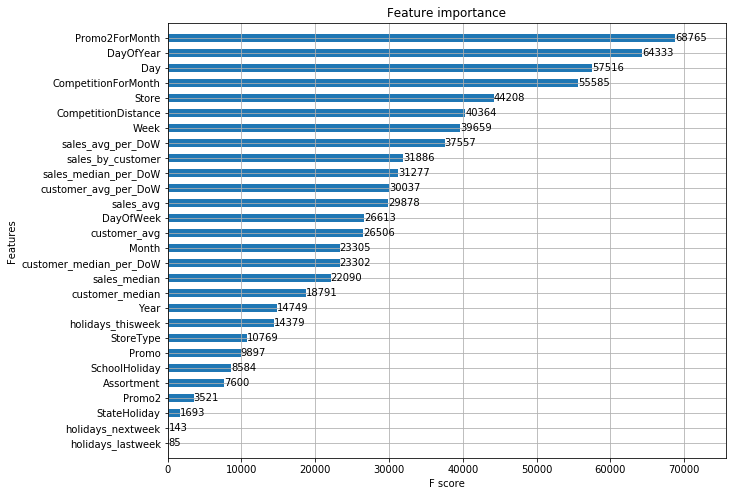

In [366]:
### plot feature importance
fig,ax = plt.subplots(figsize=(10,8))
plot_importance(gbm,height=0.5,ax=ax,max_num_features=64)
plt.show()

In [578]:
# fig, ax = plt.subplots(figsize=(15,10))
# ax = sb.heatmap(train_normalized.corr());

### 模型6

与特征5相同，训练集从2013-6-16 到 2013-9-30，2014-6-30到2014-9-30，验证集2015-6-16-2015-7-30

In [457]:
params = {'objective': 'reg:linear',
          'booster': 'gbtree',
          'eta': 0.03, 
          'max_depth': 10, 
          'subsample': 0.9, 
          'colsample_bytree': 0.5, 
          'silent':1, 
          'seed': 17
         }
num_boost_round = 3000
dtrain = xgb.DMatrix(train_set_X, train_set_y)
dvalid = xgb.DMatrix(valid_set_X, valid_set_y)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, 
                early_stopping_rounds=100, feval=rmspe_score_xg, 
                verbose_eval=True)

[0]	train-rmse:7.9969	eval-rmse:8.04233	train-rmspe:0.999806	eval-rmspe:0.999815
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.75717	eval-rmse:7.80255	train-rmspe:0.999707	eval-rmspe:0.999721
[2]	train-rmse:7.52461	eval-rmse:7.56995	train-rmspe:0.999587	eval-rmspe:0.999607
[3]	train-rmse:7.29905	eval-rmse:7.34423	train-rmspe:0.99944	eval-rmspe:0.999467
[4]	train-rmse:7.08027	eval-rmse:7.12561	train-rmspe:0.999263	eval-rmspe:0.999299
[5]	train-rmse:6.86807	eval-rmse:6.91353	train-rmspe:0.999051	eval-rmspe:0.999097
[6]	train-rmse:6.66222	eval-rmse:6.70781	train-rmspe:0.998798	eval-rmspe:0.998856
[7]	train-rmse:6.46256	eval-rmse:6.50828	train-rmspe:0.998498	eval-rmspe:0.99857
[8]	train-rmse:6.26885	eval-rmse:6.31437	train-rmspe:0.998146	eval-rmspe:0.998234
[9]	train-rmse:6.08094	eval-rmse:6.12644	train-rmspe:0.997733	eval-rmspe:0.997841
[10]	train-rmse:5.89865	eval-rmse:5.9

[97]	train-rmse:0.433873	eval-rmse:0.469693	train-rmspe:0.347235	eval-rmspe:0.367693
[98]	train-rmse:0.421731	eval-rmse:0.457526	train-rmspe:0.33939	eval-rmspe:0.360021
[99]	train-rmse:0.409996	eval-rmse:0.445835	train-rmspe:0.331718	eval-rmspe:0.352556
[100]	train-rmse:0.398649	eval-rmse:0.434458	train-rmspe:0.324218	eval-rmspe:0.345216
[101]	train-rmse:0.387658	eval-rmse:0.42354	train-rmspe:0.316886	eval-rmspe:0.338097
[102]	train-rmse:0.377023	eval-rmse:0.413014	train-rmspe:0.309683	eval-rmspe:0.331163
[103]	train-rmse:0.366694	eval-rmse:0.402587	train-rmspe:0.302668	eval-rmspe:0.324222
[104]	train-rmse:0.356682	eval-rmse:0.392653	train-rmspe:0.295797	eval-rmspe:0.317553
[105]	train-rmse:0.346976	eval-rmse:0.383037	train-rmspe:0.289097	eval-rmspe:0.311046
[106]	train-rmse:0.337596	eval-rmse:0.373618	train-rmspe:0.282564	eval-rmspe:0.304618
[107]	train-rmse:0.328541	eval-rmse:0.364615	train-rmspe:0.276194	eval-rmspe:0.298408
[108]	train-rmse:0.319813	eval-rmse:0.355884	train-rmspe:0.

[193]	train-rmse:0.095196	eval-rmse:0.134915	train-rmspe:0.100033	eval-rmspe:0.130167
[194]	train-rmse:0.094907	eval-rmse:0.134645	train-rmspe:0.099781	eval-rmspe:0.130012
[195]	train-rmse:0.094624	eval-rmse:0.134363	train-rmspe:0.099618	eval-rmspe:0.129849
[196]	train-rmse:0.094351	eval-rmse:0.134111	train-rmspe:0.09943	eval-rmspe:0.129723
[197]	train-rmse:0.094052	eval-rmse:0.133845	train-rmspe:0.099239	eval-rmspe:0.129587
[198]	train-rmse:0.093798	eval-rmse:0.133609	train-rmspe:0.099088	eval-rmspe:0.129459
[199]	train-rmse:0.093553	eval-rmse:0.133389	train-rmspe:0.098914	eval-rmspe:0.129348
[200]	train-rmse:0.093331	eval-rmse:0.133182	train-rmspe:0.098727	eval-rmspe:0.129245
[201]	train-rmse:0.093077	eval-rmse:0.13293	train-rmspe:0.098542	eval-rmspe:0.129098
[202]	train-rmse:0.092818	eval-rmse:0.132753	train-rmspe:0.098311	eval-rmspe:0.128994
[203]	train-rmse:0.092589	eval-rmse:0.132562	train-rmspe:0.098183	eval-rmspe:0.128898
[204]	train-rmse:0.092342	eval-rmse:0.132347	train-rmspe

[289]	train-rmse:0.082178	eval-rmse:0.127059	train-rmspe:0.087456	eval-rmspe:0.126415
[290]	train-rmse:0.082088	eval-rmse:0.127036	train-rmspe:0.087377	eval-rmspe:0.126404
[291]	train-rmse:0.082025	eval-rmse:0.127035	train-rmspe:0.087325	eval-rmspe:0.126416
[292]	train-rmse:0.081945	eval-rmse:0.12699	train-rmspe:0.087253	eval-rmspe:0.126385
[293]	train-rmse:0.08184	eval-rmse:0.126969	train-rmspe:0.08716	eval-rmspe:0.126383
[294]	train-rmse:0.081798	eval-rmse:0.126964	train-rmspe:0.087126	eval-rmspe:0.126383
[295]	train-rmse:0.081741	eval-rmse:0.126946	train-rmspe:0.087015	eval-rmspe:0.126374
[296]	train-rmse:0.081661	eval-rmse:0.126944	train-rmspe:0.08694	eval-rmspe:0.126386
[297]	train-rmse:0.08163	eval-rmse:0.126919	train-rmspe:0.086916	eval-rmspe:0.12637
[298]	train-rmse:0.081514	eval-rmse:0.126892	train-rmspe:0.086805	eval-rmspe:0.126354
[299]	train-rmse:0.081421	eval-rmse:0.126874	train-rmspe:0.086719	eval-rmspe:0.126339
[300]	train-rmse:0.081311	eval-rmse:0.126841	train-rmspe:0.0

[385]	train-rmse:0.076573	eval-rmse:0.126542	train-rmspe:0.080641	eval-rmspe:0.126187
[386]	train-rmse:0.076537	eval-rmse:0.126575	train-rmspe:0.08061	eval-rmspe:0.126197
[387]	train-rmse:0.076478	eval-rmse:0.126611	train-rmspe:0.080547	eval-rmspe:0.12623
[388]	train-rmse:0.076448	eval-rmse:0.126606	train-rmspe:0.080516	eval-rmspe:0.126225
[389]	train-rmse:0.076363	eval-rmse:0.126592	train-rmspe:0.080441	eval-rmspe:0.126218
[390]	train-rmse:0.076307	eval-rmse:0.126588	train-rmspe:0.080387	eval-rmspe:0.126212
[391]	train-rmse:0.076269	eval-rmse:0.126583	train-rmspe:0.080334	eval-rmspe:0.126207
[392]	train-rmse:0.076229	eval-rmse:0.126578	train-rmspe:0.080292	eval-rmspe:0.126202
[393]	train-rmse:0.07618	eval-rmse:0.126593	train-rmspe:0.080245	eval-rmspe:0.126213
[394]	train-rmse:0.076126	eval-rmse:0.126619	train-rmspe:0.080183	eval-rmspe:0.126236
[395]	train-rmse:0.076047	eval-rmse:0.126595	train-rmspe:0.080094	eval-rmspe:0.126214
[396]	train-rmse:0.076002	eval-rmse:0.126596	train-rmspe:

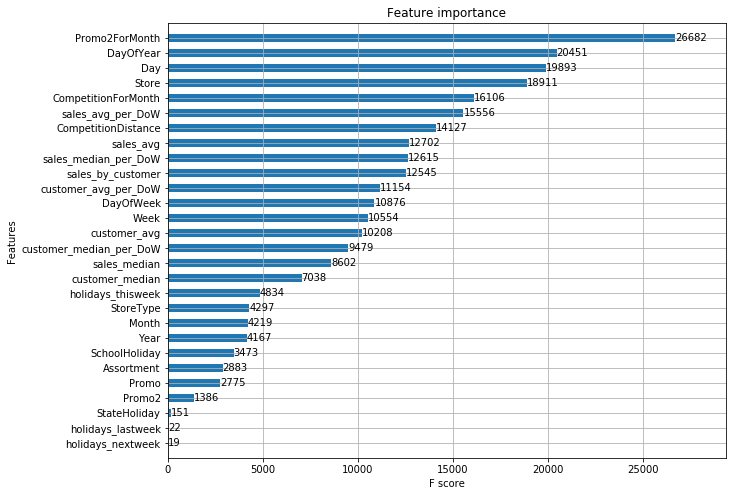

In [459]:
### plot feature importance
fig,ax = plt.subplots(figsize=(10,8))
plot_importance(gbm,height=0.5,ax=ax,max_num_features=64)
plt.show()

In [460]:
gbm.save_model('xgb-log-6.model')
dtest = xgb.DMatrix(test_set_X)
dtest.save_binary('dtest-xg-6.buffer')

In [461]:
test_xgb_pred = np.exp(gbm.predict(dtest))

In [462]:
# 整理提交格式
test_df_open = test_df[test_df.Open==1].reset_index().join(pd.DataFrame({'Sales':test_xgb_pred}), how='left')[['Id','Sales']]
test_submission = test_df.copy()
test_submission = pd.merge(test_submission, test_df_open, how='left', on='Id')[['Id','Sales']]
test_submission.loc[test_submission['Sales'].isnull(), 'Sales'] = 0
test_submission['Sales'] = test_submission['Sales'].astype(int)
test_submission = test_submission.sort_values('Id')
test_submission.to_csv('submission_xgb_6.csv', index=False)
print("Predictions saved to predictions/xgboost-log-6.csv")

Predictions saved to predictions/xgboost-log-6.csv


### 模型7

In [541]:
params = {'objective': 'reg:linear',
          'booster': 'gbtree',
          'eta': 0.03, 
          'max_depth': 10, 
          'subsample': 0.9, 
          'colsample_bytree': 0.5, 
          'silent':1, 
          'seed': 17
         }
num_boost_round = 3000
dtrain = xgb.DMatrix(train_set_X, train_set_y)
dvalid = xgb.DMatrix(valid_set_X, valid_set_y)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, 
                early_stopping_rounds=100, feval=rmspe_score_xg, 
                verbose_eval=True)

[0]	train-rmse:8.01947	eval-rmse:8.04189	train-rmspe:0.999809	eval-rmspe:0.999815
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.77908	eval-rmse:7.80164	train-rmspe:0.999712	eval-rmspe:0.999721
[2]	train-rmse:7.54591	eval-rmse:7.56887	train-rmspe:0.999593	eval-rmspe:0.999606
[3]	train-rmse:7.31967	eval-rmse:7.3428	train-rmspe:0.999449	eval-rmspe:0.999466
[4]	train-rmse:7.1002	eval-rmse:7.12344	train-rmspe:0.999275	eval-rmspe:0.999297
[5]	train-rmse:6.8874	eval-rmse:6.91078	train-rmspe:0.999066	eval-rmspe:0.999094
[6]	train-rmse:6.68099	eval-rmse:6.70476	train-rmspe:0.998817	eval-rmspe:0.998852
[7]	train-rmse:6.48071	eval-rmse:6.50466	train-rmspe:0.998521	eval-rmspe:0.998565
[8]	train-rmse:6.28643	eval-rmse:6.31057	train-rmspe:0.998173	eval-rmspe:0.998228
[9]	train-rmse:6.09807	eval-rmse:6.12256	train-rmspe:0.997765	eval-rmspe:0.997831
[10]	train-rmse:5.91535	eval-rmse:5.9

[98]	train-rmse:0.426835	eval-rmse:0.440143	train-rmspe:0.354387	eval-rmspe:0.347918
[99]	train-rmse:0.415216	eval-rmse:0.428514	train-rmspe:0.34743	eval-rmspe:0.34036
[100]	train-rmse:0.403962	eval-rmse:0.416694	train-rmspe:0.340472	eval-rmspe:0.332576
[101]	train-rmse:0.3931	eval-rmse:0.405949	train-rmspe:0.333898	eval-rmspe:0.325445
[102]	train-rmse:0.382583	eval-rmse:0.395008	train-rmspe:0.327507	eval-rmspe:0.318113
[103]	train-rmse:0.372294	eval-rmse:0.384561	train-rmspe:0.321221	eval-rmspe:0.311069
[104]	train-rmse:0.362347	eval-rmse:0.374702	train-rmspe:0.314415	eval-rmspe:0.304355
[105]	train-rmse:0.352837	eval-rmse:0.365098	train-rmspe:0.308548	eval-rmspe:0.297732
[106]	train-rmse:0.343654	eval-rmse:0.355479	train-rmspe:0.302865	eval-rmspe:0.291046
[107]	train-rmse:0.334765	eval-rmse:0.346617	train-rmspe:0.297331	eval-rmspe:0.284838
[108]	train-rmse:0.326184	eval-rmse:0.338101	train-rmspe:0.291983	eval-rmspe:0.278824
[109]	train-rmse:0.317762	eval-rmse:0.329554	train-rmspe:0.2

[194]	train-rmse:0.114163	eval-rmse:0.129545	train-rmspe:0.15276	eval-rmspe:0.129519
[195]	train-rmse:0.113945	eval-rmse:0.129407	train-rmspe:0.152712	eval-rmspe:0.129524
[196]	train-rmse:0.113713	eval-rmse:0.129212	train-rmspe:0.152634	eval-rmspe:0.129459
[197]	train-rmse:0.113518	eval-rmse:0.129049	train-rmspe:0.152584	eval-rmspe:0.129425
[198]	train-rmse:0.113285	eval-rmse:0.12899	train-rmspe:0.152496	eval-rmspe:0.129474
[199]	train-rmse:0.113059	eval-rmse:0.128934	train-rmspe:0.152414	eval-rmspe:0.129532
[200]	train-rmse:0.112849	eval-rmse:0.128774	train-rmspe:0.152324	eval-rmspe:0.129479
[201]	train-rmse:0.112679	eval-rmse:0.128673	train-rmspe:0.152243	eval-rmspe:0.129487
[202]	train-rmse:0.112493	eval-rmse:0.128551	train-rmspe:0.152185	eval-rmspe:0.129482
[203]	train-rmse:0.112292	eval-rmse:0.128429	train-rmspe:0.152089	eval-rmspe:0.129451
[204]	train-rmse:0.112154	eval-rmse:0.128339	train-rmspe:0.150647	eval-rmspe:0.129459
[205]	train-rmse:0.111986	eval-rmse:0.128259	train-rmspe

[290]	train-rmse:0.103622	eval-rmse:0.123739	train-rmspe:0.135288	eval-rmspe:0.127567
[291]	train-rmse:0.103591	eval-rmse:0.123725	train-rmspe:0.135262	eval-rmspe:0.12756
[292]	train-rmse:0.103528	eval-rmse:0.123712	train-rmspe:0.135189	eval-rmspe:0.127555
[293]	train-rmse:0.103466	eval-rmse:0.123653	train-rmspe:0.134654	eval-rmspe:0.12752
[294]	train-rmse:0.103429	eval-rmse:0.123636	train-rmspe:0.134589	eval-rmspe:0.127514
[295]	train-rmse:0.103366	eval-rmse:0.123607	train-rmspe:0.134534	eval-rmspe:0.127491
[296]	train-rmse:0.103339	eval-rmse:0.123598	train-rmspe:0.134503	eval-rmspe:0.127488
[297]	train-rmse:0.10327	eval-rmse:0.123509	train-rmspe:0.134452	eval-rmspe:0.127411
[298]	train-rmse:0.103237	eval-rmse:0.123499	train-rmspe:0.134418	eval-rmspe:0.127403
[299]	train-rmse:0.103141	eval-rmse:0.123414	train-rmspe:0.134333	eval-rmspe:0.127334
[300]	train-rmse:0.103103	eval-rmse:0.123385	train-rmspe:0.134231	eval-rmspe:0.127319
[301]	train-rmse:0.103038	eval-rmse:0.123322	train-rmspe:

[386]	train-rmse:0.098429	eval-rmse:0.121022	train-rmspe:0.125696	eval-rmspe:0.125177
[387]	train-rmse:0.098401	eval-rmse:0.12097	train-rmspe:0.12567	eval-rmspe:0.125125
[388]	train-rmse:0.098369	eval-rmse:0.120932	train-rmspe:0.125646	eval-rmspe:0.125086
[389]	train-rmse:0.09831	eval-rmse:0.120866	train-rmspe:0.125593	eval-rmspe:0.125033
[390]	train-rmse:0.098273	eval-rmse:0.120813	train-rmspe:0.125558	eval-rmspe:0.124977
[391]	train-rmse:0.098216	eval-rmse:0.120771	train-rmspe:0.125492	eval-rmspe:0.124939
[392]	train-rmse:0.098144	eval-rmse:0.120721	train-rmspe:0.125425	eval-rmspe:0.124893
[393]	train-rmse:0.098109	eval-rmse:0.120693	train-rmspe:0.125394	eval-rmspe:0.124859
[394]	train-rmse:0.098093	eval-rmse:0.12069	train-rmspe:0.125378	eval-rmspe:0.124856
[395]	train-rmse:0.098042	eval-rmse:0.120661	train-rmspe:0.125327	eval-rmspe:0.124829
[396]	train-rmse:0.097989	eval-rmse:0.120693	train-rmspe:0.125147	eval-rmspe:0.124854
[397]	train-rmse:0.097936	eval-rmse:0.120641	train-rmspe:0

[482]	train-rmse:0.094842	eval-rmse:0.119068	train-rmspe:0.119626	eval-rmspe:0.123309
[483]	train-rmse:0.094781	eval-rmse:0.11903	train-rmspe:0.119572	eval-rmspe:0.123286
[484]	train-rmse:0.094732	eval-rmse:0.118995	train-rmspe:0.119513	eval-rmspe:0.123253
[485]	train-rmse:0.094704	eval-rmse:0.11896	train-rmspe:0.119486	eval-rmspe:0.123218
[486]	train-rmse:0.09466	eval-rmse:0.118924	train-rmspe:0.119447	eval-rmspe:0.123184
[487]	train-rmse:0.094631	eval-rmse:0.118905	train-rmspe:0.119423	eval-rmspe:0.123165
[488]	train-rmse:0.094617	eval-rmse:0.118897	train-rmspe:0.119412	eval-rmspe:0.123159
[489]	train-rmse:0.094595	eval-rmse:0.118881	train-rmspe:0.119289	eval-rmspe:0.12314
[490]	train-rmse:0.094563	eval-rmse:0.11886	train-rmspe:0.119255	eval-rmspe:0.123123
[491]	train-rmse:0.094519	eval-rmse:0.118828	train-rmspe:0.11916	eval-rmspe:0.123095
[492]	train-rmse:0.094488	eval-rmse:0.11879	train-rmspe:0.119126	eval-rmspe:0.123043
[493]	train-rmse:0.094461	eval-rmse:0.118792	train-rmspe:0.11

[578]	train-rmse:0.092262	eval-rmse:0.117588	train-rmspe:0.112984	eval-rmspe:0.121929
[579]	train-rmse:0.092234	eval-rmse:0.117582	train-rmspe:0.112956	eval-rmspe:0.121925
[580]	train-rmse:0.092219	eval-rmse:0.117579	train-rmspe:0.112929	eval-rmspe:0.121923
[581]	train-rmse:0.092204	eval-rmse:0.117579	train-rmspe:0.112892	eval-rmspe:0.121924
[582]	train-rmse:0.092171	eval-rmse:0.117582	train-rmspe:0.112801	eval-rmspe:0.121932
[583]	train-rmse:0.092164	eval-rmse:0.117583	train-rmspe:0.112795	eval-rmspe:0.121931
[584]	train-rmse:0.092119	eval-rmse:0.117592	train-rmspe:0.11275	eval-rmspe:0.121938
[585]	train-rmse:0.092109	eval-rmse:0.117591	train-rmspe:0.112742	eval-rmspe:0.121937
[586]	train-rmse:0.092084	eval-rmse:0.117582	train-rmspe:0.112718	eval-rmspe:0.121932
[587]	train-rmse:0.092066	eval-rmse:0.117584	train-rmspe:0.112695	eval-rmspe:0.121938
[588]	train-rmse:0.092038	eval-rmse:0.117563	train-rmspe:0.112671	eval-rmspe:0.121921
[589]	train-rmse:0.092018	eval-rmse:0.117555	train-rmsp

[674]	train-rmse:0.090055	eval-rmse:0.116651	train-rmspe:0.108047	eval-rmspe:0.120986
[675]	train-rmse:0.090028	eval-rmse:0.116651	train-rmspe:0.107986	eval-rmspe:0.120986
[676]	train-rmse:0.090012	eval-rmse:0.116633	train-rmspe:0.107971	eval-rmspe:0.120975
[677]	train-rmse:0.089981	eval-rmse:0.116633	train-rmspe:0.107898	eval-rmspe:0.120971
[678]	train-rmse:0.089939	eval-rmse:0.116626	train-rmspe:0.107803	eval-rmspe:0.120962
[679]	train-rmse:0.089925	eval-rmse:0.116616	train-rmspe:0.107787	eval-rmspe:0.120954
[680]	train-rmse:0.089892	eval-rmse:0.116604	train-rmspe:0.10775	eval-rmspe:0.120943
[681]	train-rmse:0.089863	eval-rmse:0.11659	train-rmspe:0.10772	eval-rmspe:0.120929
[682]	train-rmse:0.089848	eval-rmse:0.116583	train-rmspe:0.107667	eval-rmspe:0.120925
[683]	train-rmse:0.089826	eval-rmse:0.11657	train-rmspe:0.107644	eval-rmspe:0.120912
[684]	train-rmse:0.089808	eval-rmse:0.116558	train-rmspe:0.107629	eval-rmspe:0.120902
[685]	train-rmse:0.089768	eval-rmse:0.116527	train-rmspe:0

[770]	train-rmse:0.088032	eval-rmse:0.115959	train-rmspe:0.104422	eval-rmspe:0.120351
[771]	train-rmse:0.088011	eval-rmse:0.115949	train-rmspe:0.104392	eval-rmspe:0.120341
[772]	train-rmse:0.088002	eval-rmse:0.115947	train-rmspe:0.104374	eval-rmspe:0.120339
[773]	train-rmse:0.087975	eval-rmse:0.115945	train-rmspe:0.104316	eval-rmspe:0.120334
[774]	train-rmse:0.087957	eval-rmse:0.11594	train-rmspe:0.104279	eval-rmspe:0.12033
[775]	train-rmse:0.087944	eval-rmse:0.115936	train-rmspe:0.104261	eval-rmspe:0.120326
[776]	train-rmse:0.087916	eval-rmse:0.115936	train-rmspe:0.104216	eval-rmspe:0.120326
[777]	train-rmse:0.087903	eval-rmse:0.115935	train-rmspe:0.104204	eval-rmspe:0.120325
[778]	train-rmse:0.087892	eval-rmse:0.115933	train-rmspe:0.104195	eval-rmspe:0.120319
[779]	train-rmse:0.087872	eval-rmse:0.115924	train-rmspe:0.104177	eval-rmspe:0.120309
[780]	train-rmse:0.087863	eval-rmse:0.115924	train-rmspe:0.104169	eval-rmspe:0.12031
[781]	train-rmse:0.087833	eval-rmse:0.115911	train-rmspe:

[866]	train-rmse:0.086362	eval-rmse:0.115342	train-rmspe:0.101393	eval-rmspe:0.119784
[867]	train-rmse:0.086342	eval-rmse:0.115338	train-rmspe:0.101374	eval-rmspe:0.11978
[868]	train-rmse:0.086324	eval-rmse:0.11534	train-rmspe:0.101349	eval-rmspe:0.119785
[869]	train-rmse:0.086308	eval-rmse:0.115337	train-rmspe:0.101332	eval-rmspe:0.119781
[870]	train-rmse:0.0863	eval-rmse:0.115338	train-rmspe:0.101325	eval-rmspe:0.119781
[871]	train-rmse:0.086281	eval-rmse:0.115338	train-rmspe:0.101305	eval-rmspe:0.119782
[872]	train-rmse:0.086252	eval-rmse:0.115324	train-rmspe:0.101278	eval-rmspe:0.11977
[873]	train-rmse:0.086232	eval-rmse:0.11532	train-rmspe:0.101246	eval-rmspe:0.119767
[874]	train-rmse:0.086214	eval-rmse:0.115316	train-rmspe:0.101228	eval-rmspe:0.119764
[875]	train-rmse:0.086175	eval-rmse:0.115288	train-rmspe:0.101193	eval-rmspe:0.119739
[876]	train-rmse:0.086154	eval-rmse:0.115287	train-rmspe:0.10117	eval-rmspe:0.11974
[877]	train-rmse:0.086148	eval-rmse:0.115287	train-rmspe:0.101

[962]	train-rmse:0.084691	eval-rmse:0.114819	train-rmspe:0.097799	eval-rmspe:0.119293
[963]	train-rmse:0.08468	eval-rmse:0.114829	train-rmspe:0.097784	eval-rmspe:0.119302
[964]	train-rmse:0.084659	eval-rmse:0.114821	train-rmspe:0.097759	eval-rmspe:0.119295
[965]	train-rmse:0.084634	eval-rmse:0.114817	train-rmspe:0.09771	eval-rmspe:0.11929
[966]	train-rmse:0.084622	eval-rmse:0.114808	train-rmspe:0.0977	eval-rmspe:0.11928
[967]	train-rmse:0.084615	eval-rmse:0.114804	train-rmspe:0.097695	eval-rmspe:0.119276
[968]	train-rmse:0.084608	eval-rmse:0.114804	train-rmspe:0.097689	eval-rmspe:0.119277
[969]	train-rmse:0.084598	eval-rmse:0.1148	train-rmspe:0.097679	eval-rmspe:0.119273
[970]	train-rmse:0.084587	eval-rmse:0.1148	train-rmspe:0.097665	eval-rmspe:0.119274
[971]	train-rmse:0.084563	eval-rmse:0.114793	train-rmspe:0.097621	eval-rmspe:0.119267
[972]	train-rmse:0.084553	eval-rmse:0.114787	train-rmspe:0.097611	eval-rmspe:0.119261
[973]	train-rmse:0.084543	eval-rmse:0.114785	train-rmspe:0.09760

[1058]	train-rmse:0.083255	eval-rmse:0.114446	train-rmspe:0.095844	eval-rmspe:0.118989
[1059]	train-rmse:0.083249	eval-rmse:0.114444	train-rmspe:0.095839	eval-rmspe:0.118987
[1060]	train-rmse:0.083241	eval-rmse:0.114444	train-rmspe:0.095832	eval-rmspe:0.118986
[1061]	train-rmse:0.083233	eval-rmse:0.114443	train-rmspe:0.095819	eval-rmspe:0.118987
[1062]	train-rmse:0.083222	eval-rmse:0.114439	train-rmspe:0.095808	eval-rmspe:0.118983
[1063]	train-rmse:0.083209	eval-rmse:0.114418	train-rmspe:0.095794	eval-rmspe:0.118989
[1064]	train-rmse:0.083194	eval-rmse:0.114414	train-rmspe:0.095781	eval-rmspe:0.118987
[1065]	train-rmse:0.083172	eval-rmse:0.114424	train-rmspe:0.095727	eval-rmspe:0.118996
[1066]	train-rmse:0.083156	eval-rmse:0.114425	train-rmspe:0.09571	eval-rmspe:0.118996
[1067]	train-rmse:0.083145	eval-rmse:0.114427	train-rmspe:0.095698	eval-rmspe:0.119001
[1068]	train-rmse:0.08313	eval-rmse:0.114422	train-rmspe:0.095673	eval-rmspe:0.118998
[1069]	train-rmse:0.08312	eval-rmse:0.114422	

[1153]	train-rmse:0.081955	eval-rmse:0.114152	train-rmspe:0.09348	eval-rmspe:0.118791
[1154]	train-rmse:0.081943	eval-rmse:0.114148	train-rmspe:0.093467	eval-rmspe:0.118788
[1155]	train-rmse:0.081927	eval-rmse:0.114145	train-rmspe:0.09345	eval-rmspe:0.118786
[1156]	train-rmse:0.081916	eval-rmse:0.114144	train-rmspe:0.093437	eval-rmspe:0.118768
[1157]	train-rmse:0.081894	eval-rmse:0.114138	train-rmspe:0.093414	eval-rmspe:0.118766
[1158]	train-rmse:0.081886	eval-rmse:0.114147	train-rmspe:0.093401	eval-rmspe:0.118779
[1159]	train-rmse:0.081872	eval-rmse:0.114145	train-rmspe:0.093388	eval-rmspe:0.118776
[1160]	train-rmse:0.08186	eval-rmse:0.114146	train-rmspe:0.093378	eval-rmspe:0.118776
[1161]	train-rmse:0.081842	eval-rmse:0.114144	train-rmspe:0.093355	eval-rmspe:0.118775
[1162]	train-rmse:0.081827	eval-rmse:0.114146	train-rmspe:0.093342	eval-rmspe:0.118778
[1163]	train-rmse:0.081805	eval-rmse:0.114138	train-rmspe:0.093312	eval-rmspe:0.11877
[1164]	train-rmse:0.081792	eval-rmse:0.114134	t

[1248]	train-rmse:0.080701	eval-rmse:0.113957	train-rmspe:0.090807	eval-rmspe:0.118657
[1249]	train-rmse:0.080691	eval-rmse:0.113955	train-rmspe:0.090793	eval-rmspe:0.118654
[1250]	train-rmse:0.080677	eval-rmse:0.113974	train-rmspe:0.090778	eval-rmspe:0.118676
[1251]	train-rmse:0.080665	eval-rmse:0.113971	train-rmspe:0.09076	eval-rmspe:0.118676
[1252]	train-rmse:0.080645	eval-rmse:0.113966	train-rmspe:0.09074	eval-rmspe:0.118672
[1253]	train-rmse:0.080635	eval-rmse:0.113981	train-rmspe:0.090728	eval-rmspe:0.118693
[1254]	train-rmse:0.080625	eval-rmse:0.113974	train-rmspe:0.090713	eval-rmspe:0.118688
[1255]	train-rmse:0.080608	eval-rmse:0.11396	train-rmspe:0.090697	eval-rmspe:0.118677
[1256]	train-rmse:0.080598	eval-rmse:0.113958	train-rmspe:0.090686	eval-rmspe:0.118673
[1257]	train-rmse:0.080584	eval-rmse:0.113954	train-rmspe:0.090669	eval-rmspe:0.118668
[1258]	train-rmse:0.080578	eval-rmse:0.113952	train-rmspe:0.090661	eval-rmspe:0.118665
[1259]	train-rmse:0.080574	eval-rmse:0.113952	

[1343]	train-rmse:0.079548	eval-rmse:0.113753	train-rmspe:0.088524	eval-rmspe:0.118519
[1344]	train-rmse:0.079533	eval-rmse:0.113753	train-rmspe:0.088508	eval-rmspe:0.118518
[1345]	train-rmse:0.079527	eval-rmse:0.113753	train-rmspe:0.088502	eval-rmspe:0.118518
[1346]	train-rmse:0.079516	eval-rmse:0.113744	train-rmspe:0.088492	eval-rmspe:0.118511
[1347]	train-rmse:0.079498	eval-rmse:0.113741	train-rmspe:0.088309	eval-rmspe:0.118508
[1348]	train-rmse:0.079486	eval-rmse:0.113734	train-rmspe:0.088299	eval-rmspe:0.118502
[1349]	train-rmse:0.079471	eval-rmse:0.11373	train-rmspe:0.088275	eval-rmspe:0.118496
[1350]	train-rmse:0.079466	eval-rmse:0.113731	train-rmspe:0.08827	eval-rmspe:0.118497
[1351]	train-rmse:0.079451	eval-rmse:0.113729	train-rmspe:0.088252	eval-rmspe:0.118493
[1352]	train-rmse:0.079437	eval-rmse:0.113728	train-rmspe:0.088234	eval-rmspe:0.118492
[1353]	train-rmse:0.079432	eval-rmse:0.113727	train-rmspe:0.088229	eval-rmspe:0.118492
[1354]	train-rmse:0.079425	eval-rmse:0.113728

[1438]	train-rmse:0.078486	eval-rmse:0.113535	train-rmspe:0.08659	eval-rmspe:0.118335
[1439]	train-rmse:0.078479	eval-rmse:0.113535	train-rmspe:0.086583	eval-rmspe:0.118334
[1440]	train-rmse:0.078466	eval-rmse:0.11353	train-rmspe:0.086568	eval-rmspe:0.118332
[1441]	train-rmse:0.078455	eval-rmse:0.113528	train-rmspe:0.086539	eval-rmspe:0.118336
[1442]	train-rmse:0.078444	eval-rmse:0.113526	train-rmspe:0.086414	eval-rmspe:0.118335
[1443]	train-rmse:0.078431	eval-rmse:0.113524	train-rmspe:0.086398	eval-rmspe:0.118332
[1444]	train-rmse:0.078427	eval-rmse:0.113523	train-rmspe:0.086393	eval-rmspe:0.118332
[1445]	train-rmse:0.078419	eval-rmse:0.113521	train-rmspe:0.086383	eval-rmspe:0.11833
[1446]	train-rmse:0.078405	eval-rmse:0.113517	train-rmspe:0.086364	eval-rmspe:0.118326
[1447]	train-rmse:0.078392	eval-rmse:0.113517	train-rmspe:0.086344	eval-rmspe:0.118327
[1448]	train-rmse:0.078381	eval-rmse:0.113514	train-rmspe:0.086332	eval-rmspe:0.118328
[1449]	train-rmse:0.078374	eval-rmse:0.113515	

[1533]	train-rmse:0.07744	eval-rmse:0.11338	train-rmspe:0.08461	eval-rmspe:0.118204
[1534]	train-rmse:0.077428	eval-rmse:0.113381	train-rmspe:0.084598	eval-rmspe:0.118205
[1535]	train-rmse:0.07742	eval-rmse:0.113379	train-rmspe:0.084589	eval-rmspe:0.118201
[1536]	train-rmse:0.077408	eval-rmse:0.113379	train-rmspe:0.084576	eval-rmspe:0.118204
[1537]	train-rmse:0.077395	eval-rmse:0.113378	train-rmspe:0.084556	eval-rmspe:0.118203
[1538]	train-rmse:0.077383	eval-rmse:0.113377	train-rmspe:0.084541	eval-rmspe:0.1182
[1539]	train-rmse:0.077373	eval-rmse:0.113378	train-rmspe:0.08453	eval-rmspe:0.118201
[1540]	train-rmse:0.077362	eval-rmse:0.113378	train-rmspe:0.08451	eval-rmspe:0.118204
[1541]	train-rmse:0.077354	eval-rmse:0.113377	train-rmspe:0.0845	eval-rmspe:0.118204
[1542]	train-rmse:0.077338	eval-rmse:0.113375	train-rmspe:0.084483	eval-rmspe:0.118202
[1543]	train-rmse:0.077329	eval-rmse:0.113374	train-rmspe:0.084473	eval-rmspe:0.118203
[1544]	train-rmse:0.077322	eval-rmse:0.113374	train-r

[1628]	train-rmse:0.07651	eval-rmse:0.113233	train-rmspe:0.083178	eval-rmspe:0.118111
[1629]	train-rmse:0.076501	eval-rmse:0.11323	train-rmspe:0.083168	eval-rmspe:0.118109
[1630]	train-rmse:0.076491	eval-rmse:0.113225	train-rmspe:0.083156	eval-rmspe:0.118106
[1631]	train-rmse:0.076483	eval-rmse:0.11322	train-rmspe:0.083148	eval-rmspe:0.118098
[1632]	train-rmse:0.076473	eval-rmse:0.113217	train-rmspe:0.083131	eval-rmspe:0.118095
[1633]	train-rmse:0.076465	eval-rmse:0.113216	train-rmspe:0.083125	eval-rmspe:0.118094
[1634]	train-rmse:0.076458	eval-rmse:0.113214	train-rmspe:0.083117	eval-rmspe:0.118092
[1635]	train-rmse:0.076442	eval-rmse:0.113207	train-rmspe:0.083086	eval-rmspe:0.118085
[1636]	train-rmse:0.076434	eval-rmse:0.113208	train-rmspe:0.083076	eval-rmspe:0.118086
[1637]	train-rmse:0.07642	eval-rmse:0.113212	train-rmspe:0.083061	eval-rmspe:0.11809
[1638]	train-rmse:0.076411	eval-rmse:0.113214	train-rmspe:0.083044	eval-rmspe:0.118092
[1639]	train-rmse:0.076398	eval-rmse:0.11321	tra

[1723]	train-rmse:0.075591	eval-rmse:0.113208	train-rmspe:0.081774	eval-rmspe:0.118121
[1724]	train-rmse:0.075579	eval-rmse:0.113208	train-rmspe:0.081761	eval-rmspe:0.118121
[1725]	train-rmse:0.07557	eval-rmse:0.113206	train-rmspe:0.081713	eval-rmspe:0.11812
[1726]	train-rmse:0.075557	eval-rmse:0.113206	train-rmspe:0.081689	eval-rmspe:0.118122
[1727]	train-rmse:0.075544	eval-rmse:0.113203	train-rmspe:0.081636	eval-rmspe:0.118119
[1728]	train-rmse:0.075535	eval-rmse:0.113201	train-rmspe:0.081626	eval-rmspe:0.118119
[1729]	train-rmse:0.075528	eval-rmse:0.113196	train-rmspe:0.081619	eval-rmspe:0.118114
[1730]	train-rmse:0.075522	eval-rmse:0.113196	train-rmspe:0.081613	eval-rmspe:0.118114
[1731]	train-rmse:0.075509	eval-rmse:0.1132	train-rmspe:0.081594	eval-rmspe:0.118117
[1732]	train-rmse:0.075503	eval-rmse:0.113203	train-rmspe:0.081588	eval-rmspe:0.118121
[1733]	train-rmse:0.075488	eval-rmse:0.1132	train-rmspe:0.081572	eval-rmspe:0.118119
[1734]	train-rmse:0.075474	eval-rmse:0.113192	tra

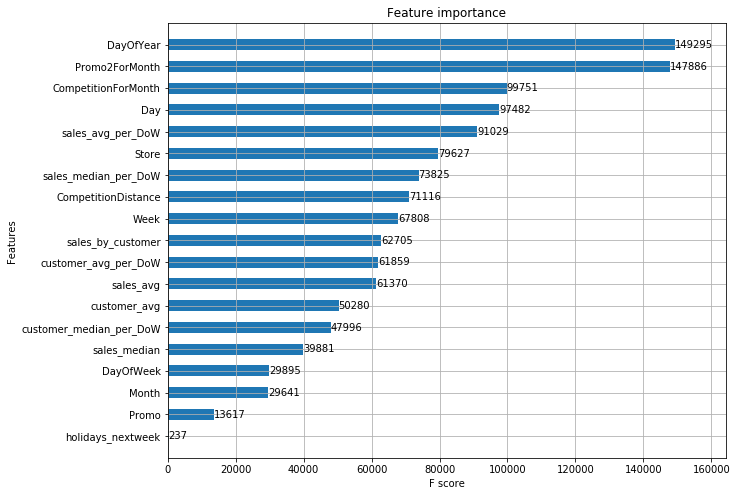

In [542]:
### plot feature importance
fig,ax = plt.subplots(figsize=(10,8))
plot_importance(gbm,height=0.5,ax=ax,max_num_features=64)
plt.show()

In [543]:
gbm.save_model('xgb-log-7.model')
dtest = xgb.DMatrix(test_set_X)
dtest.save_binary('dtest-xg-7.buffer')

In [375]:
# gbm = xgb.Booster({'nthread':4})
# gbm.load_model('xgb-log-7.model')

In [376]:
# dtrain = xgb.DMatrix(train_set_X, train_set_y)
# dvalid = xgb.DMatrix(valid_set_X, valid_set_y)
train_log_pred = gbm.predict(dtrain)
valid_log_pred = gbm.predict(dvalid)

In [377]:
print(rmspe_score(train_set_y.values, train_log_pred))
print(rmspe_score(valid_set_y.values, valid_log_pred))

0.00880558187531
0.0130448522114


In [378]:
train_pred = np.exp(train_log_pred)
valid_pred = np.exp(valid_log_pred)
print(rmspe_score(np.exp(train_set_y.values), train_pred))
print(rmspe_score(np.exp(valid_set_y.values), valid_pred))

0.0810282373462
0.118126587991


In [379]:
# 保存验证集预测结果
valid_result_df = pd.DataFrame(data={"Sales": valid_pred, "True": np.exp(valid_set_y.values)})
valid_result_df.to_csv('valid_prediction/valid-7.csv', index=False)

In [380]:
dtest = xgb.DMatrix(test_set_X)
test_xgb_pred = np.exp(gbm.predict(dtest))

# 整理提交格式
test_df_open = test_df[test_df.Open==1].reset_index().join(pd.DataFrame({'Sales':test_xgb_pred}), how='left')[['Id','Sales']]
test_submission = test_df.copy()
test_submission = pd.merge(test_submission, test_df_open, how='left', on='Id')[['Id','Sales']]
test_submission.loc[test_submission['Sales'].isnull(), 'Sales'] = 0
test_submission['Sales'] = test_submission['Sales'].astype(int)
test_submission = test_submission.sort_values('Id')
test_submission.to_csv('submission_xgb_7.csv', index=False)
print("Predictions saved to predictions/xgboost-log-7.csv")

Predictions saved to predictions/xgboost-log-7.csv


### 模型8

In [623]:
params = {'objective': 'reg:linear',
          'booster': 'gbtree',
          'eta': 0.03, 
          'max_depth': 10, 
          'subsample': 0.9, 
          'colsample_bytree': 0.5, 
          'silent':1, 
          'seed': 17
         }
num_boost_round = 3000
dtrain = xgb.DMatrix(train_set_X, train_set_y)
dvalid = xgb.DMatrix(valid_set_X, valid_set_y)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, 
                early_stopping_rounds=100, feval=rmspe_score_xg, 
                verbose_eval=True)

[0]	train-rmse:8.01947	eval-rmse:8.04189	train-rmspe:0.999809	eval-rmspe:0.999815
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.77909	eval-rmse:7.80171	train-rmspe:0.999712	eval-rmspe:0.999721
[2]	train-rmse:7.54591	eval-rmse:7.56894	train-rmspe:0.999593	eval-rmspe:0.999606
[3]	train-rmse:7.31973	eval-rmse:7.34295	train-rmspe:0.999449	eval-rmspe:0.999465
[4]	train-rmse:7.10036	eval-rmse:7.12359	train-rmspe:0.999275	eval-rmspe:0.999296
[5]	train-rmse:6.88758	eval-rmse:6.91111	train-rmspe:0.999065	eval-rmspe:0.999093
[6]	train-rmse:6.68117	eval-rmse:6.70506	train-rmspe:0.998815	eval-rmspe:0.99885
[7]	train-rmse:6.48099	eval-rmse:6.50502	train-rmspe:0.998518	eval-rmspe:0.998562
[8]	train-rmse:6.2868	eval-rmse:6.31122	train-rmspe:0.998169	eval-rmspe:0.998224
[9]	train-rmse:6.09842	eval-rmse:6.12286	train-rmspe:0.99776	eval-rmspe:0.997826
[10]	train-rmse:5.91571	eval-rmse:5.9

[97]	train-rmse:0.448384	eval-rmse:0.424484	train-rmspe:0.36152	eval-rmspe:0.333795
[98]	train-rmse:0.43656	eval-rmse:0.411363	train-rmspe:0.354455	eval-rmspe:0.325209
[99]	train-rmse:0.425165	eval-rmse:0.400009	train-rmspe:0.347564	eval-rmspe:0.317749
[100]	train-rmse:0.413835	eval-rmse:0.388441	train-rmspe:0.340762	eval-rmspe:0.310101
[101]	train-rmse:0.403095	eval-rmse:0.377719	train-rmspe:0.334203	eval-rmspe:0.302919
[102]	train-rmse:0.392737	eval-rmse:0.367481	train-rmspe:0.32787	eval-rmspe:0.295985
[103]	train-rmse:0.382778	eval-rmse:0.357869	train-rmspe:0.321757	eval-rmspe:0.289425
[104]	train-rmse:0.373129	eval-rmse:0.347471	train-rmspe:0.315802	eval-rmspe:0.282287
[105]	train-rmse:0.36379	eval-rmse:0.337174	train-rmspe:0.309917	eval-rmspe:0.275137
[106]	train-rmse:0.354843	eval-rmse:0.328654	train-rmspe:0.304361	eval-rmspe:0.269229
[107]	train-rmse:0.345933	eval-rmse:0.319517	train-rmspe:0.298862	eval-rmspe:0.26293
[108]	train-rmse:0.337276	eval-rmse:0.310768	train-rmspe:0.293

[193]	train-rmse:0.127786	eval-rmse:0.15272	train-rmspe:0.167482	eval-rmspe:0.166079
[194]	train-rmse:0.12755	eval-rmse:0.152781	train-rmspe:0.167438	eval-rmspe:0.166297
[195]	train-rmse:0.127339	eval-rmse:0.152926	train-rmspe:0.167395	eval-rmspe:0.166587
[196]	train-rmse:0.126979	eval-rmse:0.152681	train-rmspe:0.167269	eval-rmspe:0.1664
[197]	train-rmse:0.126768	eval-rmse:0.152753	train-rmspe:0.16714	eval-rmspe:0.166584
[198]	train-rmse:0.12659	eval-rmse:0.152836	train-rmspe:0.167132	eval-rmspe:0.166756
[199]	train-rmse:0.126356	eval-rmse:0.152868	train-rmspe:0.167069	eval-rmspe:0.166899
[200]	train-rmse:0.12623	eval-rmse:0.152964	train-rmspe:0.16707	eval-rmspe:0.167118
[201]	train-rmse:0.125826	eval-rmse:0.152952	train-rmspe:0.166883	eval-rmspe:0.167151
[202]	train-rmse:0.125319	eval-rmse:0.153005	train-rmspe:0.16661	eval-rmspe:0.167228
[203]	train-rmse:0.125198	eval-rmse:0.15315	train-rmspe:0.166619	eval-rmspe:0.16752
[204]	train-rmse:0.124975	eval-rmse:0.153	train-rmspe:0.166565	ev

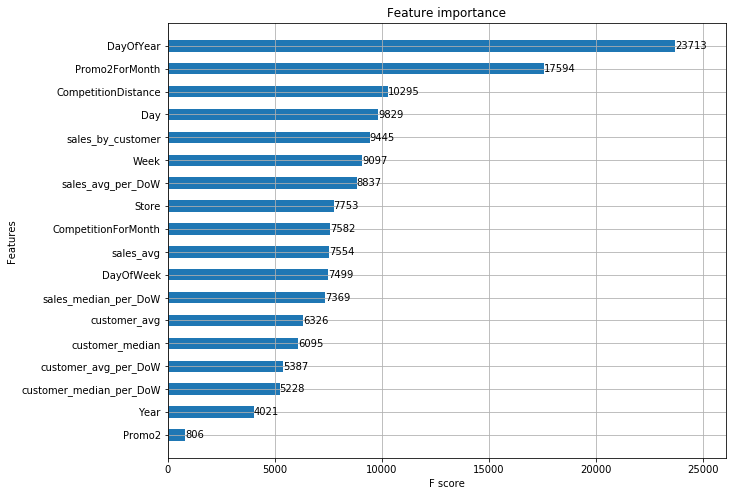

In [624]:
### plot feature importance
fig,ax = plt.subplots(figsize=(10,8))
plot_importance(gbm,height=0.5,ax=ax,max_num_features=64)
plt.show()

In [625]:
gbm.save_model('xgb-log-8.model')
dtest = xgb.DMatrix(test_set_X)
dtest.save_binary('dtest-xg-8.buffer')

In [626]:
test_xgb_pred = np.exp(gbm.predict(dtest))

In [627]:
# 整理提交格式
test_df_open = test_df[test_df.Open==1].reset_index().join(pd.DataFrame({'Sales':test_xgb_pred}), how='left')[['Id','Sales']]
test_submission = test_df.copy()
test_submission = pd.merge(test_submission, test_df_open, how='left', on='Id')[['Id','Sales']]
test_submission.loc[test_submission['Sales'].isnull(), 'Sales'] = 0
test_submission['Sales'] = test_submission['Sales'].astype(int)
test_submission = test_submission.sort_values('Id')
test_submission.to_csv('submission_xgb_8.csv', index=False)
print("Predictions saved to predictions/xgboost-log-8.csv")

Predictions saved to predictions/xgboost-log-8.csv


### 模型9

In [682]:
params = {'objective': 'reg:linear',
          'booster': 'gbtree',
          'eta': 0.03, 
          'max_depth': 10, 
          'subsample': 0.9, 
          'colsample_bytree': 0.5, 
          'silent':1, 
          'seed': 17
         }
num_boost_round = 3000
dtrain = xgb.DMatrix(train_set_X, train_set_y)
dvalid = xgb.DMatrix(valid_set_X, valid_set_y)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, 
                early_stopping_rounds=100, feval=rmspe_score_xg, 
                verbose_eval=True)

[0]	train-rmse:8.01947	eval-rmse:8.04189	train-rmspe:0.999809	eval-rmspe:0.999815
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.77909	eval-rmse:7.80171	train-rmspe:0.999712	eval-rmspe:0.999721
[2]	train-rmse:7.54591	eval-rmse:7.56894	train-rmspe:0.999593	eval-rmspe:0.999606
[3]	train-rmse:7.31973	eval-rmse:7.34295	train-rmspe:0.999449	eval-rmspe:0.999465
[4]	train-rmse:7.10036	eval-rmse:7.12359	train-rmspe:0.999275	eval-rmspe:0.999296
[5]	train-rmse:6.88758	eval-rmse:6.91118	train-rmspe:0.999065	eval-rmspe:0.999093
[6]	train-rmse:6.68117	eval-rmse:6.70514	train-rmspe:0.998815	eval-rmspe:0.99885
[7]	train-rmse:6.48099	eval-rmse:6.5051	train-rmspe:0.998518	eval-rmspe:0.998562
[8]	train-rmse:6.2868	eval-rmse:6.31128	train-rmspe:0.998169	eval-rmspe:0.998224
[9]	train-rmse:6.09842	eval-rmse:6.12293	train-rmspe:0.99776	eval-rmspe:0.997826
[10]	train-rmse:5.91571	eval-rmse:5.94

[97]	train-rmse:0.449914	eval-rmse:0.460486	train-rmspe:0.364593	eval-rmspe:0.356889
[98]	train-rmse:0.43814	eval-rmse:0.448396	train-rmspe:0.3577	eval-rmspe:0.349203
[99]	train-rmse:0.426799	eval-rmse:0.436505	train-rmspe:0.350775	eval-rmspe:0.341539
[100]	train-rmse:0.415673	eval-rmse:0.425252	train-rmspe:0.344195	eval-rmspe:0.334324
[101]	train-rmse:0.405069	eval-rmse:0.414583	train-rmspe:0.33787	eval-rmspe:0.327346
[102]	train-rmse:0.394757	eval-rmse:0.404315	train-rmspe:0.331678	eval-rmspe:0.320568
[103]	train-rmse:0.384761	eval-rmse:0.394123	train-rmspe:0.3257	eval-rmspe:0.313787
[104]	train-rmse:0.37519	eval-rmse:0.384575	train-rmspe:0.319949	eval-rmspe:0.307386
[105]	train-rmse:0.365922	eval-rmse:0.375514	train-rmspe:0.314358	eval-rmspe:0.301273
[106]	train-rmse:0.356987	eval-rmse:0.366747	train-rmspe:0.308968	eval-rmspe:0.295316
[107]	train-rmse:0.348071	eval-rmse:0.35771	train-rmspe:0.303614	eval-rmspe:0.289181
[108]	train-rmse:0.33939	eval-rmse:0.348569	train-rmspe:0.298376	

[193]	train-rmse:0.133593	eval-rmse:0.15238	train-rmspe:0.18635	eval-rmspe:0.154187
[194]	train-rmse:0.133413	eval-rmse:0.152309	train-rmspe:0.186333	eval-rmspe:0.154277
[195]	train-rmse:0.133171	eval-rmse:0.152312	train-rmspe:0.186366	eval-rmspe:0.15447
[196]	train-rmse:0.132712	eval-rmse:0.151861	train-rmspe:0.18607	eval-rmspe:0.15419
[197]	train-rmse:0.132483	eval-rmse:0.151747	train-rmspe:0.186043	eval-rmspe:0.154207
[198]	train-rmse:0.132201	eval-rmse:0.151665	train-rmspe:0.185991	eval-rmspe:0.154259
[199]	train-rmse:0.13199	eval-rmse:0.15154	train-rmspe:0.18596	eval-rmspe:0.154275
[200]	train-rmse:0.131873	eval-rmse:0.151491	train-rmspe:0.18597	eval-rmspe:0.154341
[201]	train-rmse:0.131651	eval-rmse:0.151414	train-rmspe:0.185924	eval-rmspe:0.154384
[202]	train-rmse:0.131353	eval-rmse:0.151053	train-rmspe:0.185802	eval-rmspe:0.154117
[203]	train-rmse:0.131203	eval-rmse:0.150961	train-rmspe:0.18574	eval-rmspe:0.154191
[204]	train-rmse:0.130971	eval-rmse:0.150877	train-rmspe:0.18559

[289]	train-rmse:0.11886	eval-rmse:0.143603	train-rmspe:0.170232	eval-rmspe:0.149898
[290]	train-rmse:0.118541	eval-rmse:0.143439	train-rmspe:0.169906	eval-rmspe:0.149663
[291]	train-rmse:0.118476	eval-rmse:0.143413	train-rmspe:0.16985	eval-rmspe:0.149616
[292]	train-rmse:0.11843	eval-rmse:0.143392	train-rmspe:0.169783	eval-rmspe:0.149602
[293]	train-rmse:0.118348	eval-rmse:0.143344	train-rmspe:0.169731	eval-rmspe:0.14955
[294]	train-rmse:0.118274	eval-rmse:0.143341	train-rmspe:0.169679	eval-rmspe:0.149555
[295]	train-rmse:0.118196	eval-rmse:0.143301	train-rmspe:0.169604	eval-rmspe:0.149518
[296]	train-rmse:0.118122	eval-rmse:0.143175	train-rmspe:0.169547	eval-rmspe:0.149402
[297]	train-rmse:0.118046	eval-rmse:0.143171	train-rmspe:0.169474	eval-rmspe:0.149402
[298]	train-rmse:0.117753	eval-rmse:0.143015	train-rmspe:0.169028	eval-rmspe:0.149233
[299]	train-rmse:0.117573	eval-rmse:0.143015	train-rmspe:0.168898	eval-rmspe:0.149245
[300]	train-rmse:0.11751	eval-rmse:0.142913	train-rmspe:0.

[385]	train-rmse:0.11127	eval-rmse:0.1399	train-rmspe:0.162063	eval-rmspe:0.146152
[386]	train-rmse:0.111239	eval-rmse:0.139893	train-rmspe:0.162036	eval-rmspe:0.146141
[387]	train-rmse:0.111169	eval-rmse:0.139855	train-rmspe:0.161978	eval-rmspe:0.146106
[388]	train-rmse:0.111129	eval-rmse:0.139844	train-rmspe:0.161942	eval-rmspe:0.146098
[389]	train-rmse:0.111065	eval-rmse:0.13974	train-rmspe:0.161894	eval-rmspe:0.145994
[390]	train-rmse:0.111013	eval-rmse:0.139722	train-rmspe:0.161856	eval-rmspe:0.14596
[391]	train-rmse:0.110939	eval-rmse:0.139674	train-rmspe:0.1618	eval-rmspe:0.145895
[392]	train-rmse:0.110893	eval-rmse:0.139663	train-rmspe:0.161769	eval-rmspe:0.145885
[393]	train-rmse:0.110873	eval-rmse:0.139663	train-rmspe:0.161756	eval-rmspe:0.145886
[394]	train-rmse:0.110826	eval-rmse:0.139641	train-rmspe:0.161719	eval-rmspe:0.145865
[395]	train-rmse:0.110777	eval-rmse:0.139627	train-rmspe:0.161631	eval-rmspe:0.145849
[396]	train-rmse:0.110712	eval-rmse:0.139581	train-rmspe:0.16

[481]	train-rmse:0.106102	eval-rmse:0.137829	train-rmspe:0.148517	eval-rmspe:0.14405
[482]	train-rmse:0.106077	eval-rmse:0.137789	train-rmspe:0.146847	eval-rmspe:0.144012
[483]	train-rmse:0.106011	eval-rmse:0.137731	train-rmspe:0.146775	eval-rmspe:0.143943
[484]	train-rmse:0.105986	eval-rmse:0.137714	train-rmspe:0.146742	eval-rmspe:0.143922
[485]	train-rmse:0.105962	eval-rmse:0.137679	train-rmspe:0.146658	eval-rmspe:0.143884
[486]	train-rmse:0.105922	eval-rmse:0.137654	train-rmspe:0.146595	eval-rmspe:0.143854
[487]	train-rmse:0.105886	eval-rmse:0.137643	train-rmspe:0.146565	eval-rmspe:0.143846
[488]	train-rmse:0.105852	eval-rmse:0.137623	train-rmspe:0.146529	eval-rmspe:0.143828
[489]	train-rmse:0.105824	eval-rmse:0.137596	train-rmspe:0.1457	eval-rmspe:0.143794
[490]	train-rmse:0.105772	eval-rmse:0.137563	train-rmspe:0.14555	eval-rmspe:0.143757
[491]	train-rmse:0.105747	eval-rmse:0.137509	train-rmspe:0.145514	eval-rmspe:0.143705
[492]	train-rmse:0.105715	eval-rmse:0.137482	train-rmspe:0

[577]	train-rmse:0.102374	eval-rmse:0.135791	train-rmspe:0.136627	eval-rmspe:0.142113
[578]	train-rmse:0.102366	eval-rmse:0.135791	train-rmspe:0.136623	eval-rmspe:0.142113
[579]	train-rmse:0.102335	eval-rmse:0.13577	train-rmspe:0.136598	eval-rmspe:0.142094
[580]	train-rmse:0.102257	eval-rmse:0.135752	train-rmspe:0.136509	eval-rmspe:0.142084
[581]	train-rmse:0.102251	eval-rmse:0.135752	train-rmspe:0.136504	eval-rmspe:0.142085
[582]	train-rmse:0.102204	eval-rmse:0.13575	train-rmspe:0.136404	eval-rmspe:0.14209
[583]	train-rmse:0.102088	eval-rmse:0.135722	train-rmspe:0.136303	eval-rmspe:0.14206
[584]	train-rmse:0.102046	eval-rmse:0.135718	train-rmspe:0.136267	eval-rmspe:0.142042
[585]	train-rmse:0.102023	eval-rmse:0.135708	train-rmspe:0.136241	eval-rmspe:0.142033
[586]	train-rmse:0.101987	eval-rmse:0.135691	train-rmspe:0.136171	eval-rmspe:0.142017
[587]	train-rmse:0.101943	eval-rmse:0.135649	train-rmspe:0.136109	eval-rmspe:0.141973
[588]	train-rmse:0.101914	eval-rmse:0.135611	train-rmspe:0

[673]	train-rmse:0.098928	eval-rmse:0.134293	train-rmspe:0.128863	eval-rmspe:0.140613
[674]	train-rmse:0.098909	eval-rmse:0.134288	train-rmspe:0.128836	eval-rmspe:0.140607
[675]	train-rmse:0.098884	eval-rmse:0.134282	train-rmspe:0.12881	eval-rmspe:0.140603
[676]	train-rmse:0.098875	eval-rmse:0.134278	train-rmspe:0.128802	eval-rmspe:0.140598
[677]	train-rmse:0.098837	eval-rmse:0.134251	train-rmspe:0.128764	eval-rmspe:0.14057
[678]	train-rmse:0.098814	eval-rmse:0.134253	train-rmspe:0.128739	eval-rmspe:0.140574
[679]	train-rmse:0.098782	eval-rmse:0.134257	train-rmspe:0.127917	eval-rmspe:0.140595
[680]	train-rmse:0.098749	eval-rmse:0.134219	train-rmspe:0.127878	eval-rmspe:0.140554
[681]	train-rmse:0.098721	eval-rmse:0.134215	train-rmspe:0.127847	eval-rmspe:0.140568
[682]	train-rmse:0.098692	eval-rmse:0.134205	train-rmspe:0.1278	eval-rmspe:0.140549
[683]	train-rmse:0.098673	eval-rmse:0.134187	train-rmspe:0.127781	eval-rmspe:0.140529
[684]	train-rmse:0.098654	eval-rmse:0.134187	train-rmspe:0

[769]	train-rmse:0.096353	eval-rmse:0.132794	train-rmspe:0.120989	eval-rmspe:0.138959
[770]	train-rmse:0.096318	eval-rmse:0.132768	train-rmspe:0.120955	eval-rmspe:0.138933
[771]	train-rmse:0.096249	eval-rmse:0.132781	train-rmspe:0.120897	eval-rmspe:0.138949
[772]	train-rmse:0.096218	eval-rmse:0.132754	train-rmspe:0.120866	eval-rmspe:0.138928
[773]	train-rmse:0.096197	eval-rmse:0.132754	train-rmspe:0.120847	eval-rmspe:0.138927
[774]	train-rmse:0.096181	eval-rmse:0.132755	train-rmspe:0.120832	eval-rmspe:0.138928
[775]	train-rmse:0.096142	eval-rmse:0.132728	train-rmspe:0.120583	eval-rmspe:0.138901
[776]	train-rmse:0.096115	eval-rmse:0.132718	train-rmspe:0.120556	eval-rmspe:0.138889
[777]	train-rmse:0.096104	eval-rmse:0.132712	train-rmspe:0.120532	eval-rmspe:0.13888
[778]	train-rmse:0.0961	eval-rmse:0.132711	train-rmspe:0.120526	eval-rmspe:0.138878
[779]	train-rmse:0.096087	eval-rmse:0.132708	train-rmspe:0.120512	eval-rmspe:0.138867
[780]	train-rmse:0.096041	eval-rmse:0.132706	train-rmspe:

[865]	train-rmse:0.093927	eval-rmse:0.132036	train-rmspe:0.113322	eval-rmspe:0.138273
[866]	train-rmse:0.093917	eval-rmse:0.132029	train-rmspe:0.113313	eval-rmspe:0.138266
[867]	train-rmse:0.093884	eval-rmse:0.132023	train-rmspe:0.113279	eval-rmspe:0.138268
[868]	train-rmse:0.093858	eval-rmse:0.132015	train-rmspe:0.113254	eval-rmspe:0.138262
[869]	train-rmse:0.093846	eval-rmse:0.132011	train-rmspe:0.113243	eval-rmspe:0.138258
[870]	train-rmse:0.093801	eval-rmse:0.132007	train-rmspe:0.113204	eval-rmspe:0.138249
[871]	train-rmse:0.093775	eval-rmse:0.132008	train-rmspe:0.113172	eval-rmspe:0.138252
[872]	train-rmse:0.093737	eval-rmse:0.132008	train-rmspe:0.1131	eval-rmspe:0.138253
[873]	train-rmse:0.09371	eval-rmse:0.131975	train-rmspe:0.113064	eval-rmspe:0.138222
[874]	train-rmse:0.093693	eval-rmse:0.131963	train-rmspe:0.113048	eval-rmspe:0.138211
[875]	train-rmse:0.093642	eval-rmse:0.131962	train-rmspe:0.113	eval-rmspe:0.138213
[876]	train-rmse:0.093621	eval-rmse:0.13194	train-rmspe:0.11

[961]	train-rmse:0.091693	eval-rmse:0.131089	train-rmspe:0.107491	eval-rmspe:0.137309
[962]	train-rmse:0.091667	eval-rmse:0.131079	train-rmspe:0.107465	eval-rmspe:0.137303
[963]	train-rmse:0.091647	eval-rmse:0.131044	train-rmspe:0.107444	eval-rmspe:0.137252
[964]	train-rmse:0.091612	eval-rmse:0.131023	train-rmspe:0.107402	eval-rmspe:0.137235
[965]	train-rmse:0.091581	eval-rmse:0.131022	train-rmspe:0.107363	eval-rmspe:0.137235
[966]	train-rmse:0.091569	eval-rmse:0.131023	train-rmspe:0.107351	eval-rmspe:0.137235
[967]	train-rmse:0.091543	eval-rmse:0.130997	train-rmspe:0.107304	eval-rmspe:0.137202
[968]	train-rmse:0.091523	eval-rmse:0.130996	train-rmspe:0.107285	eval-rmspe:0.137205
[969]	train-rmse:0.091498	eval-rmse:0.130983	train-rmspe:0.107262	eval-rmspe:0.137194
[970]	train-rmse:0.091486	eval-rmse:0.130984	train-rmspe:0.10724	eval-rmspe:0.137192
[971]	train-rmse:0.091464	eval-rmse:0.130977	train-rmspe:0.107211	eval-rmspe:0.137188
[972]	train-rmse:0.091456	eval-rmse:0.130971	train-rmsp

[1057]	train-rmse:0.089921	eval-rmse:0.13042	train-rmspe:0.104009	eval-rmspe:0.136597
[1058]	train-rmse:0.08991	eval-rmse:0.13042	train-rmspe:0.103998	eval-rmspe:0.136597
[1059]	train-rmse:0.089892	eval-rmse:0.130401	train-rmspe:0.103976	eval-rmspe:0.136566
[1060]	train-rmse:0.08988	eval-rmse:0.130401	train-rmspe:0.103959	eval-rmspe:0.136568
[1061]	train-rmse:0.089863	eval-rmse:0.1304	train-rmspe:0.103942	eval-rmspe:0.136568
[1062]	train-rmse:0.089844	eval-rmse:0.130387	train-rmspe:0.103922	eval-rmspe:0.136558
[1063]	train-rmse:0.08982	eval-rmse:0.130377	train-rmspe:0.103902	eval-rmspe:0.136547
[1064]	train-rmse:0.089802	eval-rmse:0.13036	train-rmspe:0.103884	eval-rmspe:0.136531
[1065]	train-rmse:0.089768	eval-rmse:0.130358	train-rmspe:0.103839	eval-rmspe:0.13653
[1066]	train-rmse:0.08976	eval-rmse:0.13035	train-rmspe:0.103831	eval-rmspe:0.136502
[1067]	train-rmse:0.089736	eval-rmse:0.130365	train-rmspe:0.103807	eval-rmspe:0.136522
[1068]	train-rmse:0.08972	eval-rmse:0.130355	train-rms

[1152]	train-rmse:0.088196	eval-rmse:0.12985	train-rmspe:0.100223	eval-rmspe:0.135895
[1153]	train-rmse:0.088186	eval-rmse:0.129846	train-rmspe:0.100212	eval-rmspe:0.135891
[1154]	train-rmse:0.088179	eval-rmse:0.129839	train-rmspe:0.100062	eval-rmspe:0.135886
[1155]	train-rmse:0.088166	eval-rmse:0.129839	train-rmspe:0.100047	eval-rmspe:0.135887
[1156]	train-rmse:0.088155	eval-rmse:0.129833	train-rmspe:0.100034	eval-rmspe:0.135881
[1157]	train-rmse:0.088135	eval-rmse:0.129826	train-rmspe:0.100011	eval-rmspe:0.135876
[1158]	train-rmse:0.088116	eval-rmse:0.129815	train-rmspe:0.099995	eval-rmspe:0.135868
[1159]	train-rmse:0.088097	eval-rmse:0.129804	train-rmspe:0.099961	eval-rmspe:0.135845
[1160]	train-rmse:0.088083	eval-rmse:0.129803	train-rmspe:0.099943	eval-rmspe:0.135844
[1161]	train-rmse:0.088062	eval-rmse:0.129835	train-rmspe:0.099909	eval-rmspe:0.135876
[1162]	train-rmse:0.088054	eval-rmse:0.12983	train-rmspe:0.099902	eval-rmspe:0.135872
[1163]	train-rmse:0.088035	eval-rmse:0.129825

[1247]	train-rmse:0.086745	eval-rmse:0.129551	train-rmspe:0.097571	eval-rmspe:0.135553
[1248]	train-rmse:0.086738	eval-rmse:0.129539	train-rmspe:0.097564	eval-rmspe:0.13554
[1249]	train-rmse:0.086735	eval-rmse:0.129538	train-rmspe:0.097561	eval-rmspe:0.135539
[1250]	train-rmse:0.08672	eval-rmse:0.129532	train-rmspe:0.097468	eval-rmspe:0.135533
[1251]	train-rmse:0.086706	eval-rmse:0.129525	train-rmspe:0.097452	eval-rmspe:0.135527
[1252]	train-rmse:0.086696	eval-rmse:0.129519	train-rmspe:0.097439	eval-rmspe:0.13552
[1253]	train-rmse:0.086687	eval-rmse:0.129503	train-rmspe:0.09743	eval-rmspe:0.135502
[1254]	train-rmse:0.08667	eval-rmse:0.129485	train-rmspe:0.097413	eval-rmspe:0.135486
[1255]	train-rmse:0.086628	eval-rmse:0.129485	train-rmspe:0.097373	eval-rmspe:0.135491
[1256]	train-rmse:0.086611	eval-rmse:0.129479	train-rmspe:0.097235	eval-rmspe:0.135484
[1257]	train-rmse:0.086593	eval-rmse:0.129475	train-rmspe:0.097202	eval-rmspe:0.135478
[1258]	train-rmse:0.08655	eval-rmse:0.129476	tra

[1342]	train-rmse:0.085302	eval-rmse:0.129063	train-rmspe:0.094364	eval-rmspe:0.135067
[1343]	train-rmse:0.085292	eval-rmse:0.129062	train-rmspe:0.094354	eval-rmspe:0.135069
[1344]	train-rmse:0.085279	eval-rmse:0.12905	train-rmspe:0.094341	eval-rmspe:0.135055
[1345]	train-rmse:0.085263	eval-rmse:0.129046	train-rmspe:0.094321	eval-rmspe:0.135049
[1346]	train-rmse:0.085252	eval-rmse:0.129045	train-rmspe:0.094306	eval-rmspe:0.135047
[1347]	train-rmse:0.085244	eval-rmse:0.129046	train-rmspe:0.094299	eval-rmspe:0.135049
[1348]	train-rmse:0.085233	eval-rmse:0.129036	train-rmspe:0.094216	eval-rmspe:0.135037
[1349]	train-rmse:0.085212	eval-rmse:0.129031	train-rmspe:0.094047	eval-rmspe:0.135032
[1350]	train-rmse:0.085199	eval-rmse:0.129026	train-rmspe:0.094033	eval-rmspe:0.135025
[1351]	train-rmse:0.085192	eval-rmse:0.129023	train-rmspe:0.094026	eval-rmspe:0.135021
[1352]	train-rmse:0.085186	eval-rmse:0.129023	train-rmspe:0.094019	eval-rmspe:0.135022
[1353]	train-rmse:0.085173	eval-rmse:0.12902

[1437]	train-rmse:0.084035	eval-rmse:0.128744	train-rmspe:0.092106	eval-rmspe:0.134779
[1438]	train-rmse:0.084008	eval-rmse:0.128747	train-rmspe:0.092067	eval-rmspe:0.134787
[1439]	train-rmse:0.083994	eval-rmse:0.128744	train-rmspe:0.092052	eval-rmspe:0.134785
[1440]	train-rmse:0.083967	eval-rmse:0.128739	train-rmspe:0.092025	eval-rmspe:0.134782
[1441]	train-rmse:0.083948	eval-rmse:0.128727	train-rmspe:0.091993	eval-rmspe:0.134767
[1442]	train-rmse:0.083944	eval-rmse:0.128726	train-rmspe:0.091988	eval-rmspe:0.134766
[1443]	train-rmse:0.083931	eval-rmse:0.128721	train-rmspe:0.091975	eval-rmspe:0.134763
[1444]	train-rmse:0.083917	eval-rmse:0.128712	train-rmspe:0.091956	eval-rmspe:0.134754
[1445]	train-rmse:0.083909	eval-rmse:0.12871	train-rmspe:0.091944	eval-rmspe:0.134753
[1446]	train-rmse:0.083891	eval-rmse:0.128703	train-rmspe:0.091921	eval-rmspe:0.134745
[1447]	train-rmse:0.083873	eval-rmse:0.128702	train-rmspe:0.091903	eval-rmspe:0.134744
[1448]	train-rmse:0.083855	eval-rmse:0.12868

[1532]	train-rmse:0.082807	eval-rmse:0.128319	train-rmspe:0.090478	eval-rmspe:0.134316
[1533]	train-rmse:0.082787	eval-rmse:0.128317	train-rmspe:0.090452	eval-rmspe:0.134316
[1534]	train-rmse:0.082778	eval-rmse:0.128314	train-rmspe:0.090443	eval-rmspe:0.134309
[1535]	train-rmse:0.08277	eval-rmse:0.128312	train-rmspe:0.090431	eval-rmspe:0.134306
[1536]	train-rmse:0.082765	eval-rmse:0.128311	train-rmspe:0.090425	eval-rmspe:0.134305
[1537]	train-rmse:0.082755	eval-rmse:0.128312	train-rmspe:0.090415	eval-rmspe:0.134306
[1538]	train-rmse:0.082737	eval-rmse:0.128311	train-rmspe:0.090391	eval-rmspe:0.134305
[1539]	train-rmse:0.082722	eval-rmse:0.128306	train-rmspe:0.090354	eval-rmspe:0.134301
[1540]	train-rmse:0.082705	eval-rmse:0.128299	train-rmspe:0.090334	eval-rmspe:0.134293
[1541]	train-rmse:0.082685	eval-rmse:0.128297	train-rmspe:0.090315	eval-rmspe:0.134296
[1542]	train-rmse:0.082667	eval-rmse:0.128295	train-rmspe:0.090179	eval-rmspe:0.134297
[1543]	train-rmse:0.082653	eval-rmse:0.12829

[1627]	train-rmse:0.081655	eval-rmse:0.128025	train-rmspe:0.08847	eval-rmspe:0.134028
[1628]	train-rmse:0.081639	eval-rmse:0.128	train-rmspe:0.08845	eval-rmspe:0.134
[1629]	train-rmse:0.081626	eval-rmse:0.127995	train-rmspe:0.088437	eval-rmspe:0.133993
[1630]	train-rmse:0.081615	eval-rmse:0.127988	train-rmspe:0.088425	eval-rmspe:0.133986
[1631]	train-rmse:0.081597	eval-rmse:0.12799	train-rmspe:0.088404	eval-rmspe:0.133992
[1632]	train-rmse:0.081583	eval-rmse:0.12798	train-rmspe:0.088381	eval-rmspe:0.133981
[1633]	train-rmse:0.081579	eval-rmse:0.127975	train-rmspe:0.088378	eval-rmspe:0.133971
[1634]	train-rmse:0.081566	eval-rmse:0.127971	train-rmspe:0.088364	eval-rmspe:0.133967
[1635]	train-rmse:0.081542	eval-rmse:0.127972	train-rmspe:0.088342	eval-rmspe:0.133967
[1636]	train-rmse:0.081538	eval-rmse:0.127968	train-rmspe:0.088336	eval-rmspe:0.133964
[1637]	train-rmse:0.081529	eval-rmse:0.127968	train-rmspe:0.088326	eval-rmspe:0.133962
[1638]	train-rmse:0.081519	eval-rmse:0.12797	train-rm

[1722]	train-rmse:0.080501	eval-rmse:0.127889	train-rmspe:0.086877	eval-rmspe:0.133861
[1723]	train-rmse:0.080491	eval-rmse:0.127886	train-rmspe:0.086866	eval-rmspe:0.133858
[1724]	train-rmse:0.080477	eval-rmse:0.127883	train-rmspe:0.08685	eval-rmspe:0.133855
[1725]	train-rmse:0.080465	eval-rmse:0.12788	train-rmspe:0.086827	eval-rmspe:0.133853
[1726]	train-rmse:0.080458	eval-rmse:0.127881	train-rmspe:0.086819	eval-rmspe:0.133857
[1727]	train-rmse:0.080444	eval-rmse:0.127878	train-rmspe:0.086799	eval-rmspe:0.133854
[1728]	train-rmse:0.080435	eval-rmse:0.127871	train-rmspe:0.08679	eval-rmspe:0.133846
[1729]	train-rmse:0.080427	eval-rmse:0.12787	train-rmspe:0.086782	eval-rmspe:0.133846
[1730]	train-rmse:0.080411	eval-rmse:0.127872	train-rmspe:0.086764	eval-rmspe:0.133846
[1731]	train-rmse:0.080396	eval-rmse:0.127868	train-rmspe:0.086713	eval-rmspe:0.133843
[1732]	train-rmse:0.080389	eval-rmse:0.127865	train-rmspe:0.086706	eval-rmspe:0.133839
[1733]	train-rmse:0.080374	eval-rmse:0.12786	tr

[1817]	train-rmse:0.079397	eval-rmse:0.12764	train-rmspe:0.085319	eval-rmspe:0.133595
[1818]	train-rmse:0.079392	eval-rmse:0.127638	train-rmspe:0.085313	eval-rmspe:0.133594
[1819]	train-rmse:0.079378	eval-rmse:0.127631	train-rmspe:0.085298	eval-rmspe:0.133587
[1820]	train-rmse:0.079367	eval-rmse:0.127627	train-rmspe:0.085286	eval-rmspe:0.133585
[1821]	train-rmse:0.079361	eval-rmse:0.127622	train-rmspe:0.08528	eval-rmspe:0.133579
[1822]	train-rmse:0.07935	eval-rmse:0.127616	train-rmspe:0.085268	eval-rmspe:0.133574
[1823]	train-rmse:0.079336	eval-rmse:0.127602	train-rmspe:0.085199	eval-rmspe:0.133554
[1824]	train-rmse:0.079321	eval-rmse:0.127598	train-rmspe:0.085178	eval-rmspe:0.133552
[1825]	train-rmse:0.079311	eval-rmse:0.127594	train-rmspe:0.085166	eval-rmspe:0.13355
[1826]	train-rmse:0.079306	eval-rmse:0.127599	train-rmspe:0.085161	eval-rmspe:0.133556
[1827]	train-rmse:0.079298	eval-rmse:0.127593	train-rmspe:0.085151	eval-rmspe:0.133551
[1828]	train-rmse:0.07929	eval-rmse:0.127596	tr

[1912]	train-rmse:0.078328	eval-rmse:0.127442	train-rmspe:0.083804	eval-rmspe:0.133443
[1913]	train-rmse:0.078321	eval-rmse:0.127438	train-rmspe:0.083797	eval-rmspe:0.133438
[1914]	train-rmse:0.078305	eval-rmse:0.127437	train-rmspe:0.083773	eval-rmspe:0.133437
[1915]	train-rmse:0.078294	eval-rmse:0.127431	train-rmspe:0.083756	eval-rmspe:0.133433
[1916]	train-rmse:0.078282	eval-rmse:0.127431	train-rmspe:0.083738	eval-rmspe:0.133432
[1917]	train-rmse:0.078266	eval-rmse:0.127409	train-rmspe:0.083719	eval-rmspe:0.13342
[1918]	train-rmse:0.078259	eval-rmse:0.127404	train-rmspe:0.083708	eval-rmspe:0.133415
[1919]	train-rmse:0.078244	eval-rmse:0.127401	train-rmspe:0.08369	eval-rmspe:0.133411
[1920]	train-rmse:0.078232	eval-rmse:0.127401	train-rmspe:0.083677	eval-rmspe:0.133409
[1921]	train-rmse:0.078226	eval-rmse:0.127398	train-rmspe:0.08367	eval-rmspe:0.133399
[1922]	train-rmse:0.078206	eval-rmse:0.127404	train-rmspe:0.083648	eval-rmspe:0.13341
[1923]	train-rmse:0.078192	eval-rmse:0.127407	t

[2007]	train-rmse:0.077406	eval-rmse:0.12723	train-rmspe:0.082529	eval-rmspe:0.13325
[2008]	train-rmse:0.077396	eval-rmse:0.127231	train-rmspe:0.082512	eval-rmspe:0.133254
[2009]	train-rmse:0.077387	eval-rmse:0.127224	train-rmspe:0.082502	eval-rmspe:0.13324
[2010]	train-rmse:0.077374	eval-rmse:0.127188	train-rmspe:0.082489	eval-rmspe:0.1332
[2011]	train-rmse:0.077358	eval-rmse:0.12716	train-rmspe:0.082473	eval-rmspe:0.133178
[2012]	train-rmse:0.077345	eval-rmse:0.127158	train-rmspe:0.082457	eval-rmspe:0.133177
[2013]	train-rmse:0.077334	eval-rmse:0.127156	train-rmspe:0.082444	eval-rmspe:0.133175
[2014]	train-rmse:0.077327	eval-rmse:0.127156	train-rmspe:0.082437	eval-rmspe:0.133175
[2015]	train-rmse:0.077317	eval-rmse:0.127153	train-rmspe:0.082427	eval-rmspe:0.133173
[2016]	train-rmse:0.077308	eval-rmse:0.127153	train-rmspe:0.082418	eval-rmspe:0.133174
[2017]	train-rmse:0.077302	eval-rmse:0.127153	train-rmspe:0.082409	eval-rmspe:0.133175
[2018]	train-rmse:0.077297	eval-rmse:0.127152	tra

[2102]	train-rmse:0.076462	eval-rmse:0.126986	train-rmspe:0.08128	eval-rmspe:0.133008
[2103]	train-rmse:0.076445	eval-rmse:0.126985	train-rmspe:0.081261	eval-rmspe:0.133008
[2104]	train-rmse:0.076434	eval-rmse:0.126987	train-rmspe:0.08125	eval-rmspe:0.13301
[2105]	train-rmse:0.076426	eval-rmse:0.126981	train-rmspe:0.081239	eval-rmspe:0.133004
[2106]	train-rmse:0.076414	eval-rmse:0.126976	train-rmspe:0.081225	eval-rmspe:0.132996
[2107]	train-rmse:0.076403	eval-rmse:0.126974	train-rmspe:0.081212	eval-rmspe:0.132995
[2108]	train-rmse:0.076394	eval-rmse:0.126975	train-rmspe:0.081204	eval-rmspe:0.132996
[2109]	train-rmse:0.076384	eval-rmse:0.126974	train-rmspe:0.081185	eval-rmspe:0.132996
[2110]	train-rmse:0.076378	eval-rmse:0.126976	train-rmspe:0.081178	eval-rmspe:0.132998
[2111]	train-rmse:0.076371	eval-rmse:0.126974	train-rmspe:0.081171	eval-rmspe:0.132994
[2112]	train-rmse:0.076359	eval-rmse:0.126973	train-rmspe:0.081157	eval-rmspe:0.132991
[2113]	train-rmse:0.076357	eval-rmse:0.126971	

[2197]	train-rmse:0.075613	eval-rmse:0.126879	train-rmspe:0.080228	eval-rmspe:0.132905
[2198]	train-rmse:0.075605	eval-rmse:0.126877	train-rmspe:0.08022	eval-rmspe:0.132902
[2199]	train-rmse:0.075591	eval-rmse:0.126873	train-rmspe:0.080205	eval-rmspe:0.132896
[2200]	train-rmse:0.075582	eval-rmse:0.126873	train-rmspe:0.080195	eval-rmspe:0.132896
[2201]	train-rmse:0.075573	eval-rmse:0.126869	train-rmspe:0.080186	eval-rmspe:0.132893
[2202]	train-rmse:0.075561	eval-rmse:0.12686	train-rmspe:0.080171	eval-rmspe:0.132885
[2203]	train-rmse:0.075556	eval-rmse:0.126858	train-rmspe:0.080164	eval-rmspe:0.132881
[2204]	train-rmse:0.075544	eval-rmse:0.12686	train-rmspe:0.080148	eval-rmspe:0.132897
[2205]	train-rmse:0.075536	eval-rmse:0.126856	train-rmspe:0.080133	eval-rmspe:0.132895
[2206]	train-rmse:0.07553	eval-rmse:0.126854	train-rmspe:0.080127	eval-rmspe:0.132892
[2207]	train-rmse:0.075522	eval-rmse:0.126858	train-rmspe:0.080118	eval-rmspe:0.132902
[2208]	train-rmse:0.075511	eval-rmse:0.126857	t

[2292]	train-rmse:0.074803	eval-rmse:0.126683	train-rmspe:0.079224	eval-rmspe:0.132721
[2293]	train-rmse:0.074794	eval-rmse:0.126684	train-rmspe:0.079213	eval-rmspe:0.132721
[2294]	train-rmse:0.074786	eval-rmse:0.126681	train-rmspe:0.079205	eval-rmspe:0.132719
[2295]	train-rmse:0.07478	eval-rmse:0.126681	train-rmspe:0.079197	eval-rmspe:0.132718
[2296]	train-rmse:0.074776	eval-rmse:0.12668	train-rmspe:0.079193	eval-rmspe:0.132717
[2297]	train-rmse:0.07477	eval-rmse:0.126679	train-rmspe:0.079183	eval-rmspe:0.132716
[2298]	train-rmse:0.074761	eval-rmse:0.126672	train-rmspe:0.079168	eval-rmspe:0.132709
[2299]	train-rmse:0.074756	eval-rmse:0.126666	train-rmspe:0.079161	eval-rmspe:0.1327
[2300]	train-rmse:0.074746	eval-rmse:0.126665	train-rmspe:0.07915	eval-rmspe:0.1327
[2301]	train-rmse:0.074737	eval-rmse:0.126665	train-rmspe:0.079136	eval-rmspe:0.1327
[2302]	train-rmse:0.074733	eval-rmse:0.126665	train-rmspe:0.079131	eval-rmspe:0.132701
[2303]	train-rmse:0.07473	eval-rmse:0.126667	train-rm

[2387]	train-rmse:0.073991	eval-rmse:0.126605	train-rmspe:0.07818	eval-rmspe:0.132705
[2388]	train-rmse:0.073988	eval-rmse:0.126605	train-rmspe:0.078175	eval-rmspe:0.132705
[2389]	train-rmse:0.073977	eval-rmse:0.126603	train-rmspe:0.078159	eval-rmspe:0.132704
[2390]	train-rmse:0.073971	eval-rmse:0.126603	train-rmspe:0.078151	eval-rmspe:0.132702
[2391]	train-rmse:0.073957	eval-rmse:0.126603	train-rmspe:0.078138	eval-rmspe:0.132702
[2392]	train-rmse:0.073951	eval-rmse:0.126603	train-rmspe:0.07813	eval-rmspe:0.132702
[2393]	train-rmse:0.073943	eval-rmse:0.1266	train-rmspe:0.07812	eval-rmspe:0.132701
[2394]	train-rmse:0.073933	eval-rmse:0.126603	train-rmspe:0.078111	eval-rmspe:0.132706
[2395]	train-rmse:0.073928	eval-rmse:0.126605	train-rmspe:0.078106	eval-rmspe:0.132708
[2396]	train-rmse:0.073919	eval-rmse:0.126605	train-rmspe:0.078095	eval-rmspe:0.132708
[2397]	train-rmse:0.073907	eval-rmse:0.126603	train-rmspe:0.078075	eval-rmspe:0.132707
[2398]	train-rmse:0.073906	eval-rmse:0.126603	tr

[2482]	train-rmse:0.073228	eval-rmse:0.126424	train-rmspe:0.077255	eval-rmspe:0.132516
[2483]	train-rmse:0.073217	eval-rmse:0.126423	train-rmspe:0.077242	eval-rmspe:0.132515
[2484]	train-rmse:0.073209	eval-rmse:0.12642	train-rmspe:0.077233	eval-rmspe:0.132511
[2485]	train-rmse:0.073193	eval-rmse:0.126425	train-rmspe:0.077213	eval-rmspe:0.132513
[2486]	train-rmse:0.073184	eval-rmse:0.126425	train-rmspe:0.077203	eval-rmspe:0.132513
[2487]	train-rmse:0.073177	eval-rmse:0.126424	train-rmspe:0.077194	eval-rmspe:0.132512
[2488]	train-rmse:0.07317	eval-rmse:0.126423	train-rmspe:0.077187	eval-rmspe:0.132512
[2489]	train-rmse:0.073163	eval-rmse:0.126428	train-rmspe:0.07718	eval-rmspe:0.132518
[2490]	train-rmse:0.073152	eval-rmse:0.126428	train-rmspe:0.077169	eval-rmspe:0.132518
[2491]	train-rmse:0.073144	eval-rmse:0.126429	train-rmspe:0.077162	eval-rmspe:0.132518
[2492]	train-rmse:0.073134	eval-rmse:0.126428	train-rmspe:0.077151	eval-rmspe:0.132518
[2493]	train-rmse:0.073125	eval-rmse:0.126424	

[2577]	train-rmse:0.072492	eval-rmse:0.126323	train-rmspe:0.076357	eval-rmspe:0.132415
[2578]	train-rmse:0.072487	eval-rmse:0.126322	train-rmspe:0.076352	eval-rmspe:0.132412
[2579]	train-rmse:0.072483	eval-rmse:0.126321	train-rmspe:0.076347	eval-rmspe:0.132415
[2580]	train-rmse:0.072476	eval-rmse:0.126316	train-rmspe:0.076335	eval-rmspe:0.132408
[2581]	train-rmse:0.072468	eval-rmse:0.126314	train-rmspe:0.076326	eval-rmspe:0.132406
[2582]	train-rmse:0.072464	eval-rmse:0.126307	train-rmspe:0.076322	eval-rmspe:0.132399
[2583]	train-rmse:0.072458	eval-rmse:0.126309	train-rmspe:0.076317	eval-rmspe:0.13239
[2584]	train-rmse:0.072455	eval-rmse:0.126307	train-rmspe:0.076314	eval-rmspe:0.132387
[2585]	train-rmse:0.072453	eval-rmse:0.126306	train-rmspe:0.076311	eval-rmspe:0.132386
[2586]	train-rmse:0.072443	eval-rmse:0.126303	train-rmspe:0.076299	eval-rmspe:0.132382
[2587]	train-rmse:0.072436	eval-rmse:0.126302	train-rmspe:0.076288	eval-rmspe:0.132383
[2588]	train-rmse:0.07243	eval-rmse:0.126298

[2672]	train-rmse:0.071744	eval-rmse:0.126163	train-rmspe:0.075425	eval-rmspe:0.132256
[2673]	train-rmse:0.071735	eval-rmse:0.126162	train-rmspe:0.075415	eval-rmspe:0.132255
[2674]	train-rmse:0.071725	eval-rmse:0.126161	train-rmspe:0.075405	eval-rmspe:0.132254
[2675]	train-rmse:0.071716	eval-rmse:0.126162	train-rmspe:0.075394	eval-rmspe:0.132257
[2676]	train-rmse:0.07171	eval-rmse:0.126157	train-rmspe:0.075387	eval-rmspe:0.132235
[2677]	train-rmse:0.071696	eval-rmse:0.126157	train-rmspe:0.075364	eval-rmspe:0.132234
[2678]	train-rmse:0.071687	eval-rmse:0.12616	train-rmspe:0.075352	eval-rmspe:0.132237
[2679]	train-rmse:0.071679	eval-rmse:0.12616	train-rmspe:0.075342	eval-rmspe:0.132237
[2680]	train-rmse:0.071677	eval-rmse:0.12616	train-rmspe:0.075338	eval-rmspe:0.132235
[2681]	train-rmse:0.071671	eval-rmse:0.126153	train-rmspe:0.075333	eval-rmspe:0.132231
[2682]	train-rmse:0.071662	eval-rmse:0.126152	train-rmspe:0.075323	eval-rmspe:0.132235
[2683]	train-rmse:0.071656	eval-rmse:0.126151	t

[2767]	train-rmse:0.071051	eval-rmse:0.126089	train-rmspe:0.074589	eval-rmspe:0.13216
[2768]	train-rmse:0.071047	eval-rmse:0.126087	train-rmspe:0.074584	eval-rmspe:0.132158
[2769]	train-rmse:0.071038	eval-rmse:0.126085	train-rmspe:0.074575	eval-rmspe:0.132156
[2770]	train-rmse:0.071031	eval-rmse:0.12608	train-rmspe:0.074568	eval-rmspe:0.132148
[2771]	train-rmse:0.071025	eval-rmse:0.126073	train-rmspe:0.07456	eval-rmspe:0.132138
[2772]	train-rmse:0.071018	eval-rmse:0.126072	train-rmspe:0.074552	eval-rmspe:0.132136
[2773]	train-rmse:0.071012	eval-rmse:0.126075	train-rmspe:0.074541	eval-rmspe:0.13214
[2774]	train-rmse:0.071007	eval-rmse:0.126074	train-rmspe:0.074535	eval-rmspe:0.132139
[2775]	train-rmse:0.07099	eval-rmse:0.126056	train-rmspe:0.074516	eval-rmspe:0.132119
[2776]	train-rmse:0.070986	eval-rmse:0.126057	train-rmspe:0.074511	eval-rmspe:0.132121
[2777]	train-rmse:0.070982	eval-rmse:0.126057	train-rmspe:0.074506	eval-rmspe:0.132121
[2778]	train-rmse:0.070977	eval-rmse:0.126056	tr

[2862]	train-rmse:0.070338	eval-rmse:0.125932	train-rmspe:0.073742	eval-rmspe:0.132026
[2863]	train-rmse:0.070327	eval-rmse:0.125931	train-rmspe:0.073728	eval-rmspe:0.132027
[2864]	train-rmse:0.070316	eval-rmse:0.125917	train-rmspe:0.073706	eval-rmspe:0.132004
[2865]	train-rmse:0.070309	eval-rmse:0.125917	train-rmspe:0.073699	eval-rmspe:0.132005
[2866]	train-rmse:0.070298	eval-rmse:0.125916	train-rmspe:0.073687	eval-rmspe:0.132004
[2867]	train-rmse:0.070291	eval-rmse:0.125918	train-rmspe:0.073679	eval-rmspe:0.132006
[2868]	train-rmse:0.070281	eval-rmse:0.125917	train-rmspe:0.073666	eval-rmspe:0.132005
[2869]	train-rmse:0.070271	eval-rmse:0.125916	train-rmspe:0.073637	eval-rmspe:0.132005
[2870]	train-rmse:0.070268	eval-rmse:0.125917	train-rmspe:0.073633	eval-rmspe:0.132005
[2871]	train-rmse:0.070264	eval-rmse:0.125918	train-rmspe:0.073629	eval-rmspe:0.132006
[2872]	train-rmse:0.070256	eval-rmse:0.125914	train-rmspe:0.073618	eval-rmspe:0.132
[2873]	train-rmse:0.070246	eval-rmse:0.125913	

[2957]	train-rmse:0.069679	eval-rmse:0.125871	train-rmspe:0.072937	eval-rmspe:0.131955
[2958]	train-rmse:0.069671	eval-rmse:0.125867	train-rmspe:0.072922	eval-rmspe:0.131948
[2959]	train-rmse:0.069667	eval-rmse:0.125867	train-rmspe:0.072917	eval-rmspe:0.131947
[2960]	train-rmse:0.069663	eval-rmse:0.125865	train-rmspe:0.072912	eval-rmspe:0.131946
[2961]	train-rmse:0.069656	eval-rmse:0.125863	train-rmspe:0.072905	eval-rmspe:0.131945
[2962]	train-rmse:0.069649	eval-rmse:0.125862	train-rmspe:0.072897	eval-rmspe:0.131944
[2963]	train-rmse:0.069644	eval-rmse:0.12586	train-rmspe:0.07289	eval-rmspe:0.131942
[2964]	train-rmse:0.069641	eval-rmse:0.125858	train-rmspe:0.072887	eval-rmspe:0.131938
[2965]	train-rmse:0.069633	eval-rmse:0.125858	train-rmspe:0.072879	eval-rmspe:0.131938
[2966]	train-rmse:0.069626	eval-rmse:0.125854	train-rmspe:0.07287	eval-rmspe:0.131932
[2967]	train-rmse:0.069621	eval-rmse:0.125843	train-rmspe:0.072865	eval-rmspe:0.131915
[2968]	train-rmse:0.069615	eval-rmse:0.125842	

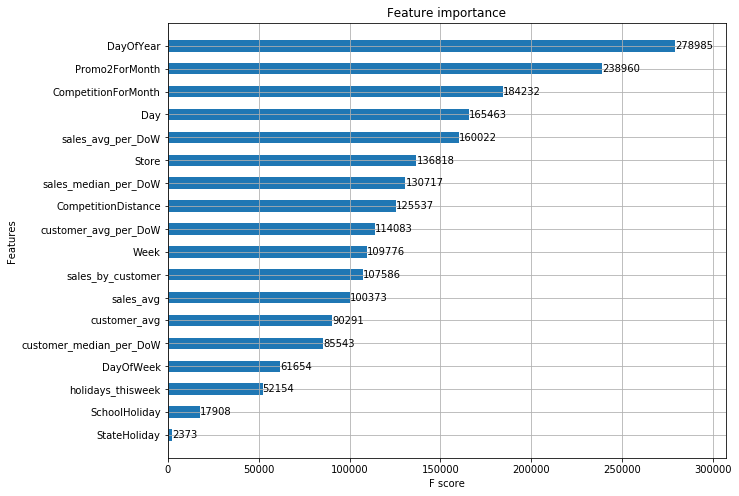

In [683]:
### plot feature importance
fig,ax = plt.subplots(figsize=(10,8))
plot_importance(gbm,height=0.5,ax=ax,max_num_features=64)
plt.show()

In [684]:
gbm.save_model('xgb-log-9.model')
dtest = xgb.DMatrix(test_set_X)
dtest.save_binary('dtest-xg-9.buffer')

In [685]:
test_xgb_pred = np.expm1(gbm.predict(dtest))

In [686]:
# 整理提交格式
test_df_open = test_df[test_df.Open==1].reset_index().join(pd.DataFrame({'Sales':test_xgb_pred}), how='left')[['Id','Sales']]
test_submission = test_df.copy()
test_submission = pd.merge(test_submission, test_df_open, how='left', on='Id')[['Id','Sales']]
test_submission.loc[test_submission['Sales'].isnull(), 'Sales'] = 0
test_submission['Sales'] = test_submission['Sales'].astype(int)
test_submission = test_submission.sort_values('Id')
test_submission.to_csv('submission_xgb_9.csv', index=False)
print("Predictions saved to predictions/xgboost-log-9.csv")

Predictions saved to predictions/xgboost-log-9.csv


### 模型10

In [140]:
params = {'objective': 'reg:linear',
          'booster': 'gbtree',
          'eta': 0.03, 
          'max_depth': 10, 
          'subsample': 0.9, 
          'colsample_bytree': 0.5, 
          'silent':1, 
          'seed': 17
         }
num_boost_round = 3000
dtrain = xgb.DMatrix(train_set_X, train_set_y)
dvalid = xgb.DMatrix(valid_set_X, valid_set_y)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, 
                early_stopping_rounds=100, feval=rmspe_score_xg, 
                verbose_eval=True)

[0]	train-rmse:8.01983	eval-rmse:8.04214	train-rmspe:0.999808	eval-rmspe:0.999814
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.77975	eval-rmse:7.80173	train-rmspe:0.99971	eval-rmspe:0.999718
[2]	train-rmse:7.54654	eval-rmse:7.56861	train-rmspe:0.999591	eval-rmspe:0.999602
[3]	train-rmse:7.32076	eval-rmse:7.34309	train-rmspe:0.999443	eval-rmspe:0.999459
[4]	train-rmse:7.10136	eval-rmse:7.12355	train-rmspe:0.999268	eval-rmspe:0.999289
[5]	train-rmse:6.8885	eval-rmse:6.91079	train-rmspe:0.999057	eval-rmspe:0.999084
[6]	train-rmse:6.68221	eval-rmse:6.70457	train-rmspe:0.998805	eval-rmspe:0.998839
[7]	train-rmse:6.48229	eval-rmse:6.50445	train-rmspe:0.998504	eval-rmspe:0.998546
[8]	train-rmse:6.28803	eval-rmse:6.3103	train-rmspe:0.998153	eval-rmspe:0.998205
[9]	train-rmse:6.09997	eval-rmse:6.12093	train-rmspe:0.997735	eval-rmspe:0.997796
[10]	train-rmse:5.91758	eval-rmse:5.9

[97]	train-rmse:0.447397	eval-rmse:0.442015	train-rmspe:0.36551	eval-rmspe:0.347601
[98]	train-rmse:0.435423	eval-rmse:0.429691	train-rmspe:0.35843	eval-rmspe:0.339699
[99]	train-rmse:0.423922	eval-rmse:0.417991	train-rmspe:0.351667	eval-rmspe:0.3321
[100]	train-rmse:0.412819	eval-rmse:0.406914	train-rmspe:0.345073	eval-rmspe:0.324855
[101]	train-rmse:0.402093	eval-rmse:0.395638	train-rmspe:0.338749	eval-rmspe:0.317386
[102]	train-rmse:0.391615	eval-rmse:0.384913	train-rmspe:0.332522	eval-rmspe:0.310262
[103]	train-rmse:0.381274	eval-rmse:0.374685	train-rmspe:0.32632	eval-rmspe:0.303419
[104]	train-rmse:0.371451	eval-rmse:0.364965	train-rmspe:0.320427	eval-rmspe:0.296828
[105]	train-rmse:0.361982	eval-rmse:0.35559	train-rmspe:0.314761	eval-rmspe:0.290441
[106]	train-rmse:0.352668	eval-rmse:0.346288	train-rmspe:0.309156	eval-rmspe:0.284065
[107]	train-rmse:0.343824	eval-rmse:0.337465	train-rmspe:0.303542	eval-rmspe:0.277948
[108]	train-rmse:0.335302	eval-rmse:0.329029	train-rmspe:0.2984

[193]	train-rmse:0.12708	eval-rmse:0.13744	train-rmspe:0.182704	eval-rmspe:0.143683
[194]	train-rmse:0.126841	eval-rmse:0.13746	train-rmspe:0.182568	eval-rmspe:0.143882
[195]	train-rmse:0.126577	eval-rmse:0.137439	train-rmspe:0.181921	eval-rmspe:0.144015
[196]	train-rmse:0.126313	eval-rmse:0.137467	train-rmspe:0.181765	eval-rmspe:0.144274
[197]	train-rmse:0.126037	eval-rmse:0.137329	train-rmspe:0.181687	eval-rmspe:0.144225
[198]	train-rmse:0.125866	eval-rmse:0.137281	train-rmspe:0.18168	eval-rmspe:0.144304
[199]	train-rmse:0.125647	eval-rmse:0.137326	train-rmspe:0.181699	eval-rmspe:0.144477
[200]	train-rmse:0.125351	eval-rmse:0.137158	train-rmspe:0.181438	eval-rmspe:0.144104
[201]	train-rmse:0.125142	eval-rmse:0.137068	train-rmspe:0.180693	eval-rmspe:0.14412
[202]	train-rmse:0.124935	eval-rmse:0.136962	train-rmspe:0.180585	eval-rmspe:0.144126
[203]	train-rmse:0.124696	eval-rmse:0.13697	train-rmspe:0.180491	eval-rmspe:0.144291
[204]	train-rmse:0.124444	eval-rmse:0.136907	train-rmspe:0.1

[289]	train-rmse:0.112873	eval-rmse:0.13163	train-rmspe:0.165755	eval-rmspe:0.141493
[290]	train-rmse:0.112751	eval-rmse:0.131535	train-rmspe:0.165619	eval-rmspe:0.141401
[291]	train-rmse:0.112675	eval-rmse:0.131474	train-rmspe:0.165571	eval-rmspe:0.141342
[292]	train-rmse:0.112581	eval-rmse:0.131424	train-rmspe:0.165503	eval-rmspe:0.141334
[293]	train-rmse:0.112399	eval-rmse:0.131305	train-rmspe:0.165096	eval-rmspe:0.141204
[294]	train-rmse:0.112344	eval-rmse:0.131271	train-rmspe:0.165057	eval-rmspe:0.141168
[295]	train-rmse:0.11228	eval-rmse:0.131223	train-rmspe:0.164984	eval-rmspe:0.141131
[296]	train-rmse:0.112201	eval-rmse:0.131165	train-rmspe:0.164916	eval-rmspe:0.141067
[297]	train-rmse:0.112116	eval-rmse:0.131135	train-rmspe:0.16485	eval-rmspe:0.141059
[298]	train-rmse:0.111969	eval-rmse:0.131019	train-rmspe:0.164698	eval-rmspe:0.140918
[299]	train-rmse:0.111896	eval-rmse:0.131085	train-rmspe:0.164256	eval-rmspe:0.140981
[300]	train-rmse:0.11182	eval-rmse:0.131089	train-rmspe:0

[385]	train-rmse:0.105383	eval-rmse:0.127119	train-rmspe:0.155257	eval-rmspe:0.136713
[386]	train-rmse:0.10527	eval-rmse:0.127063	train-rmspe:0.155133	eval-rmspe:0.136653
[387]	train-rmse:0.105216	eval-rmse:0.127024	train-rmspe:0.15509	eval-rmspe:0.136592
[388]	train-rmse:0.105174	eval-rmse:0.127003	train-rmspe:0.155059	eval-rmspe:0.136571
[389]	train-rmse:0.105151	eval-rmse:0.126952	train-rmspe:0.155042	eval-rmspe:0.136504
[390]	train-rmse:0.105033	eval-rmse:0.126879	train-rmspe:0.154907	eval-rmspe:0.136418
[391]	train-rmse:0.104993	eval-rmse:0.126837	train-rmspe:0.154863	eval-rmspe:0.136372
[392]	train-rmse:0.104931	eval-rmse:0.126858	train-rmspe:0.154802	eval-rmspe:0.136399
[393]	train-rmse:0.104882	eval-rmse:0.126753	train-rmspe:0.154745	eval-rmspe:0.136242
[394]	train-rmse:0.104846	eval-rmse:0.126719	train-rmspe:0.154718	eval-rmspe:0.136207
[395]	train-rmse:0.104696	eval-rmse:0.126618	train-rmspe:0.154585	eval-rmspe:0.136086
[396]	train-rmse:0.104658	eval-rmse:0.126598	train-rmspe

[481]	train-rmse:0.101199	eval-rmse:0.124351	train-rmspe:0.149692	eval-rmspe:0.133669
[482]	train-rmse:0.101182	eval-rmse:0.12435	train-rmspe:0.149679	eval-rmspe:0.133668
[483]	train-rmse:0.101142	eval-rmse:0.124341	train-rmspe:0.14963	eval-rmspe:0.133659
[484]	train-rmse:0.101072	eval-rmse:0.124281	train-rmspe:0.149566	eval-rmspe:0.13358
[485]	train-rmse:0.101054	eval-rmse:0.124261	train-rmspe:0.149554	eval-rmspe:0.133555
[486]	train-rmse:0.101042	eval-rmse:0.124229	train-rmspe:0.149546	eval-rmspe:0.133531
[487]	train-rmse:0.101003	eval-rmse:0.124205	train-rmspe:0.149474	eval-rmspe:0.133504
[488]	train-rmse:0.100976	eval-rmse:0.12419	train-rmspe:0.14945	eval-rmspe:0.133491
[489]	train-rmse:0.100949	eval-rmse:0.124182	train-rmspe:0.149421	eval-rmspe:0.133483
[490]	train-rmse:0.10093	eval-rmse:0.124172	train-rmspe:0.149412	eval-rmspe:0.133473
[491]	train-rmse:0.1009	eval-rmse:0.12417	train-rmspe:0.149373	eval-rmspe:0.133471
[492]	train-rmse:0.100836	eval-rmse:0.12414	train-rmspe:0.14932

[577]	train-rmse:0.097817	eval-rmse:0.122484	train-rmspe:0.146201	eval-rmspe:0.131645
[578]	train-rmse:0.097767	eval-rmse:0.122483	train-rmspe:0.146125	eval-rmspe:0.131632
[579]	train-rmse:0.097758	eval-rmse:0.12248	train-rmspe:0.146121	eval-rmspe:0.131638
[580]	train-rmse:0.09774	eval-rmse:0.12248	train-rmspe:0.143772	eval-rmspe:0.131638
[581]	train-rmse:0.097713	eval-rmse:0.122459	train-rmspe:0.14371	eval-rmspe:0.131613
[582]	train-rmse:0.097697	eval-rmse:0.122438	train-rmspe:0.143694	eval-rmspe:0.13159
[583]	train-rmse:0.097672	eval-rmse:0.122431	train-rmspe:0.14365	eval-rmspe:0.131579
[584]	train-rmse:0.097648	eval-rmse:0.122422	train-rmspe:0.143632	eval-rmspe:0.13157
[585]	train-rmse:0.097616	eval-rmse:0.122403	train-rmspe:0.143605	eval-rmspe:0.131551
[586]	train-rmse:0.097564	eval-rmse:0.122363	train-rmspe:0.143565	eval-rmspe:0.131509
[587]	train-rmse:0.097545	eval-rmse:0.122311	train-rmspe:0.143552	eval-rmspe:0.131453
[588]	train-rmse:0.097532	eval-rmse:0.12229	train-rmspe:0.143

[673]	train-rmse:0.094883	eval-rmse:0.121036	train-rmspe:0.136183	eval-rmspe:0.130144
[674]	train-rmse:0.094865	eval-rmse:0.121031	train-rmspe:0.13617	eval-rmspe:0.130139
[675]	train-rmse:0.094841	eval-rmse:0.121007	train-rmspe:0.136149	eval-rmspe:0.130111
[676]	train-rmse:0.094813	eval-rmse:0.120994	train-rmspe:0.136121	eval-rmspe:0.130101
[677]	train-rmse:0.094782	eval-rmse:0.120985	train-rmspe:0.136082	eval-rmspe:0.130086
[678]	train-rmse:0.094724	eval-rmse:0.120944	train-rmspe:0.13606	eval-rmspe:0.130042
[679]	train-rmse:0.094701	eval-rmse:0.120946	train-rmspe:0.136042	eval-rmspe:0.130046
[680]	train-rmse:0.094665	eval-rmse:0.120927	train-rmspe:0.136016	eval-rmspe:0.130025
[681]	train-rmse:0.094624	eval-rmse:0.120897	train-rmspe:0.136015	eval-rmspe:0.129994
[682]	train-rmse:0.094601	eval-rmse:0.12089	train-rmspe:0.13594	eval-rmspe:0.129983
[683]	train-rmse:0.094579	eval-rmse:0.120855	train-rmspe:0.135924	eval-rmspe:0.129942
[684]	train-rmse:0.094531	eval-rmse:0.120826	train-rmspe:0

[769]	train-rmse:0.092609	eval-rmse:0.120078	train-rmspe:0.131496	eval-rmspe:0.129139
[770]	train-rmse:0.092591	eval-rmse:0.120049	train-rmspe:0.131483	eval-rmspe:0.129108
[771]	train-rmse:0.092557	eval-rmse:0.120027	train-rmspe:0.131466	eval-rmspe:0.129083
[772]	train-rmse:0.092543	eval-rmse:0.120027	train-rmspe:0.129696	eval-rmspe:0.129083
[773]	train-rmse:0.09252	eval-rmse:0.12003	train-rmspe:0.12968	eval-rmspe:0.129098
[774]	train-rmse:0.092501	eval-rmse:0.120068	train-rmspe:0.129664	eval-rmspe:0.12914
[775]	train-rmse:0.092486	eval-rmse:0.12005	train-rmspe:0.129626	eval-rmspe:0.129118
[776]	train-rmse:0.092448	eval-rmse:0.120026	train-rmspe:0.129587	eval-rmspe:0.129092
[777]	train-rmse:0.092432	eval-rmse:0.120023	train-rmspe:0.129574	eval-rmspe:0.129089
[778]	train-rmse:0.092416	eval-rmse:0.120021	train-rmspe:0.129546	eval-rmspe:0.129087
[779]	train-rmse:0.092396	eval-rmse:0.120018	train-rmspe:0.129528	eval-rmspe:0.129084
[780]	train-rmse:0.092379	eval-rmse:0.120018	train-rmspe:0.

[865]	train-rmse:0.090429	eval-rmse:0.119404	train-rmspe:0.122139	eval-rmspe:0.128454
[866]	train-rmse:0.090393	eval-rmse:0.119384	train-rmspe:0.12022	eval-rmspe:0.128432
[867]	train-rmse:0.090378	eval-rmse:0.119378	train-rmspe:0.120207	eval-rmspe:0.128424
[868]	train-rmse:0.090354	eval-rmse:0.119366	train-rmspe:0.120159	eval-rmspe:0.128413
[869]	train-rmse:0.090295	eval-rmse:0.11933	train-rmspe:0.120105	eval-rmspe:0.128372
[870]	train-rmse:0.090263	eval-rmse:0.119311	train-rmspe:0.120062	eval-rmspe:0.128354
[871]	train-rmse:0.09025	eval-rmse:0.11931	train-rmspe:0.120052	eval-rmspe:0.128349
[872]	train-rmse:0.090241	eval-rmse:0.119309	train-rmspe:0.120044	eval-rmspe:0.128347
[873]	train-rmse:0.090225	eval-rmse:0.119304	train-rmspe:0.120031	eval-rmspe:0.128341
[874]	train-rmse:0.090218	eval-rmse:0.119326	train-rmspe:0.120026	eval-rmspe:0.128357
[875]	train-rmse:0.09018	eval-rmse:0.119304	train-rmspe:0.119984	eval-rmspe:0.128332
[876]	train-rmse:0.090161	eval-rmse:0.119307	train-rmspe:0.

[961]	train-rmse:0.088451	eval-rmse:0.118845	train-rmspe:0.114722	eval-rmspe:0.127886
[962]	train-rmse:0.08843	eval-rmse:0.118833	train-rmspe:0.114689	eval-rmspe:0.127873
[963]	train-rmse:0.088414	eval-rmse:0.118901	train-rmspe:0.114674	eval-rmspe:0.127954
[964]	train-rmse:0.088401	eval-rmse:0.118892	train-rmspe:0.114653	eval-rmspe:0.127945
[965]	train-rmse:0.088377	eval-rmse:0.11888	train-rmspe:0.11462	eval-rmspe:0.127932
[966]	train-rmse:0.088371	eval-rmse:0.118882	train-rmspe:0.114616	eval-rmspe:0.127934
[967]	train-rmse:0.088354	eval-rmse:0.118877	train-rmspe:0.114602	eval-rmspe:0.127931
[968]	train-rmse:0.088331	eval-rmse:0.118827	train-rmspe:0.114565	eval-rmspe:0.127879
[969]	train-rmse:0.08831	eval-rmse:0.118813	train-rmspe:0.114528	eval-rmspe:0.127862
[970]	train-rmse:0.088292	eval-rmse:0.118812	train-rmspe:0.114511	eval-rmspe:0.127863
[971]	train-rmse:0.088269	eval-rmse:0.118799	train-rmspe:0.11449	eval-rmspe:0.127847
[972]	train-rmse:0.088253	eval-rmse:0.118788	train-rmspe:0.

[1057]	train-rmse:0.086672	eval-rmse:0.118319	train-rmspe:0.110277	eval-rmspe:0.127337
[1058]	train-rmse:0.086659	eval-rmse:0.118314	train-rmspe:0.110244	eval-rmspe:0.127331
[1059]	train-rmse:0.086641	eval-rmse:0.118315	train-rmspe:0.110226	eval-rmspe:0.127333
[1060]	train-rmse:0.086626	eval-rmse:0.118315	train-rmspe:0.110201	eval-rmspe:0.127334
[1061]	train-rmse:0.086613	eval-rmse:0.118329	train-rmspe:0.110187	eval-rmspe:0.127346
[1062]	train-rmse:0.0866	eval-rmse:0.118326	train-rmspe:0.110176	eval-rmspe:0.127342
[1063]	train-rmse:0.086587	eval-rmse:0.118323	train-rmspe:0.110158	eval-rmspe:0.127336
[1064]	train-rmse:0.08657	eval-rmse:0.118311	train-rmspe:0.110144	eval-rmspe:0.127324
[1065]	train-rmse:0.086562	eval-rmse:0.118311	train-rmspe:0.110142	eval-rmspe:0.127324
[1066]	train-rmse:0.086541	eval-rmse:0.11831	train-rmspe:0.110124	eval-rmspe:0.127322
[1067]	train-rmse:0.086523	eval-rmse:0.118303	train-rmspe:0.110103	eval-rmspe:0.127316
[1068]	train-rmse:0.086509	eval-rmse:0.118296	t

[1152]	train-rmse:0.085191	eval-rmse:0.117876	train-rmspe:0.10536	eval-rmspe:0.126853
[1153]	train-rmse:0.085184	eval-rmse:0.117874	train-rmspe:0.105218	eval-rmspe:0.126852
[1154]	train-rmse:0.085174	eval-rmse:0.117882	train-rmspe:0.105204	eval-rmspe:0.126864
[1155]	train-rmse:0.085168	eval-rmse:0.117866	train-rmspe:0.105198	eval-rmspe:0.126846
[1156]	train-rmse:0.08515	eval-rmse:0.117867	train-rmspe:0.105172	eval-rmspe:0.126848
[1157]	train-rmse:0.085135	eval-rmse:0.117883	train-rmspe:0.105155	eval-rmspe:0.126864
[1158]	train-rmse:0.085104	eval-rmse:0.117862	train-rmspe:0.105126	eval-rmspe:0.126841
[1159]	train-rmse:0.085097	eval-rmse:0.117859	train-rmspe:0.105118	eval-rmspe:0.126837
[1160]	train-rmse:0.085082	eval-rmse:0.117854	train-rmspe:0.105062	eval-rmspe:0.126833
[1161]	train-rmse:0.085047	eval-rmse:0.117848	train-rmspe:0.10424	eval-rmspe:0.126826
[1162]	train-rmse:0.08503	eval-rmse:0.117845	train-rmspe:0.104223	eval-rmspe:0.126823
[1163]	train-rmse:0.085021	eval-rmse:0.117846	t

[1247]	train-rmse:0.083669	eval-rmse:0.117412	train-rmspe:0.101157	eval-rmspe:0.126357
[1248]	train-rmse:0.083658	eval-rmse:0.117378	train-rmspe:0.101146	eval-rmspe:0.126293
[1249]	train-rmse:0.083647	eval-rmse:0.117378	train-rmspe:0.100589	eval-rmspe:0.126294
[1250]	train-rmse:0.083639	eval-rmse:0.117365	train-rmspe:0.100582	eval-rmspe:0.126272
[1251]	train-rmse:0.083625	eval-rmse:0.117369	train-rmspe:0.10057	eval-rmspe:0.126277
[1252]	train-rmse:0.083615	eval-rmse:0.117359	train-rmspe:0.100559	eval-rmspe:0.12627
[1253]	train-rmse:0.083597	eval-rmse:0.117354	train-rmspe:0.100538	eval-rmspe:0.126264
[1254]	train-rmse:0.083571	eval-rmse:0.117342	train-rmspe:0.100514	eval-rmspe:0.126251
[1255]	train-rmse:0.08356	eval-rmse:0.11733	train-rmspe:0.10042	eval-rmspe:0.126226
[1256]	train-rmse:0.083529	eval-rmse:0.117314	train-rmspe:0.100391	eval-rmspe:0.126208
[1257]	train-rmse:0.083513	eval-rmse:0.117281	train-rmspe:0.10027	eval-rmspe:0.126164
[1258]	train-rmse:0.083496	eval-rmse:0.117273	tra

[1342]	train-rmse:0.082333	eval-rmse:0.117045	train-rmspe:0.09736	eval-rmspe:0.125936
[1343]	train-rmse:0.082317	eval-rmse:0.117048	train-rmspe:0.097327	eval-rmspe:0.125939
[1344]	train-rmse:0.0823	eval-rmse:0.117042	train-rmspe:0.097307	eval-rmspe:0.125932
[1345]	train-rmse:0.082287	eval-rmse:0.117038	train-rmspe:0.097259	eval-rmspe:0.125929
[1346]	train-rmse:0.08227	eval-rmse:0.117032	train-rmspe:0.097237	eval-rmspe:0.125921
[1347]	train-rmse:0.082255	eval-rmse:0.117026	train-rmspe:0.097222	eval-rmspe:0.125916
[1348]	train-rmse:0.082238	eval-rmse:0.117023	train-rmspe:0.097206	eval-rmspe:0.125914
[1349]	train-rmse:0.082217	eval-rmse:0.117016	train-rmspe:0.097183	eval-rmspe:0.125909
[1350]	train-rmse:0.082206	eval-rmse:0.117015	train-rmspe:0.097174	eval-rmspe:0.125911
[1351]	train-rmse:0.082197	eval-rmse:0.117014	train-rmspe:0.097154	eval-rmspe:0.125908
[1352]	train-rmse:0.082183	eval-rmse:0.117009	train-rmspe:0.097135	eval-rmspe:0.125904
[1353]	train-rmse:0.082174	eval-rmse:0.11701	tr

[1437]	train-rmse:0.081013	eval-rmse:0.116647	train-rmspe:0.094684	eval-rmspe:0.12556
[1438]	train-rmse:0.081001	eval-rmse:0.116665	train-rmspe:0.094639	eval-rmspe:0.125581
[1439]	train-rmse:0.080988	eval-rmse:0.116664	train-rmspe:0.094623	eval-rmspe:0.125579
[1440]	train-rmse:0.080979	eval-rmse:0.116662	train-rmspe:0.094615	eval-rmspe:0.125578
[1441]	train-rmse:0.080965	eval-rmse:0.116659	train-rmspe:0.094598	eval-rmspe:0.125575
[1442]	train-rmse:0.080956	eval-rmse:0.116657	train-rmspe:0.094589	eval-rmspe:0.125572
[1443]	train-rmse:0.080936	eval-rmse:0.116642	train-rmspe:0.09457	eval-rmspe:0.125555
[1444]	train-rmse:0.080923	eval-rmse:0.116624	train-rmspe:0.094554	eval-rmspe:0.125526
[1445]	train-rmse:0.080899	eval-rmse:0.116617	train-rmspe:0.094508	eval-rmspe:0.125519
[1446]	train-rmse:0.080892	eval-rmse:0.116615	train-rmspe:0.094501	eval-rmspe:0.125518
[1447]	train-rmse:0.08088	eval-rmse:0.116615	train-rmspe:0.094487	eval-rmspe:0.125517
[1448]	train-rmse:0.080865	eval-rmse:0.116607	

[1532]	train-rmse:0.079827	eval-rmse:0.116506	train-rmspe:0.091971	eval-rmspe:0.125433
[1533]	train-rmse:0.079817	eval-rmse:0.116519	train-rmspe:0.091963	eval-rmspe:0.125448
[1534]	train-rmse:0.079799	eval-rmse:0.11651	train-rmspe:0.091941	eval-rmspe:0.125441
[1535]	train-rmse:0.079788	eval-rmse:0.116528	train-rmspe:0.091919	eval-rmspe:0.12546
[1536]	train-rmse:0.079777	eval-rmse:0.116533	train-rmspe:0.091907	eval-rmspe:0.125464
[1537]	train-rmse:0.079769	eval-rmse:0.116533	train-rmspe:0.091897	eval-rmspe:0.125463
[1538]	train-rmse:0.079759	eval-rmse:0.116534	train-rmspe:0.091878	eval-rmspe:0.125463
[1539]	train-rmse:0.079744	eval-rmse:0.116528	train-rmspe:0.091843	eval-rmspe:0.125455
[1540]	train-rmse:0.079732	eval-rmse:0.116526	train-rmspe:0.091824	eval-rmspe:0.125453
[1541]	train-rmse:0.079717	eval-rmse:0.116531	train-rmspe:0.091811	eval-rmspe:0.125459
[1542]	train-rmse:0.079709	eval-rmse:0.116537	train-rmspe:0.091786	eval-rmspe:0.125467
[1543]	train-rmse:0.0797	eval-rmse:0.116536	t

[1627]	train-rmse:0.078712	eval-rmse:0.116369	train-rmspe:0.089855	eval-rmspe:0.125306
[1628]	train-rmse:0.078701	eval-rmse:0.116366	train-rmspe:0.089841	eval-rmspe:0.125302
[1629]	train-rmse:0.078691	eval-rmse:0.116371	train-rmspe:0.089831	eval-rmspe:0.125307
[1630]	train-rmse:0.078669	eval-rmse:0.116359	train-rmspe:0.089807	eval-rmspe:0.125294
[1631]	train-rmse:0.078662	eval-rmse:0.116359	train-rmspe:0.089799	eval-rmspe:0.125294
[1632]	train-rmse:0.078656	eval-rmse:0.116356	train-rmspe:0.089757	eval-rmspe:0.125291
[1633]	train-rmse:0.078643	eval-rmse:0.116362	train-rmspe:0.089629	eval-rmspe:0.125293
[1634]	train-rmse:0.078636	eval-rmse:0.11636	train-rmspe:0.089578	eval-rmspe:0.125291
[1635]	train-rmse:0.078608	eval-rmse:0.116349	train-rmspe:0.08955	eval-rmspe:0.125282
[1636]	train-rmse:0.078601	eval-rmse:0.116349	train-rmspe:0.089542	eval-rmspe:0.125281
[1637]	train-rmse:0.078589	eval-rmse:0.116343	train-rmspe:0.089503	eval-rmspe:0.125274
[1638]	train-rmse:0.078579	eval-rmse:0.116342

[1722]	train-rmse:0.077643	eval-rmse:0.116215	train-rmspe:0.087655	eval-rmspe:0.125145
[1723]	train-rmse:0.077635	eval-rmse:0.116213	train-rmspe:0.087647	eval-rmspe:0.125143
[1724]	train-rmse:0.077613	eval-rmse:0.116197	train-rmspe:0.087626	eval-rmspe:0.125126
[1725]	train-rmse:0.077606	eval-rmse:0.116198	train-rmspe:0.087613	eval-rmspe:0.125127
[1726]	train-rmse:0.077597	eval-rmse:0.116196	train-rmspe:0.087576	eval-rmspe:0.125125
[1727]	train-rmse:0.077592	eval-rmse:0.116197	train-rmspe:0.087571	eval-rmspe:0.125125
[1728]	train-rmse:0.077574	eval-rmse:0.116194	train-rmspe:0.087537	eval-rmspe:0.125122
[1729]	train-rmse:0.077564	eval-rmse:0.116198	train-rmspe:0.087526	eval-rmspe:0.125127
[1730]	train-rmse:0.077548	eval-rmse:0.116191	train-rmspe:0.087509	eval-rmspe:0.12512
[1731]	train-rmse:0.077536	eval-rmse:0.116185	train-rmspe:0.087495	eval-rmspe:0.125112
[1732]	train-rmse:0.077519	eval-rmse:0.116178	train-rmspe:0.087472	eval-rmspe:0.125105
[1733]	train-rmse:0.077511	eval-rmse:0.11618

[1817]	train-rmse:0.076667	eval-rmse:0.115964	train-rmspe:0.086014	eval-rmspe:0.124873
[1818]	train-rmse:0.076655	eval-rmse:0.115963	train-rmspe:0.085998	eval-rmspe:0.124871
[1819]	train-rmse:0.076647	eval-rmse:0.115963	train-rmspe:0.08599	eval-rmspe:0.124873
[1820]	train-rmse:0.076639	eval-rmse:0.115963	train-rmspe:0.085978	eval-rmspe:0.124874
[1821]	train-rmse:0.076632	eval-rmse:0.115958	train-rmspe:0.085971	eval-rmspe:0.124866
[1822]	train-rmse:0.076622	eval-rmse:0.115961	train-rmspe:0.085959	eval-rmspe:0.12487
[1823]	train-rmse:0.076618	eval-rmse:0.115959	train-rmspe:0.085955	eval-rmspe:0.124867
[1824]	train-rmse:0.076609	eval-rmse:0.115961	train-rmspe:0.085943	eval-rmspe:0.124867
[1825]	train-rmse:0.076601	eval-rmse:0.115961	train-rmspe:0.085935	eval-rmspe:0.124867
[1826]	train-rmse:0.076594	eval-rmse:0.115961	train-rmspe:0.085927	eval-rmspe:0.124867
[1827]	train-rmse:0.076582	eval-rmse:0.115953	train-rmspe:0.085913	eval-rmspe:0.124859
[1828]	train-rmse:0.076573	eval-rmse:0.115958

[1912]	train-rmse:0.075696	eval-rmse:0.115759	train-rmspe:0.084302	eval-rmspe:0.124658
[1913]	train-rmse:0.075678	eval-rmse:0.115753	train-rmspe:0.084284	eval-rmspe:0.124654
[1914]	train-rmse:0.075665	eval-rmse:0.115753	train-rmspe:0.08426	eval-rmspe:0.124654
[1915]	train-rmse:0.075653	eval-rmse:0.115749	train-rmspe:0.084239	eval-rmspe:0.124648
[1916]	train-rmse:0.075645	eval-rmse:0.115749	train-rmspe:0.084215	eval-rmspe:0.124648
[1917]	train-rmse:0.075642	eval-rmse:0.115746	train-rmspe:0.084213	eval-rmspe:0.124645
[1918]	train-rmse:0.07563	eval-rmse:0.115746	train-rmspe:0.084117	eval-rmspe:0.124644
[1919]	train-rmse:0.075627	eval-rmse:0.115746	train-rmspe:0.084113	eval-rmspe:0.124643
[1920]	train-rmse:0.075617	eval-rmse:0.115745	train-rmspe:0.084082	eval-rmspe:0.124642
[1921]	train-rmse:0.075609	eval-rmse:0.115748	train-rmspe:0.084075	eval-rmspe:0.124646
[1922]	train-rmse:0.0756	eval-rmse:0.11575	train-rmspe:0.08406	eval-rmspe:0.124649
[1923]	train-rmse:0.075593	eval-rmse:0.115749	tra

[2007]	train-rmse:0.074777	eval-rmse:0.115618	train-rmspe:0.082722	eval-rmspe:0.124533
[2008]	train-rmse:0.07477	eval-rmse:0.11562	train-rmspe:0.082715	eval-rmspe:0.124537
[2009]	train-rmse:0.07476	eval-rmse:0.11562	train-rmspe:0.0827	eval-rmspe:0.124536
[2010]	train-rmse:0.074753	eval-rmse:0.115621	train-rmspe:0.082693	eval-rmspe:0.124539
[2011]	train-rmse:0.074744	eval-rmse:0.115621	train-rmspe:0.082682	eval-rmspe:0.124539
[2012]	train-rmse:0.074734	eval-rmse:0.115617	train-rmspe:0.082672	eval-rmspe:0.124535
[2013]	train-rmse:0.074723	eval-rmse:0.115614	train-rmspe:0.082661	eval-rmspe:0.124533
[2014]	train-rmse:0.074715	eval-rmse:0.115613	train-rmspe:0.082649	eval-rmspe:0.124531
[2015]	train-rmse:0.074708	eval-rmse:0.115613	train-rmspe:0.082643	eval-rmspe:0.124532
[2016]	train-rmse:0.074692	eval-rmse:0.115607	train-rmspe:0.082629	eval-rmspe:0.124524
[2017]	train-rmse:0.074678	eval-rmse:0.115602	train-rmspe:0.082613	eval-rmspe:0.124517
[2018]	train-rmse:0.074661	eval-rmse:0.115597	tra

[2102]	train-rmse:0.073887	eval-rmse:0.115489	train-rmspe:0.081258	eval-rmspe:0.124412
[2103]	train-rmse:0.073878	eval-rmse:0.115479	train-rmspe:0.081249	eval-rmspe:0.124401
[2104]	train-rmse:0.073867	eval-rmse:0.115478	train-rmspe:0.081237	eval-rmspe:0.1244
[2105]	train-rmse:0.073848	eval-rmse:0.11547	train-rmspe:0.081166	eval-rmspe:0.124393
[2106]	train-rmse:0.073833	eval-rmse:0.115468	train-rmspe:0.08114	eval-rmspe:0.124394
[2107]	train-rmse:0.073823	eval-rmse:0.115471	train-rmspe:0.081127	eval-rmspe:0.124398
[2108]	train-rmse:0.073816	eval-rmse:0.115468	train-rmspe:0.081117	eval-rmspe:0.124395
[2109]	train-rmse:0.073806	eval-rmse:0.115471	train-rmspe:0.081105	eval-rmspe:0.124398
[2110]	train-rmse:0.073802	eval-rmse:0.115473	train-rmspe:0.081101	eval-rmspe:0.124401
[2111]	train-rmse:0.073794	eval-rmse:0.115471	train-rmspe:0.081095	eval-rmspe:0.1244
[2112]	train-rmse:0.073781	eval-rmse:0.115469	train-rmspe:0.081069	eval-rmspe:0.124399
[2113]	train-rmse:0.073774	eval-rmse:0.115477	tra

[2197]	train-rmse:0.073021	eval-rmse:0.115362	train-rmspe:0.079723	eval-rmspe:0.124305
[2198]	train-rmse:0.073012	eval-rmse:0.115358	train-rmspe:0.079711	eval-rmspe:0.124299
[2199]	train-rmse:0.073006	eval-rmse:0.115355	train-rmspe:0.079704	eval-rmspe:0.124297
[2200]	train-rmse:0.073002	eval-rmse:0.115357	train-rmspe:0.0797	eval-rmspe:0.1243
[2201]	train-rmse:0.072993	eval-rmse:0.115347	train-rmspe:0.07969	eval-rmspe:0.124287
[2202]	train-rmse:0.07298	eval-rmse:0.115348	train-rmspe:0.079668	eval-rmspe:0.124287
[2203]	train-rmse:0.072971	eval-rmse:0.115346	train-rmspe:0.079659	eval-rmspe:0.124287
[2204]	train-rmse:0.072965	eval-rmse:0.115344	train-rmspe:0.079652	eval-rmspe:0.124285
[2205]	train-rmse:0.072952	eval-rmse:0.115338	train-rmspe:0.079637	eval-rmspe:0.124279
[2206]	train-rmse:0.072943	eval-rmse:0.115337	train-rmspe:0.079628	eval-rmspe:0.124279
[2207]	train-rmse:0.072939	eval-rmse:0.115337	train-rmspe:0.079624	eval-rmspe:0.124281
[2208]	train-rmse:0.072935	eval-rmse:0.115336	tra

[2292]	train-rmse:0.072208	eval-rmse:0.115242	train-rmspe:0.078477	eval-rmspe:0.124205
[2293]	train-rmse:0.0722	eval-rmse:0.115241	train-rmspe:0.078465	eval-rmspe:0.124204
[2294]	train-rmse:0.072188	eval-rmse:0.115238	train-rmspe:0.078453	eval-rmspe:0.124198
[2295]	train-rmse:0.072178	eval-rmse:0.115237	train-rmspe:0.078443	eval-rmspe:0.124197
[2296]	train-rmse:0.072173	eval-rmse:0.115236	train-rmspe:0.078434	eval-rmspe:0.124196
[2297]	train-rmse:0.072169	eval-rmse:0.115238	train-rmspe:0.078429	eval-rmspe:0.124202
[2298]	train-rmse:0.072158	eval-rmse:0.115244	train-rmspe:0.078403	eval-rmspe:0.12421
[2299]	train-rmse:0.07215	eval-rmse:0.115242	train-rmspe:0.078395	eval-rmspe:0.124207
[2300]	train-rmse:0.07214	eval-rmse:0.115238	train-rmspe:0.078386	eval-rmspe:0.124209
[2301]	train-rmse:0.072134	eval-rmse:0.115236	train-rmspe:0.078379	eval-rmspe:0.124205
[2302]	train-rmse:0.072126	eval-rmse:0.115237	train-rmspe:0.07837	eval-rmspe:0.124207
[2303]	train-rmse:0.072121	eval-rmse:0.115239	tra

[2387]	train-rmse:0.071434	eval-rmse:0.115189	train-rmspe:0.077456	eval-rmspe:0.124199
[2388]	train-rmse:0.071429	eval-rmse:0.115186	train-rmspe:0.077451	eval-rmspe:0.124198
[2389]	train-rmse:0.071423	eval-rmse:0.115184	train-rmspe:0.077444	eval-rmspe:0.124196
[2390]	train-rmse:0.071413	eval-rmse:0.115181	train-rmspe:0.077399	eval-rmspe:0.124193
[2391]	train-rmse:0.071407	eval-rmse:0.115182	train-rmspe:0.077391	eval-rmspe:0.124193
[2392]	train-rmse:0.071401	eval-rmse:0.115182	train-rmspe:0.077384	eval-rmspe:0.124194
[2393]	train-rmse:0.071392	eval-rmse:0.115187	train-rmspe:0.077351	eval-rmspe:0.124201
[2394]	train-rmse:0.071387	eval-rmse:0.115187	train-rmspe:0.077345	eval-rmspe:0.124201
[2395]	train-rmse:0.071375	eval-rmse:0.115185	train-rmspe:0.077332	eval-rmspe:0.124199
[2396]	train-rmse:0.071367	eval-rmse:0.115182	train-rmspe:0.077322	eval-rmspe:0.124196
[2397]	train-rmse:0.071356	eval-rmse:0.115177	train-rmspe:0.077312	eval-rmspe:0.12419
[2398]	train-rmse:0.071348	eval-rmse:0.11517

[2482]	train-rmse:0.070666	eval-rmse:0.115137	train-rmspe:0.076353	eval-rmspe:0.124157
[2483]	train-rmse:0.070662	eval-rmse:0.115136	train-rmspe:0.076348	eval-rmspe:0.124157
[2484]	train-rmse:0.070654	eval-rmse:0.115137	train-rmspe:0.076339	eval-rmspe:0.124158
[2485]	train-rmse:0.070648	eval-rmse:0.115134	train-rmspe:0.076331	eval-rmspe:0.124155
[2486]	train-rmse:0.07064	eval-rmse:0.115133	train-rmspe:0.076319	eval-rmspe:0.124152
[2487]	train-rmse:0.070636	eval-rmse:0.115132	train-rmspe:0.076316	eval-rmspe:0.124151
[2488]	train-rmse:0.070631	eval-rmse:0.115128	train-rmspe:0.07631	eval-rmspe:0.124148
[2489]	train-rmse:0.070622	eval-rmse:0.115129	train-rmspe:0.076299	eval-rmspe:0.124149
[2490]	train-rmse:0.070609	eval-rmse:0.115121	train-rmspe:0.076286	eval-rmspe:0.12414
[2491]	train-rmse:0.0706	eval-rmse:0.115122	train-rmspe:0.076277	eval-rmspe:0.124142
[2492]	train-rmse:0.070593	eval-rmse:0.115121	train-rmspe:0.076269	eval-rmspe:0.124141
[2493]	train-rmse:0.070582	eval-rmse:0.11512	tra

[2577]	train-rmse:0.069926	eval-rmse:0.115089	train-rmspe:0.075321	eval-rmspe:0.124134
[2578]	train-rmse:0.069919	eval-rmse:0.11509	train-rmspe:0.075312	eval-rmspe:0.124135
[2579]	train-rmse:0.069912	eval-rmse:0.11509	train-rmspe:0.075299	eval-rmspe:0.124135
[2580]	train-rmse:0.069902	eval-rmse:0.115087	train-rmspe:0.075289	eval-rmspe:0.124132
[2581]	train-rmse:0.069897	eval-rmse:0.115086	train-rmspe:0.075284	eval-rmspe:0.124131
[2582]	train-rmse:0.06989	eval-rmse:0.115083	train-rmspe:0.075277	eval-rmspe:0.124127
[2583]	train-rmse:0.069883	eval-rmse:0.115083	train-rmspe:0.07527	eval-rmspe:0.124129
[2584]	train-rmse:0.069875	eval-rmse:0.11508	train-rmspe:0.075262	eval-rmspe:0.124126
[2585]	train-rmse:0.069867	eval-rmse:0.115079	train-rmspe:0.075254	eval-rmspe:0.124124
[2586]	train-rmse:0.06986	eval-rmse:0.115078	train-rmspe:0.075247	eval-rmspe:0.124123
[2587]	train-rmse:0.069855	eval-rmse:0.115078	train-rmspe:0.075241	eval-rmspe:0.124124
[2588]	train-rmse:0.069844	eval-rmse:0.115076	tra

[2672]	train-rmse:0.06927	eval-rmse:0.115078	train-rmspe:0.074348	eval-rmspe:0.124141
[2673]	train-rmse:0.069263	eval-rmse:0.115078	train-rmspe:0.074341	eval-rmspe:0.12414
[2674]	train-rmse:0.069258	eval-rmse:0.115077	train-rmspe:0.074335	eval-rmspe:0.124139
[2675]	train-rmse:0.069251	eval-rmse:0.115078	train-rmspe:0.074326	eval-rmspe:0.124141
[2676]	train-rmse:0.069245	eval-rmse:0.115077	train-rmspe:0.074318	eval-rmspe:0.124141
[2677]	train-rmse:0.069238	eval-rmse:0.115081	train-rmspe:0.074309	eval-rmspe:0.124145
[2678]	train-rmse:0.069228	eval-rmse:0.115081	train-rmspe:0.074297	eval-rmspe:0.124145
[2679]	train-rmse:0.069224	eval-rmse:0.11508	train-rmspe:0.074291	eval-rmspe:0.124144
[2680]	train-rmse:0.069215	eval-rmse:0.115078	train-rmspe:0.074282	eval-rmspe:0.124142
[2681]	train-rmse:0.069207	eval-rmse:0.115078	train-rmspe:0.07427	eval-rmspe:0.124143
[2682]	train-rmse:0.069199	eval-rmse:0.115078	train-rmspe:0.074261	eval-rmspe:0.124142
[2683]	train-rmse:0.069192	eval-rmse:0.115085	t

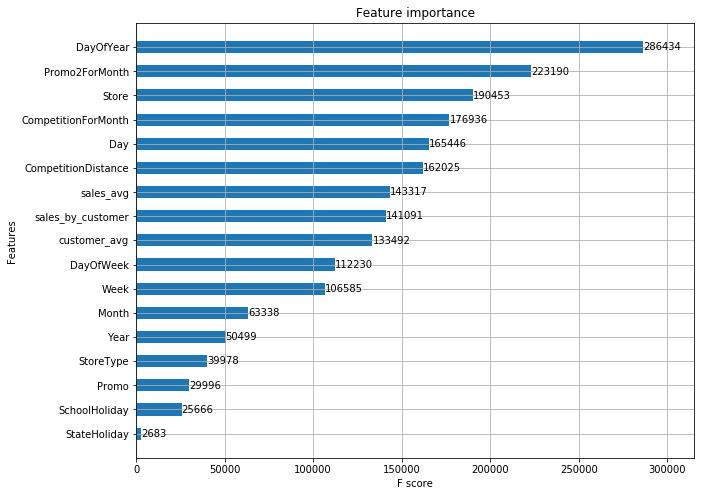

In [141]:
# plot feature importance
fig,ax = plt.subplots(figsize=(10,8))
plot_importance(gbm,height=0.5,ax=ax,max_num_features=64)
plt.show()

In [142]:
gbm.save_model('xgb-log-10.model')
dtest = xgb.DMatrix(test_set_X)
dtest.save_binary('dtest-xg-10.buffer')

In [401]:
# gbm = xgb.Booster({'nthread':4})
# gbm.load_model('xgb-log-10.model')

In [470]:
# dtrain = xgb.DMatrix(train_set_X, train_set_y)
# dvalid = xgb.DMatrix(valid_set_X, valid_set_y)

In [471]:
train_log_pred = gbm.predict(dtrain)
valid_log_pred = gbm.predict(dvalid)
print(rmspe_score(train_set_y.values, train_log_pred))
print(rmspe_score(valid_set_y.values, valid_log_pred))

0.0135043765686
0.0159376606064


In [472]:
train_pred = np.exp(train_log_pred)
valid_pred = np.exp(valid_log_pred)
print(rmspe_score(np.exp(train_set_y.values), train_pred))
print(rmspe_score(np.exp(valid_set_y.values), valid_pred))

0.131415118595
0.146411358759


In [143]:
# 预测测试集
test_xgb_pred = np.expm1(gbm.predict(dtest))

# 整理提交格式
test_df_open = test_df[test_df.Open==1].reset_index().join(pd.DataFrame({'Sales':test_xgb_pred}), how='left')[['Id','Sales']]
test_submission = test_df.copy()
test_submission = pd.merge(test_submission, test_df_open, how='left', on='Id')[['Id','Sales']]
test_submission.loc[test_submission['Sales'].isnull(), 'Sales'] = 0
test_submission['Sales'] = test_submission['Sales'].astype(int)
test_submission = test_submission.sort_values('Id')
test_submission.to_csv('submission_xgb_10.csv', index=False)
print("Predictions saved to predictions/xgboost-log-10.csv")

Predictions saved to predictions/xgboost-log-10.csv


### 模型调参
#### 所有模型当中模型7的预测性能最好，我将以此模型的特征为基准进行调参

In [53]:
# 调参对象：max_depth, subsample, colsample_bytree
# 共18个组合，其中max_depth为[9,10,11，subsample为[0.7,0.8,0.9]，colsample_bytree为[0.5,0.6]

model_dict = {} # 用字典存储每个模型的参数
num_boost_round = 1500 # 从之前的模型训练情况来看，1500次迭代后模型提升不多，甚至可能会过拟合
model_num = 1 # 调参模型编号
for max_depth in range(9, 12):
    for subsample in range(7, 10):
        for colsample_bytree in range(5,7):
            params = {'objective': 'reg:linear', 
                      'booster': 'gbtree', 
                      'eta': 0.03, 
                      'silent': 1, 
                      'seed': 17
                     }
            params['max_depth'] = max_depth
            params['subsample'] = subsample * 0.1
            params['colsample_bytree'] = colsample_bytree * 0.1

            print("train {} xgboost model".format(model_num))
            dtrain = xgb.DMatrix(train_set_X, train_set_y)
            dvalid = xgb.DMatrix(valid_set_X, valid_set_y)
            dtest = xgb.DMatrix(test_set_X)

            watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
            gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
                            early_stopping_rounds=100, feval=rmspe_score_xg, \
                            verbose_eval=50)

            print('performing validation')
            valid_pred = np.exp(gbm.predict(dvalid))
            error = rmspe_score(np.exp(valid_set_y.values), valid_pred)
            print('RMSPE: {:.6f}'.format(error))

            params['valid_error'] = error
            model_dict[str(model_num)] = params
            
            print('Make predictions on the test set')
            test_pred = np.exp(gbm.predict(dtest))

            # valid output
            valid_result = pd.DataFrame(data={"Sales": valid_pred, "True": np.exp(valid_set_y.values)})
            valid_result.to_csv('tuning_output/valid_prediction/valid_7_{}.csv'.format(model_num), index=False)
            
            # test output
            test_result = pd.DataFrame({'Id': test_set_X.index, 'Sales': test_pred})
            test_df_open = test_df[test_df.Open==1].reset_index().join(pd.DataFrame({'Sales':test_result.Sales}), how='left')[['Id','Sales']]
            test_submission = test_df.copy()
            test_submission = pd.merge(test_submission, test_df_open, how='left', on='Id')[['Id','Sales']]
            test_submission.loc[test_submission['Sales'].isnull(), 'Sales'] = 0
            test_submission['Sales'] = test_submission['Sales'].astype(int)
            test_submission = test_submission.sort_values('Id')
            test_submission.to_csv('tuning_output/test_prediction/xgb_7_{}.csv'.format(model_num), index=False)
 
            model_num += 1
    
models_df = pd.DataFrame(model_dict).T
models_df.to_csv('tuning_output/xgb_param_tuning.csv')

train 1 xgboost model
[0]	train-rmse:8.01947	eval-rmse:8.04189	train-rmspe:0.999809	eval-rmspe:0.999815
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[50]	train-rmse:1.75615	eval-rmse:1.78148	train-rmspe:0.823952	eval-rmspe:0.828215
[100]	train-rmse:0.405006	eval-rmse:0.418767	train-rmspe:0.342667	eval-rmspe:0.333832
[150]	train-rmse:0.148188	eval-rmse:0.158215	train-rmspe:0.19473	eval-rmspe:0.145925
[200]	train-rmse:0.117231	eval-rmse:0.130739	train-rmspe:0.173691	eval-rmspe:0.131381
[250]	train-rmse:0.111744	eval-rmse:0.128158	train-rmspe:0.163877	eval-rmspe:0.131376
[300]	train-rmse:0.108428	eval-rmse:0.126453	train-rmspe:0.154596	eval-rmspe:0.130295
[350]	train-rmse:0.105858	eval-rmse:0.125166	train-rmspe:0.151074	eval-rmspe:0.129134
[400]	train-rmse:0.103781	eval-rmse:0.123888	train-rmspe:0.148216	eval-rmspe:0.12798
[450]	train-rmse:0.102027	eval-rmse:0.122935	train-rmspe:0.14372	ev

[1350]	train-rmse:0.087171	eval-rmse:0.115517	train-rmspe:0.107228	eval-rmspe:0.119732
[1400]	train-rmse:0.086645	eval-rmse:0.11532	train-rmspe:0.105476	eval-rmspe:0.11956
[1450]	train-rmse:0.086163	eval-rmse:0.115172	train-rmspe:0.104862	eval-rmspe:0.119416
[1499]	train-rmse:0.085726	eval-rmse:0.11501	train-rmspe:0.10317	eval-rmspe:0.119265
performing validation
RMSPE: 0.119239
Make predictions on the test set
train 4 xgboost model
[0]	train-rmse:8.01947	eval-rmse:8.04189	train-rmspe:0.999809	eval-rmspe:0.999815
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[50]	train-rmse:1.75558	eval-rmse:1.77879	train-rmspe:0.824096	eval-rmspe:0.827958
[100]	train-rmse:0.403474	eval-rmse:0.416145	train-rmspe:0.342177	eval-rmspe:0.332413
[150]	train-rmse:0.145846	eval-rmse:0.15881	train-rmspe:0.194023	eval-rmspe:0.146289
[200]	train-rmse:0.115188	eval-rmse:0.131222	train-rmspe:0.17607	eval-rmspe:0.131

[1100]	train-rmse:0.089194	eval-rmse:0.117666	train-rmspe:0.11147	eval-rmspe:0.122896
[1150]	train-rmse:0.088551	eval-rmse:0.117415	train-rmspe:0.110269	eval-rmspe:0.122717
[1200]	train-rmse:0.087913	eval-rmse:0.117187	train-rmspe:0.107481	eval-rmspe:0.122522
[1250]	train-rmse:0.087312	eval-rmse:0.11699	train-rmspe:0.105688	eval-rmspe:0.122322
[1300]	train-rmse:0.086778	eval-rmse:0.116817	train-rmspe:0.104123	eval-rmspe:0.122196
[1350]	train-rmse:0.086251	eval-rmse:0.116694	train-rmspe:0.103437	eval-rmspe:0.122104
[1400]	train-rmse:0.0857	eval-rmse:0.116507	train-rmspe:0.102372	eval-rmspe:0.121918
[1450]	train-rmse:0.085189	eval-rmse:0.116372	train-rmspe:0.100326	eval-rmspe:0.121819
[1499]	train-rmse:0.084702	eval-rmse:0.116224	train-rmspe:0.098957	eval-rmspe:0.121647
performing validation
RMSPE: 0.121620
Make predictions on the test set
train 7 xgboost model
[0]	train-rmse:8.01947	eval-rmse:8.04189	train-rmspe:0.999809	eval-rmspe:0.999815
Multiple eval metrics have been passed: 'eval-

[850]	train-rmse:0.086751	eval-rmse:0.11656	train-rmspe:0.101322	eval-rmspe:0.121496
[900]	train-rmse:0.085856	eval-rmse:0.116277	train-rmspe:0.099081	eval-rmspe:0.121262
[950]	train-rmse:0.085049	eval-rmse:0.116029	train-rmspe:0.097772	eval-rmspe:0.120999
[1000]	train-rmse:0.084249	eval-rmse:0.115783	train-rmspe:0.095967	eval-rmspe:0.12077
[1050]	train-rmse:0.083552	eval-rmse:0.115586	train-rmspe:0.094891	eval-rmspe:0.120656
[1100]	train-rmse:0.082901	eval-rmse:0.115465	train-rmspe:0.093777	eval-rmspe:0.120564
[1150]	train-rmse:0.082185	eval-rmse:0.115316	train-rmspe:0.092273	eval-rmspe:0.120471
[1200]	train-rmse:0.081553	eval-rmse:0.115227	train-rmspe:0.090965	eval-rmspe:0.120386
[1250]	train-rmse:0.080946	eval-rmse:0.115076	train-rmspe:0.089756	eval-rmspe:0.120262
[1300]	train-rmse:0.080353	eval-rmse:0.115005	train-rmspe:0.088707	eval-rmspe:0.120215
[1350]	train-rmse:0.079759	eval-rmse:0.114959	train-rmspe:0.087864	eval-rmspe:0.120204
[1400]	train-rmse:0.079193	eval-rmse:0.114869	tr

[600]	train-rmse:0.090953	eval-rmse:0.117972	train-rmspe:0.116144	eval-rmspe:0.122549
[650]	train-rmse:0.089825	eval-rmse:0.117432	train-rmspe:0.111683	eval-rmspe:0.122008
[700]	train-rmse:0.088729	eval-rmse:0.116933	train-rmspe:0.110199	eval-rmspe:0.121546
[750]	train-rmse:0.087725	eval-rmse:0.116624	train-rmspe:0.107463	eval-rmspe:0.121261
[800]	train-rmse:0.086763	eval-rmse:0.116398	train-rmspe:0.104274	eval-rmspe:0.12103
[850]	train-rmse:0.08581	eval-rmse:0.116081	train-rmspe:0.102118	eval-rmspe:0.120748
[900]	train-rmse:0.084973	eval-rmse:0.115885	train-rmspe:0.10051	eval-rmspe:0.120613
[950]	train-rmse:0.08419	eval-rmse:0.115644	train-rmspe:0.097799	eval-rmspe:0.120386
[1000]	train-rmse:0.083455	eval-rmse:0.11548	train-rmspe:0.096518	eval-rmspe:0.12024
[1050]	train-rmse:0.08268	eval-rmse:0.115347	train-rmspe:0.095325	eval-rmspe:0.120166
[1100]	train-rmse:0.081955	eval-rmse:0.115276	train-rmspe:0.093341	eval-rmspe:0.120126
[1150]	train-rmse:0.081275	eval-rmse:0.115068	train-rmspe:

[300]	train-rmse:0.097871	eval-rmse:0.122608	train-rmspe:0.118315	eval-rmspe:0.126118
[350]	train-rmse:0.09444	eval-rmse:0.121097	train-rmspe:0.113018	eval-rmspe:0.12491
[400]	train-rmse:0.091859	eval-rmse:0.119688	train-rmspe:0.109321	eval-rmspe:0.123682
[450]	train-rmse:0.089599	eval-rmse:0.118869	train-rmspe:0.105533	eval-rmspe:0.122911
[500]	train-rmse:0.087761	eval-rmse:0.117898	train-rmspe:0.102043	eval-rmspe:0.122039
[550]	train-rmse:0.086319	eval-rmse:0.117239	train-rmspe:0.099165	eval-rmspe:0.121442
[600]	train-rmse:0.085033	eval-rmse:0.116805	train-rmspe:0.097127	eval-rmspe:0.121036
[650]	train-rmse:0.083791	eval-rmse:0.116329	train-rmspe:0.095364	eval-rmspe:0.12061
[700]	train-rmse:0.082453	eval-rmse:0.115931	train-rmspe:0.092313	eval-rmspe:0.120305
[750]	train-rmse:0.081353	eval-rmse:0.115666	train-rmspe:0.090631	eval-rmspe:0.120077
[800]	train-rmse:0.08033	eval-rmse:0.11548	train-rmspe:0.088756	eval-rmspe:0.119928
[850]	train-rmse:0.079418	eval-rmse:0.115241	train-rmspe:0.

[150]	train-rmse:0.139926	eval-rmse:0.157722	train-rmspe:0.164322	eval-rmspe:0.145142
[200]	train-rmse:0.10618	eval-rmse:0.127385	train-rmspe:0.136102	eval-rmspe:0.127332
[250]	train-rmse:0.099837	eval-rmse:0.123649	train-rmspe:0.126156	eval-rmspe:0.126607
[300]	train-rmse:0.095949	eval-rmse:0.121794	train-rmspe:0.120861	eval-rmspe:0.12561
[350]	train-rmse:0.092955	eval-rmse:0.120237	train-rmspe:0.115468	eval-rmspe:0.124201
[400]	train-rmse:0.090708	eval-rmse:0.118988	train-rmspe:0.112255	eval-rmspe:0.123081
[450]	train-rmse:0.088844	eval-rmse:0.118312	train-rmspe:0.10701	eval-rmspe:0.12255
[500]	train-rmse:0.087036	eval-rmse:0.117599	train-rmspe:0.102846	eval-rmspe:0.121937
[550]	train-rmse:0.085505	eval-rmse:0.117065	train-rmspe:0.099344	eval-rmspe:0.121486
[600]	train-rmse:0.084241	eval-rmse:0.116632	train-rmspe:0.097172	eval-rmspe:0.121091
[650]	train-rmse:0.082976	eval-rmse:0.116223	train-rmspe:0.094816	eval-rmspe:0.120701
[700]	train-rmse:0.081668	eval-rmse:0.115869	train-rmspe:0

In [75]:
# model_dict = {}
# num_boost_round = 1500
# model_num = 1
# best_param = [(0.5, 10, 0.9), (0.5, 11, 0.7), (0.5, 11, 0.9)]
# for colsample_bytree,max_depth,subsample in best_param:
#     params = {'objective': 'reg:linear', 
#               'booster': 'gbtree', 
#               'eta': 0.03, 
#               'silent': 1, 
#               'seed': 17
#              }
#     params['max_depth'] = max_depth
#     params['subsample'] = subsample
#     params['colsample_bytree'] = colsample_bytree
#     print(params)
    

#     print("train {} xgboost model".format(model_num))
#     dtrain = xgb.DMatrix(train_set_X, train_set_y)
#     dvalid = xgb.DMatrix(valid_set_X, valid_set_y)
# #     dtest = xgb.DMatrix(test_set_X)

#     watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
#     gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
#                     early_stopping_rounds=100, feval=rmspe_score_xg, \
#                     verbose_eval=50)

# #     print('performing validation')
# #     yhat = np.exp(gbm.predict(dvalid))
# #     error = rmspe_score(np.exp(valid_set_y.values), yhat)
# #     print('RMSPE: {:.6f}'.format(error))

# #     params['valid_error'] = error
# #     model_dict[str(model_num)] = params

#     print('Make predictions on the test set')
#     valid_pred = np.exp(gbm.predict(dvalid))


#     # 保存验证集预测结果
#     valid_result = pd.DataFrame(data={"Sales": valid_pred, "True": np.exp(valid_set_y.values)})
#     valid_result.to_csv('tuning_output/valid_prediction/xgb_{}.csv'.format(model_num), index=False)
# #     result = pd.DataFrame({'Id': valid_set_X.Id, 'Sales': valid_pred})
# #     result.to_csv('tuning_output/test_prediction/xgb_{}.csv'.format(model_num), index=False)

#     model_num += 1


In [98]:
# for i in range(1, 19):
#     tuning_test_df = pd.read_csv('tuning_output/test_prediction/xgb_{}.csv'.format(i))
#     test_df_open = test_df[test_df.Open==1].reset_index().join(pd.DataFrame({'Sales':tuning_test_df.Sales}), how='left')[['Id','Sales']]
#     test_submission = test_df.copy()
#     test_submission = pd.merge(test_submission, test_df_open, how='left', on='Id')[['Id','Sales']]
#     test_submission.loc[test_submission['Sales'].isnull(), 'Sales'] = 0
#     test_submission['Sales'] = test_submission['Sales'].astype(int)
#     test_submission = test_submission.sort_values('Id')
# #     test_submission
#     test_submission.to_csv('tuning_output/test_prediction/xgb_7_{}.csv'.format(i), index=False)

### 模型融合

#### 对预测结果进行加权平均融合，对象是模型1，模型5，模型7，模型7-13

In [99]:
valid_1 = pd.read_csv('valid_prediction/valid_1_1.csv')
valid_5 = pd.read_csv('valid_prediction/valid_5.csv')
valid_7 = pd.read_csv('valid_prediction/valid_7.csv')
valid_7_13 = pd.read_csv('valid_prediction/valid_7_13.csv')

In [100]:
valid_1_pred = valid_1['Sales']
valid_5_pred = valid_5['Sales']
valid_7_pred = valid_7['Sales']
valid_7_13_pred = valid_7_13['Sales']

y_true = valid_1['True']

In [101]:
# 2 model ensemble
# model7, model7-13
rmspe_dict = {}

for i in np.arange(0.0, 1.0, 0.05):
    for j in np.arange(0.9, 1.1, 0.005):
        y_pred = (valid_7_pred * i + valid_7_13_pred * (1 - i)) * j
        rmspe = rmspe_score(y_true, y_pred)
        weight = (i, j)
        rmspe_dict[weight] = rmspe

rmspe_min = min(rmspe_dict.values())
weight_best = []
for key, value in rmspe_dict.items():
    if value == rmspe_min:
        weight_best = key
        break
best_correction = [rmspe_min, weight_best]
print("Minimum RMSPE Score = " + str(best_correction))
i = weight_best[0]
j = weight_best[1]

Minimum RMSPE Score = [0.11554132705098055, (0.5, 0.98000000000000009)]


In [102]:
# 3 model ensemble
# model5, model7, model7-13
rmspe_dict = {}

for i in np.arange(0.0, 1.0, 0.05):
    for i_1 in np.arange(0.0, 1-i, 0.05):
        for j in np.arange(0.9, 1.1, 0.005):
            y_pred = (valid_5_pred * i + valid_7_pred * i_1 + valid_7_13_pred * (1 - i- i_1)) * j
            rmspe = rmspe_score(y_true, y_pred)
            weight = (i, i_1, j)
            rmspe_dict[weight] = rmspe

rmspe_min = min(rmspe_dict.values())
weight_best = []
for key, value in rmspe_dict.items():
    if value == rmspe_min:
        weight_best = key
        break
best_correction = [rmspe_min, weight_best]
print("Minimum RMSPE Score = " + str(best_correction))
i = weight_best[0]
i_1 = weight_best[1]
j = weight_best[2]

Minimum RMSPE Score = [0.11392788316044389, (0.35000000000000003, 0.25, 0.97500000000000009)]


In [129]:
# 4 model ensemble
# model1, model5, model7, model7-13
rmspe_dict = {}

for i in np.arange(0.0, 1.0, 0.05):
    for i_1 in np.arange(0.0, 1-i, 0.05):
        for i_2 in np.arange(0.0, 1-i-i_1, 0.05):
            for j in np.arange(0.9, 1.1, 0.005):
                y_pred = (valid_1_pred * i + valid_5_pred * i_1 + valid_7_pred * i_2 + 
                          valid_7_13_pred * (1 - i - i_1 - i_2)) * j
                rmspe = rmspe_score(y_true, y_pred)
                weight = (i, i_1, i_2, j)
                rmspe_dict[weight] = rmspe

rmspe_min = min(rmspe_dict.values())
weight_best = []
for key, value in rmspe_dict.items():
    if value == rmspe_min:
        weight_best = key
        break
best_correction = [rmspe_min, weight_best]
print("Minimum RMSPE Score = " + str(best_correction))
i = weight_best[0]
i_1 = weight_best[1]
i_2 = weight_best[2]
j = weight_best[3]

# save valid essemble dataset
valid_essemble = valid_1.copy()
valid_essemble = valid_essemble.drop('Sales', axis = 1)
valid_essemble['Sales'] = (valid_1_pred * i + valid_5_pred * i_1 + valid_7_pred * i_2 + valid_7_13_pred * (1 - i - i_1 - i_2)) * j
valid_essemble.to_csv('valid_prediction/valid_essemble.csv', index = False)

Minimum RMSPE Score = [0.11336525195673708, (0.20000000000000001, 0.25, 0.25, 0.97500000000000009)]


#### 可见，4模型融合的性能提升最好。

In [150]:
i = 0.2
i_1 = 0.25
i_2 = 0.25
j = 0.975

In [131]:
# # save valid essemble dataset
# valid_essemble = valid_1.copy()
# valid_essemble = valid_essemble.drop('Sales', axis = 1)
# valid_essemble['Sales'] = (valid_1_pred * i + valid_5_pred * i_1 + valid_7_pred * i_2 + valid_7_13_pred * (1 - i - i_1 - i_2)) * j
# valid_essemble.to_csv('valid_prediction/valid_essemble.csv', index = False)

#### 结果矫正

In [32]:
# 观察预测销售的偏差（转化成对数值）
res = pd.read_csv('valid_prediction/valid_essemble.csv')
res['Sales_log'] = np.log1p(res['Sales'])
res['True_log'] = np.log1p(res['True'])
res = pd.merge(valid_set_X, res, left_index=True, right_index=True)
res['Ratio'] = res['Sales_log'] / res['True_log']
res['Error'] = abs(res['Ratio'] -1)
res['Weight'] = res['True_log'] / res['Sales_log']
res.head()

,Promo2ForMonth,DayOfYear,Day,Store,CompetitionForMonth,sales_avg_per_DoW,CompetitionDistance,sales_avg,sales_median_per_DoW,sales_by_customer,...,Month,Promo,holidays_nextweek,True,Sales,Sales_log,True_log,Ratio,Error,Weight
0,24187.75,212,31,1,82.0,4726,7.146772,4759.096031,4651,8.437366,...,7,1,0,5263.0,5339.738558,8.583119,8.568646,1.001689,0.001689,0.998314
1,64.50,212,31,2,92.0,4669,6.345636,4953.900510,4671,8.482725,...,7,1,0,6064.0,5759.841041,8.658839,8.710290,0.994093,0.005907,1.005942
2,52.25,212,31,3,103.0,7193,9.556055,6942.568678,7111,9.255808,...,7,1,0,8314.0,9280.377587,9.135765,9.025816,1.012182,0.012182,0.987965
3,24187.75,212,31,4,70.0,9470,6.429719,9638.401786,9353,7.292138,...,7,1,0,13995.0,12397.137616,9.425302,9.546527,0.987302,0.012698,1.012862
4,24187.75,212,31,5,3.0,4858,10.305948,4676.274711,4792,8.702634,...,7,1,0,4822.0,6138.127901,8.722438,8.481151,1.028450,0.028450,0.972337


In [34]:
# 按照error从大到小排序关观察
res.sort_values('Error', ascending=False)[['Store','Ratio', 'Error', 'Weight']].head(10)

,Store,Ratio,Error,Weight
20419,292,1.233652,0.233652,0.810602
34346,782,1.167981,0.167981,0.856178
29981,909,1.161367,0.161367,0.861054
26606,876,0.851523,0.148477,1.174366
38929,909,0.857137,0.142863,1.166675
37815,909,0.878050,0.121950,1.138888
31594,292,0.879613,0.120387,1.136864
25459,876,0.884212,0.115788,1.130950
26022,292,1.109077,0.109077,0.901651
30479,292,0.893041,0.106959,1.119770


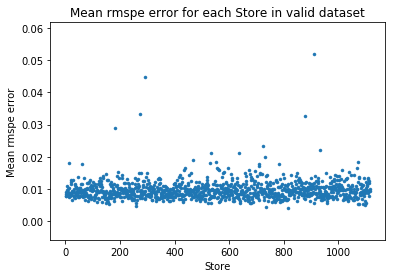

In [74]:
# 观察验证集每个商店的销售预测误差平均值
res_groupby = res.groupby('Store').mean().sort_values('Error', ascending = False)
plt.xlabel('Store')
plt.ylabel('Mean rmspe error')
plt.title('Mean rmspe error for each Store in valid dataset')
plt.scatter(x=res_groupby.index, y = res_groupby['Error'], linewidths=0.5, marker='.');


In [134]:
# 按商店矫正
L = range(1115)
W_ho = []
W_test = []
for n in L:
    s1 = pd.DataFrame(res[res['Store']==n+1], columns = ['True_log', 'Sales_log'])
    s2 = pd.DataFrame(test_df[test_df['Store']==n+1])
    W1=[(0.990+(k/1000)) for k in range(20)] # 从0.990-1.009进行遍历
    S = []
    for w in W1:
        error = rmspe_score(np.exp(s1['True_log'].values), np.exp(s1['Sales_log'].values*w))
        S.append(error)
    Score = pd.Series(S, index = W1)
    BS = Score[Score.values == Score.values.min()]
    a = np.array(BS.index.values)
    b_ho = a.repeat(len(s1))
    b_test = a.repeat(len(s2))
    W_ho.extend(b_ho.tolist())
    W_test.extend(b_test.tolist())

In [135]:
# 验证集矫正后的rmspe
res_sort = res.sort_values('Store', ascending=True)
y_new = res_sort['Sales_log'].values * W_ho
error = rmspe_score(np.exp(res_sort['True_log'].values), np.exp(y_new))
print(error)

0.104451568846


In [159]:
# 保存校正后的验证集预测结果
res_essemble_corr = res_sort.sort_index()
res_essemble_corr = res_essemble_corr[['True', 'Sales_log']]
res_essemble_corr['Sales'] = np.expm1(res_essemble_corr['Sales_log'])
res_essemble_corr = res_essemble_corr.drop('Sales_log', axis = 1)
res_essemble_corr.head()
res_essemble_corr.to_csv('valid_prediction/valid_essemble_corr.csv', index=False)

#### 测试集融合

In [136]:
# 先进性4个模型的预测值融合
test_1 = pd.read_csv('prediction/submission_xgb_1_1.csv')
test_5 = pd.read_csv('prediction/submission_xgb_5.csv')
test_7 = pd.read_csv('prediction/submission_xgb_7.csv')
test_7_13 = pd.read_csv('prediction/submission_xgb_7_13.csv')

test_1_pred = test_1['Sales']
test_5_pred = test_5['Sales']
test_7_pred = test_7['Sales']
test_7_13_pred = test_7_13['Sales']

# 测试集预测结果融合
test_opti = (test_1_pred * i + test_5_pred * i_1 + test_7_pred * i_2 + test_7_13_pred * (1-i-i_1-i_2)) * j
test_opti_submission = pd.DataFrame({'Id':test_1['Id'], 'Sales':test_opti})
test_opti_submission.Sales = test_opti_submission.Sales.astype('int')

# 保存
test_opti_submission.to_csv('prediction/submission_4model.csv', index=False)

In [153]:
# 测试集预测结果矫正
test_res = pd.read_csv('prediction/submission_4model.csv')
test_res['Sales_log'] = np.log1p(test_res['Sales'])
test_submission = test_df.copy()
test_submission = pd.merge(test_submission, test_res, how='left', on='Id')
test_submission = test_submission.sort_values('Store', ascending=True)
test_submission['Sales_corr'] = test_submission['Sales_log'] * W_test
test_cor_submission = test_submission.sort_index()[['Id', 'Sales_corr']]
test_cor_submission['Sales'] = np.expm1(test_cor_submission['Sales_corr']).astype('int')
test_cor_submission = test_cor_submission.drop(columns='Sales_corr', axis = 1)
test_cor_submission.to_csv('prediction/final.csv', index = False)

## 结果可视化

#### 观察验证集的rmspe和std

In [163]:
# 导入校正的验证集预测值
valid_df_pred = pd.read_csv('valid_prediction/valid_essemble_corr.csv')
valid_df_pred.head()

,True,Sales
0,5263.0,5339.738558
1,6064.0,5759.841041
2,8314.0,9280.377587
3,13995.0,12397.137616
4,4822.0,6138.127901


In [164]:
# 计算验证集的rmspe验证集和标准差
valid_df_pred = valid_df_pred.rename(columns=({'Sales':'Sales_Pred'}))
valid_df_alys = valid_set.merge(valid_df_pred, left_index=True, right_index=True)[['Date','Store','Sales','Sales_Pred']]
valid_df_alys['rmspe'] = np.abs((valid_df_alys['Sales'] - valid_df_alys['Sales_Pred']) / valid_df_alys['Sales'])
groupby_store = valid_df_alys.groupby('Store')
mean_rmspe = groupby_store['rmspe'].mean().reset_index(name='mean_rmspe')
std_rmspe = groupby_store['rmspe'].std().reset_index(name='std_rmspe')

C:\Users\cnkehe2\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label
C:\Users\cnkehe2\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


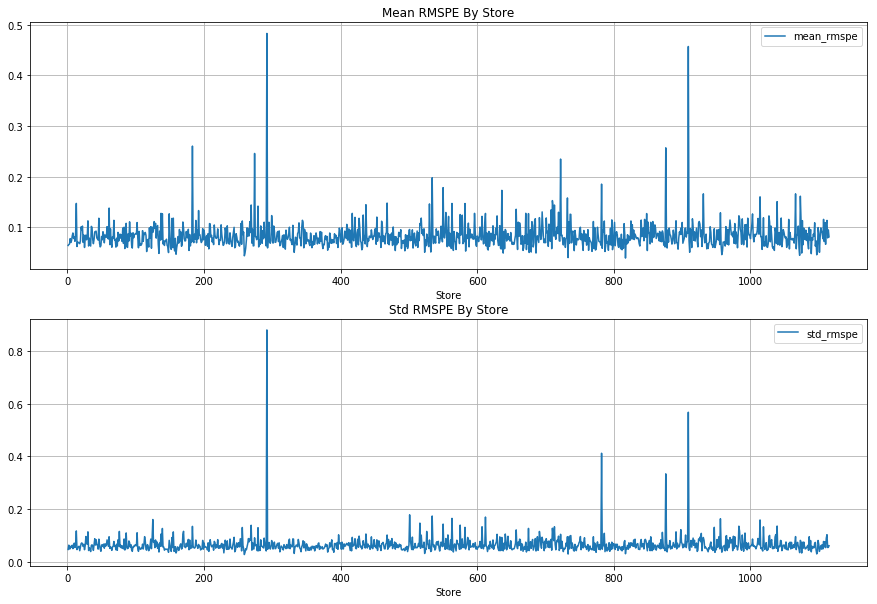

In [165]:
# 可视化
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(15,10))
# ax1.plot(mean_rmspe['Store'].values, mean_rmspe['mean_rmspe'].values, grid=True);
mean_rmspe.plot(x='Store', y=['mean_rmspe'], ax=ax1, grid=True, title='Mean RMSPE By Store');
std_rmspe.plot(x='Store', y=['std_rmspe'],ax=ax2, grid=True, title='Std RMSPE By Store');

#### 观察测试集的销售预测趋势

In [166]:
# 合并训练集和测试集的预测值
train_observ = train_clean.copy()
test_observ = pd.merge(test_clean, test_opti_submission, on='Id')
df_all = pd.concat([train_observ, test_observ], axis=0)

C:\Users\cnkehe2\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 
.resample() is now a deferred operation
You called plot(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead
  after removing the cwd from sys.path.


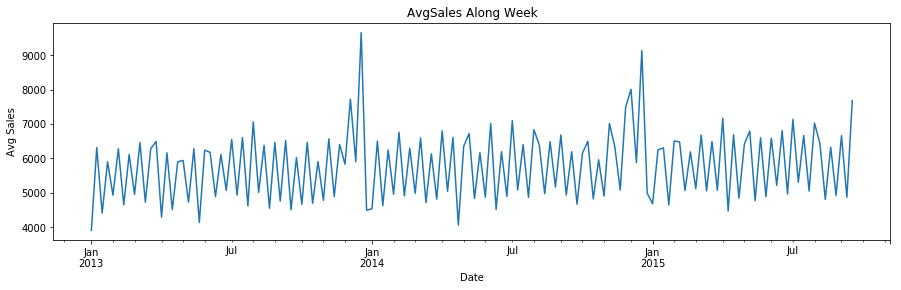

In [167]:
# 可视化
fig, ax = plt.subplots(1, figsize=(15,4))
plt.ylabel('Avg Sales')
plt.xlabel('Time')
df_all.groupby('Date').mean()['Sales'].resample('W').plot(ax=ax, title='AvgSales Along Week');

In [ ]:
# train_data = lgb.Dataset(train_set_X, label=train_set_y)
# param = {'num_leaves':150, 'objective':'binary','max_depth':7,'learning_rate':.05,'max_bin':200}
# param['metric'] = ['auc', 'binary_logloss']

In [ ]:
# num_round=50
# start=datetime.now()
# lgbm=lgb.train(param,train_data,num_round)
# stop=datetime.now()
# print(stop-start)

In [ ]:
# ypred2 = lgbm.predict(train_set_X)

In [ ]:
# df_submission = pd.DataFrame(data=[np.arange(1,41089),ypred2],index=['Id','Sales'])
# df_submission = df_submission.T

In [ ]:
# df_submission.to_csv('submission_lgb.csv')